# Analysis of Leios simulations at branch `bwbush/pre-edi`

## Load dependencies

In [1]:
suppressMessages({
    require(bit64, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(mongolite, quietly=TRUE)
    require(R.utils, quietly=TRUE)
    require(stringr, quietly=TRUE)
})

## Read results

In [2]:
load("results/partial.R")

### Elapsed time for blocks

In [3]:
receipts %>% summary

   simulator                    network                     label         
 haskell: 5147384   100-nodes       :72721326   default        :84667269  
 rust   :93364090   100-nodes-16cpus: 4726144   extended-voting: 4726144  
                    100-nodes-1cpus : 5340159   oldest-first   : 4356843  
                    100-nodes-2cpus : 5618068   peer-order     : 4761218  
                    100-nodes-4cpus : 5380304                             
                    100-nodes-8cpus : 4725473                             
                                                                          
 leios-stage-length-slots ib-generation-probability ib-body-avg-size-bytes
 Min.   :20.00            Min.   : 1.00             Min.   :98304         
 1st Qu.:20.00            1st Qu.:10.00             1st Qu.:98304         
 Median :20.00            Median :20.00             Median :98304         
 Mean   :31.72            Mean   :17.24             Mean   :98304         
 3rd Qu.:40.00           

### CPU usage

In [4]:
cpus %>% summary

   simulator                    network         leios-stage-length-slots
 haskell:17825704   100-nodes       :24986302   Min.   :20.00           
 rust   :16252176   100-nodes-16cpus: 1917204   1st Qu.:20.00           
                    100-nodes-1cpus : 1535506   Median :20.00           
                    100-nodes-2cpus : 1820864   Mean   :32.69           
                    100-nodes-4cpus : 1896007   3rd Qu.:40.00           
                    100-nodes-8cpus : 1921997   Max.   :60.00           
                                                                        
 ib-generation-probability ib-body-avg-size-bytes eb-generation-probability
 Min.   : 1.0              Min.   :98304          Min.   :1.000            
 1st Qu.: 5.0              1st Qu.:98304          1st Qu.:1.500            
 Median :15.0              Median :98304          Median :1.500            
 Mean   :13.2              Mean   :98304          Mean   :1.665            
 3rd Qu.:20.0              3rd Qu.:9

### Scenarios present in dataset

In [5]:
receipts[, .(`Records`=.N), by=.(`simulator`, `network`, `label`)][order(`simulator`, `network`, `label`)]

simulator,network,label,Records
<fct>,<fct>,<fct>,<int>
haskell,100-nodes,default,2987284
haskell,100-nodes-1cpus,default,614007
haskell,100-nodes-2cpus,default,892062
haskell,100-nodes-4cpus,default,654031
rust,100-nodes,default,55889837
rust,100-nodes,extended-voting,4726144
rust,100-nodes,oldest-first,4356843
rust,100-nodes,peer-order,4761218
rust,100-nodes-16cpus,default,4726144


## Effect of limiting CPU

In [6]:
cpuCase <- function(network) {
    cpuLevels <- c("1 CPU/node", "2 CPUs/node", "4 CPUs/node", "8 CPUs/node", "16 CPUs/node", "Unlimited CPUs")
    if (network == "100-nodes")
        factor("Unlimited CPUs", levels=cpuLevels)
    else if (network == "100-nodes-1cpus")
        factor("1 CPU/node", levels=cpuLevels)
    else if (network == "100-nodes-2cpus")
        factor("2 CPUs/node", levels=cpuLevels)
    else if (network == "100-nodes-4cpus")
        factor("4 CPUs/node", levels=cpuLevels)
    else if (network == "100-nodes-8cpus")
        factor("8 CPUs/node", levels=cpuLevels)
    else if (network == "100-nodes-16cpus")
        factor("16 CPUs/node", levels=cpuLevels)
    else
        null
}

In [7]:
ibRate <- function(rate)
    factor(paste(rate, "IB/s"), levels=c("1 IB/s", "5 IB/s", "10 IB/s", "15 IB/s", "20 IB/s", "25 IB/s"))

In [8]:
cpuLimited <- cpus[
    `label` == "default" &
    `ib-body-avg-size-bytes` == 98304 &
    `eb-generation-probability` == 1.5 &
    `leios-stage-length-slots` == 20,
    .(
        `Total CPU [s/slot/node]`=sum(`duration`)
    ),
    by=.(
        `simulator`,
        `CPUs`=mapply(cpuCase, `network`),
        `IB Rate`=mapply(ibRate, `ib-generation-probability`),
        `Time [s]`=`slot`,
        `node`
    )
]
cpuLimited %>% summary

   simulator                   CPUs           IB Rate          Time [s]    
 haskell:2134941   1 CPU/node    :693602   1 IB/s :671913   Min.   :  0.0  
 rust   :2114805   2 CPUs/node   :708206   5 IB/s :717658   1st Qu.:152.0  
                   4 CPUs/node   :711547   10 IB/s:717148   Median :301.0  
                   8 CPUs/node   :712121   15 IB/s:715221   Mean   :300.7  
                   16 CPUs/node  :712108   20 IB/s:714730   3rd Qu.:450.0  
                   Unlimited CPUs:712162   25 IB/s:713076   Max.   :600.0  
                                                                           
      node         Total CPU [s/slot/node]
 node-20:  42659   Min.   :0.0000         
 node-84:  42659   1st Qu.:0.2110         
 node-79:  42653   Median :0.7677         
 node-53:  42633   Mean   :0.9899         
 node-96:  42633   3rd Qu.:1.6962         
 node-82:  42628   Max.   :4.9853         
 (Other):3993881                          

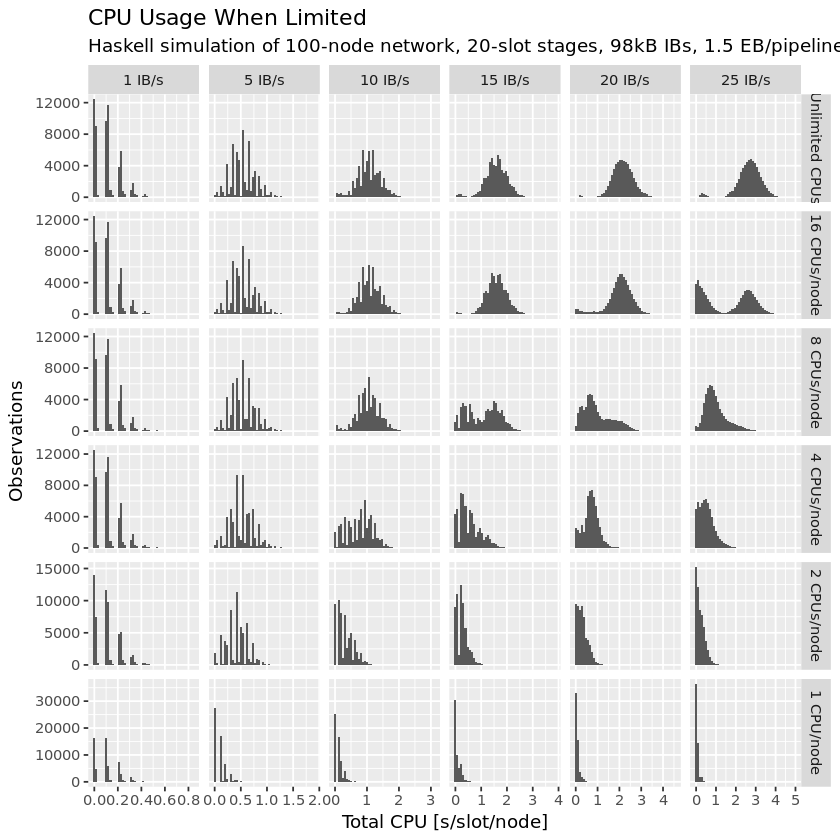

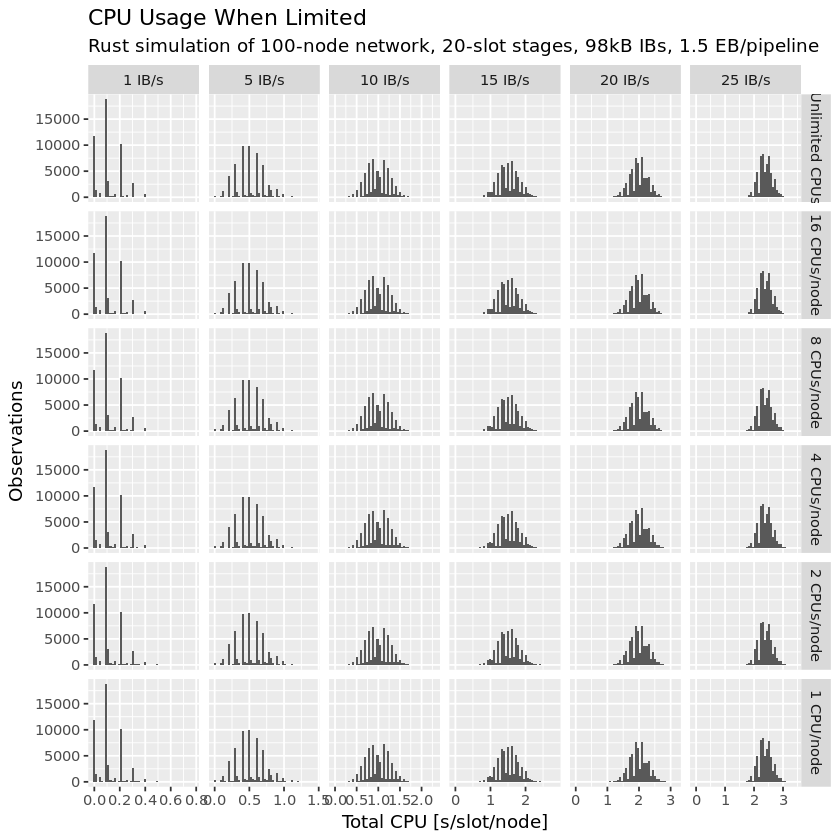

In [9]:
for (s in cpuLimited[,unique(`simulator`)%>%sort]) {
    g <- ggplot(cpuLimited[`simulator` == s], aes(x=`Total CPU [s/slot/node]`)) +
        geom_histogram(bins=50) +
        facet_grid(factor(`CPUs`, levels=levels(`CPUs`)%>%rev) ~ `IB Rate`, scales="free") +
        ylab("Observations") +
        ggtitle("CPU Usage When Limited", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 20-slot stages, 98kB IBs, 1.5 EB/pipeline"))
        print(g)
        ggsave(paste0("plots/cpu-limited-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

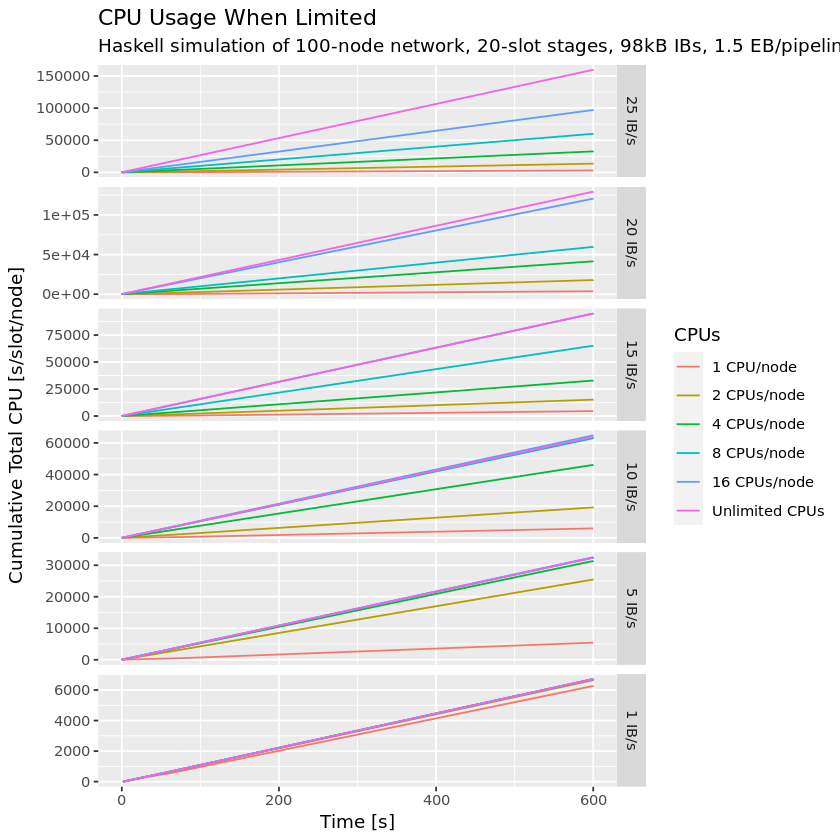

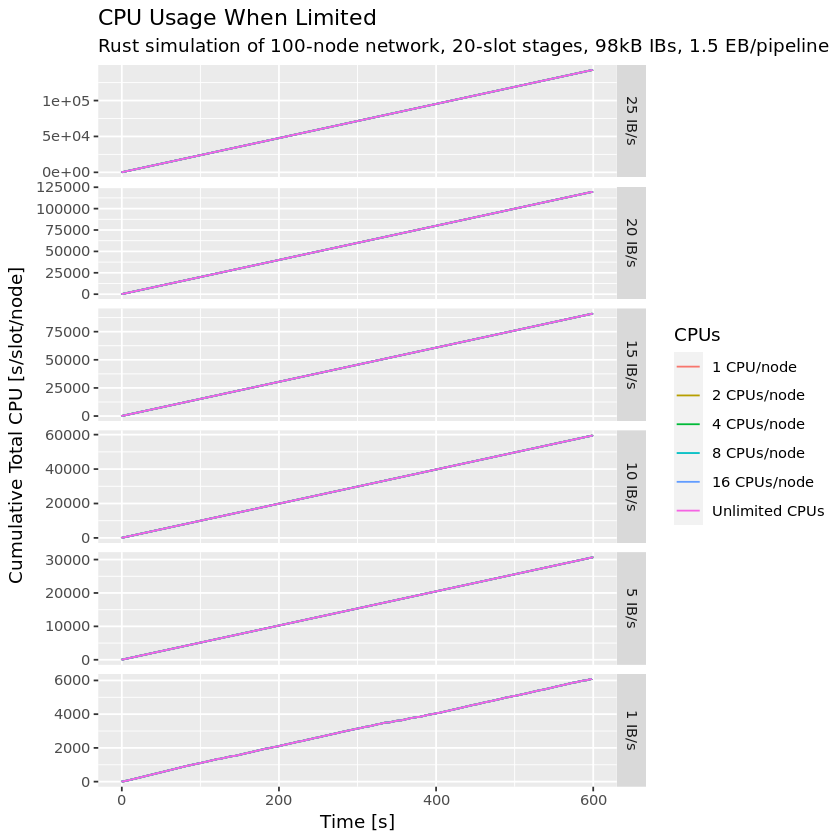

In [10]:
for (s in cpuLimited[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        cpuLimited[
            `simulator` == s, .(`Time [s]`, `Total CPU [s/slot/node]`=mean(`Total CPU [s/slot/node]`)), by=.(`CPUs`, `IB Rate`)
        ][
            order(`CPUs`, `IB Rate`, `Time [s]`)
        ][, .(`Time [s]`, `Cumulative Total CPU [s/slot/node]`=cumsum(`Total CPU [s/slot/node]`)), by=.(`CPUs`, `IB Rate`)],
        aes(x=`Time [s]`, y=`Cumulative Total CPU [s/slot/node]`, color=`CPUs`)
    ) +
        geom_line() +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev) ~ ., scales="free_y") +
        ggtitle("CPU Usage When Limited", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 20-slot stages, 98kB IBs, 1.5 EB/pipeline"))
        print(g)
        ggsave(paste0("plots/cpu-limited-cumulative-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

In [29]:
receiptLimited <- receipts[
    `label` == "default" &
    `ib-body-avg-size-bytes` == 98304 &
    `eb-generation-probability` == 1.5 &
    `leios-stage-length-slots` == 20 &
    `kind` == "IB",
    .(
        `simulator`,
        `CPUs`=mapply(cpuCase, `network`),
        `IB Rate`=mapply(ibRate, `ib-generation-probability`),
        `elapsed`,
        `item`,
        `sent`,
        `received`
    )
]
receiptLimited %>% summary

   simulator                    CPUs            IB Rate       
 haskell: 1164441   1 CPU/node    :4553096   1 IB/s : 402005  
 rust   :26737736   2 CPUs/node   :4831626   5 IB/s :2359405  
                    4 CPUs/node   :4852038   10 IB/s:3533402  
                    8 CPUs/node   :4456097   15 IB/s:5461036  
                    16 CPUs/node  :4456368   20 IB/s:7522519  
                    Unlimited CPUs:4752952   25 IB/s:8623810  
                                                              
    elapsed                  item               sent           received     
 Min.   :  0.000   0-node-22-0 :    3000   Min.   :  0.13   Min.   :  0.13  
 1st Qu.:  1.326   0-node-32-0 :    3000   1st Qu.:150.13   1st Qu.:152.18  
 Median :  1.934   0-node-69-0 :    3000   Median :301.13   Median :302.89  
 Mean   :  2.148   0-node-89-0 :    3000   Mean   :300.27   Mean   :302.41  
 3rd Qu.:  2.649   1-node-90-0 :    3000   3rd Qu.:451.13   3rd Qu.:453.09  
 Max.   :339.173   54-node-23-0:  

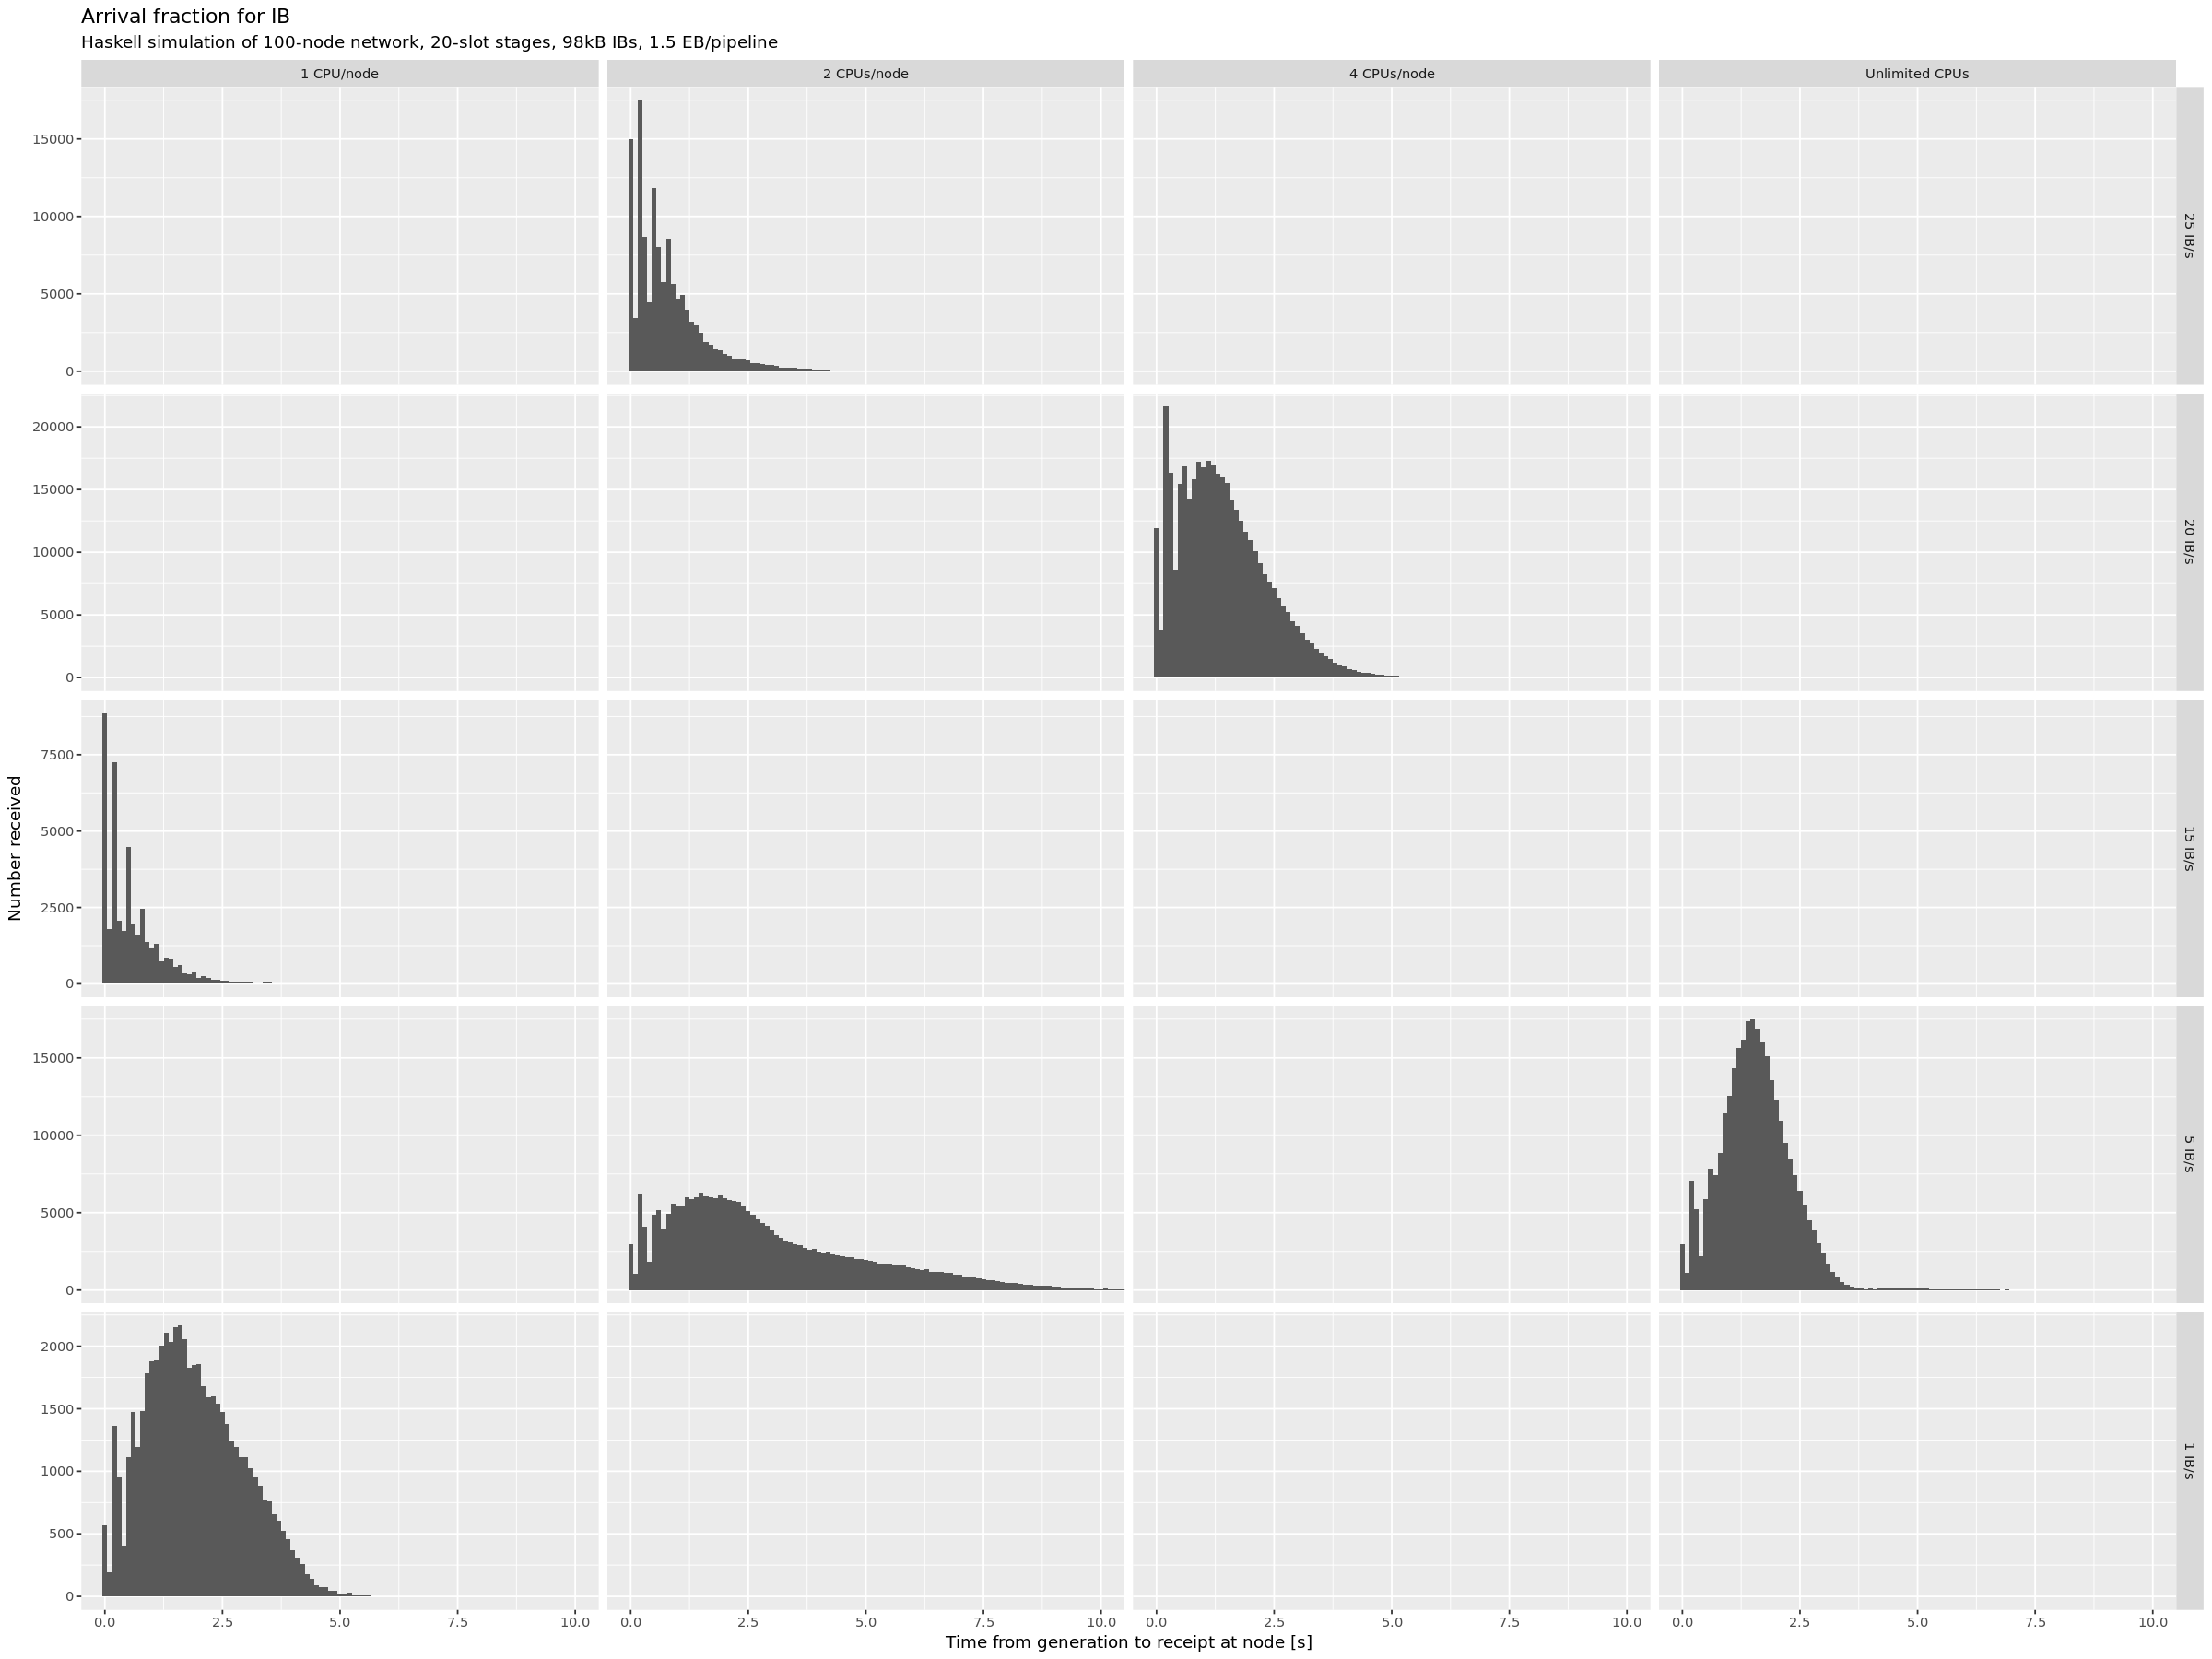

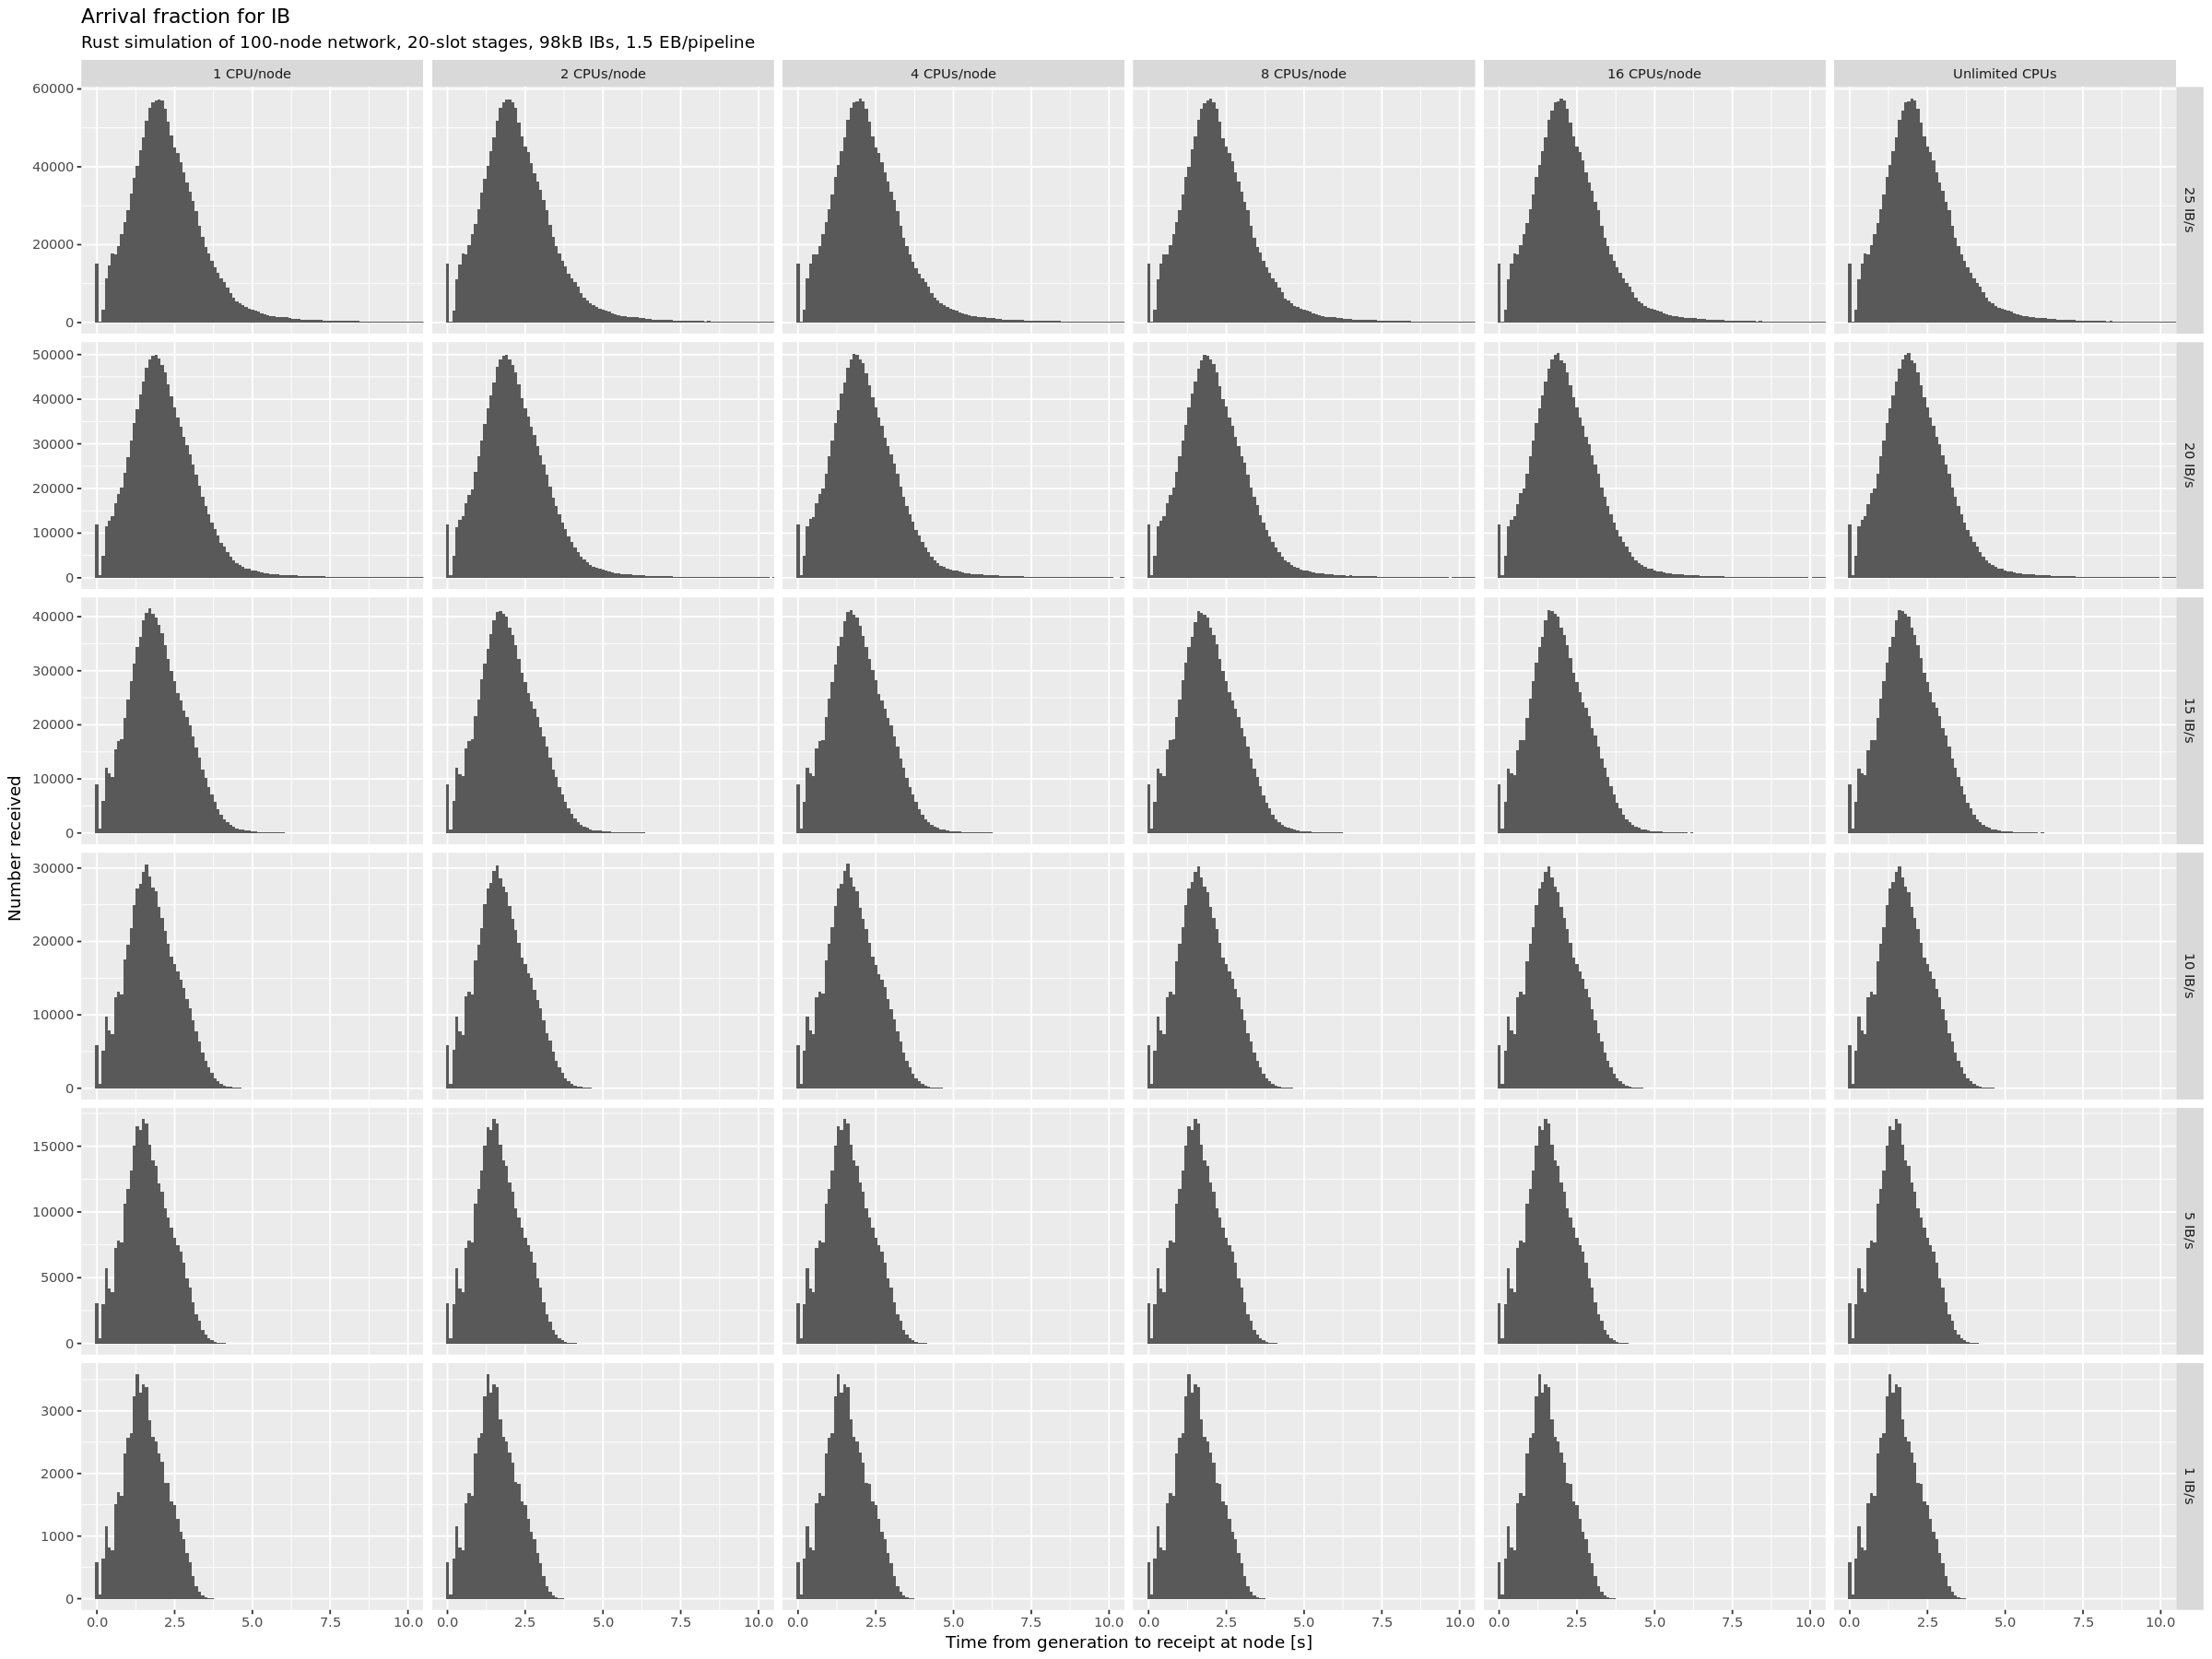

In [30]:
for (s in receiptLimited[,unique(`simulator`)%>%sort]) {
    g <- ggplot(receiptLimited[`simulator` == s], aes(x=`elapsed`)) +
        geom_histogram(binwidth=0.1) +
        coord_cartesian(xlim=c(0,10)) +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev) ~ `CPUs`, scales="free") +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle("Arrival fraction for IB", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 20-slot stages, 98kB IBs, 1.5 EB/pipeline"))
        print(g)
        ggsave(paste0("plots/receipt-limited-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

In [31]:
arrivalLimited <- receiptLimited[
    !is.na(`received`) & `sent` <= 540,
    .(`received`=as.numeric(.N)),
    by=.(`simulator`, `CPUs`, `IB Rate`, `sent`, `item`)
][,
    .(`total`=as.numeric(.N), `received`=sum(`received`)),
    by=.(`simulator`, `CPUs`, `IB Rate`, `sent`)
][,
    .(`received`=sum(`received`)/sum(`total`)),
    by=.(`simulator`, `CPUs`, `IB Rate`, `sent`)
]

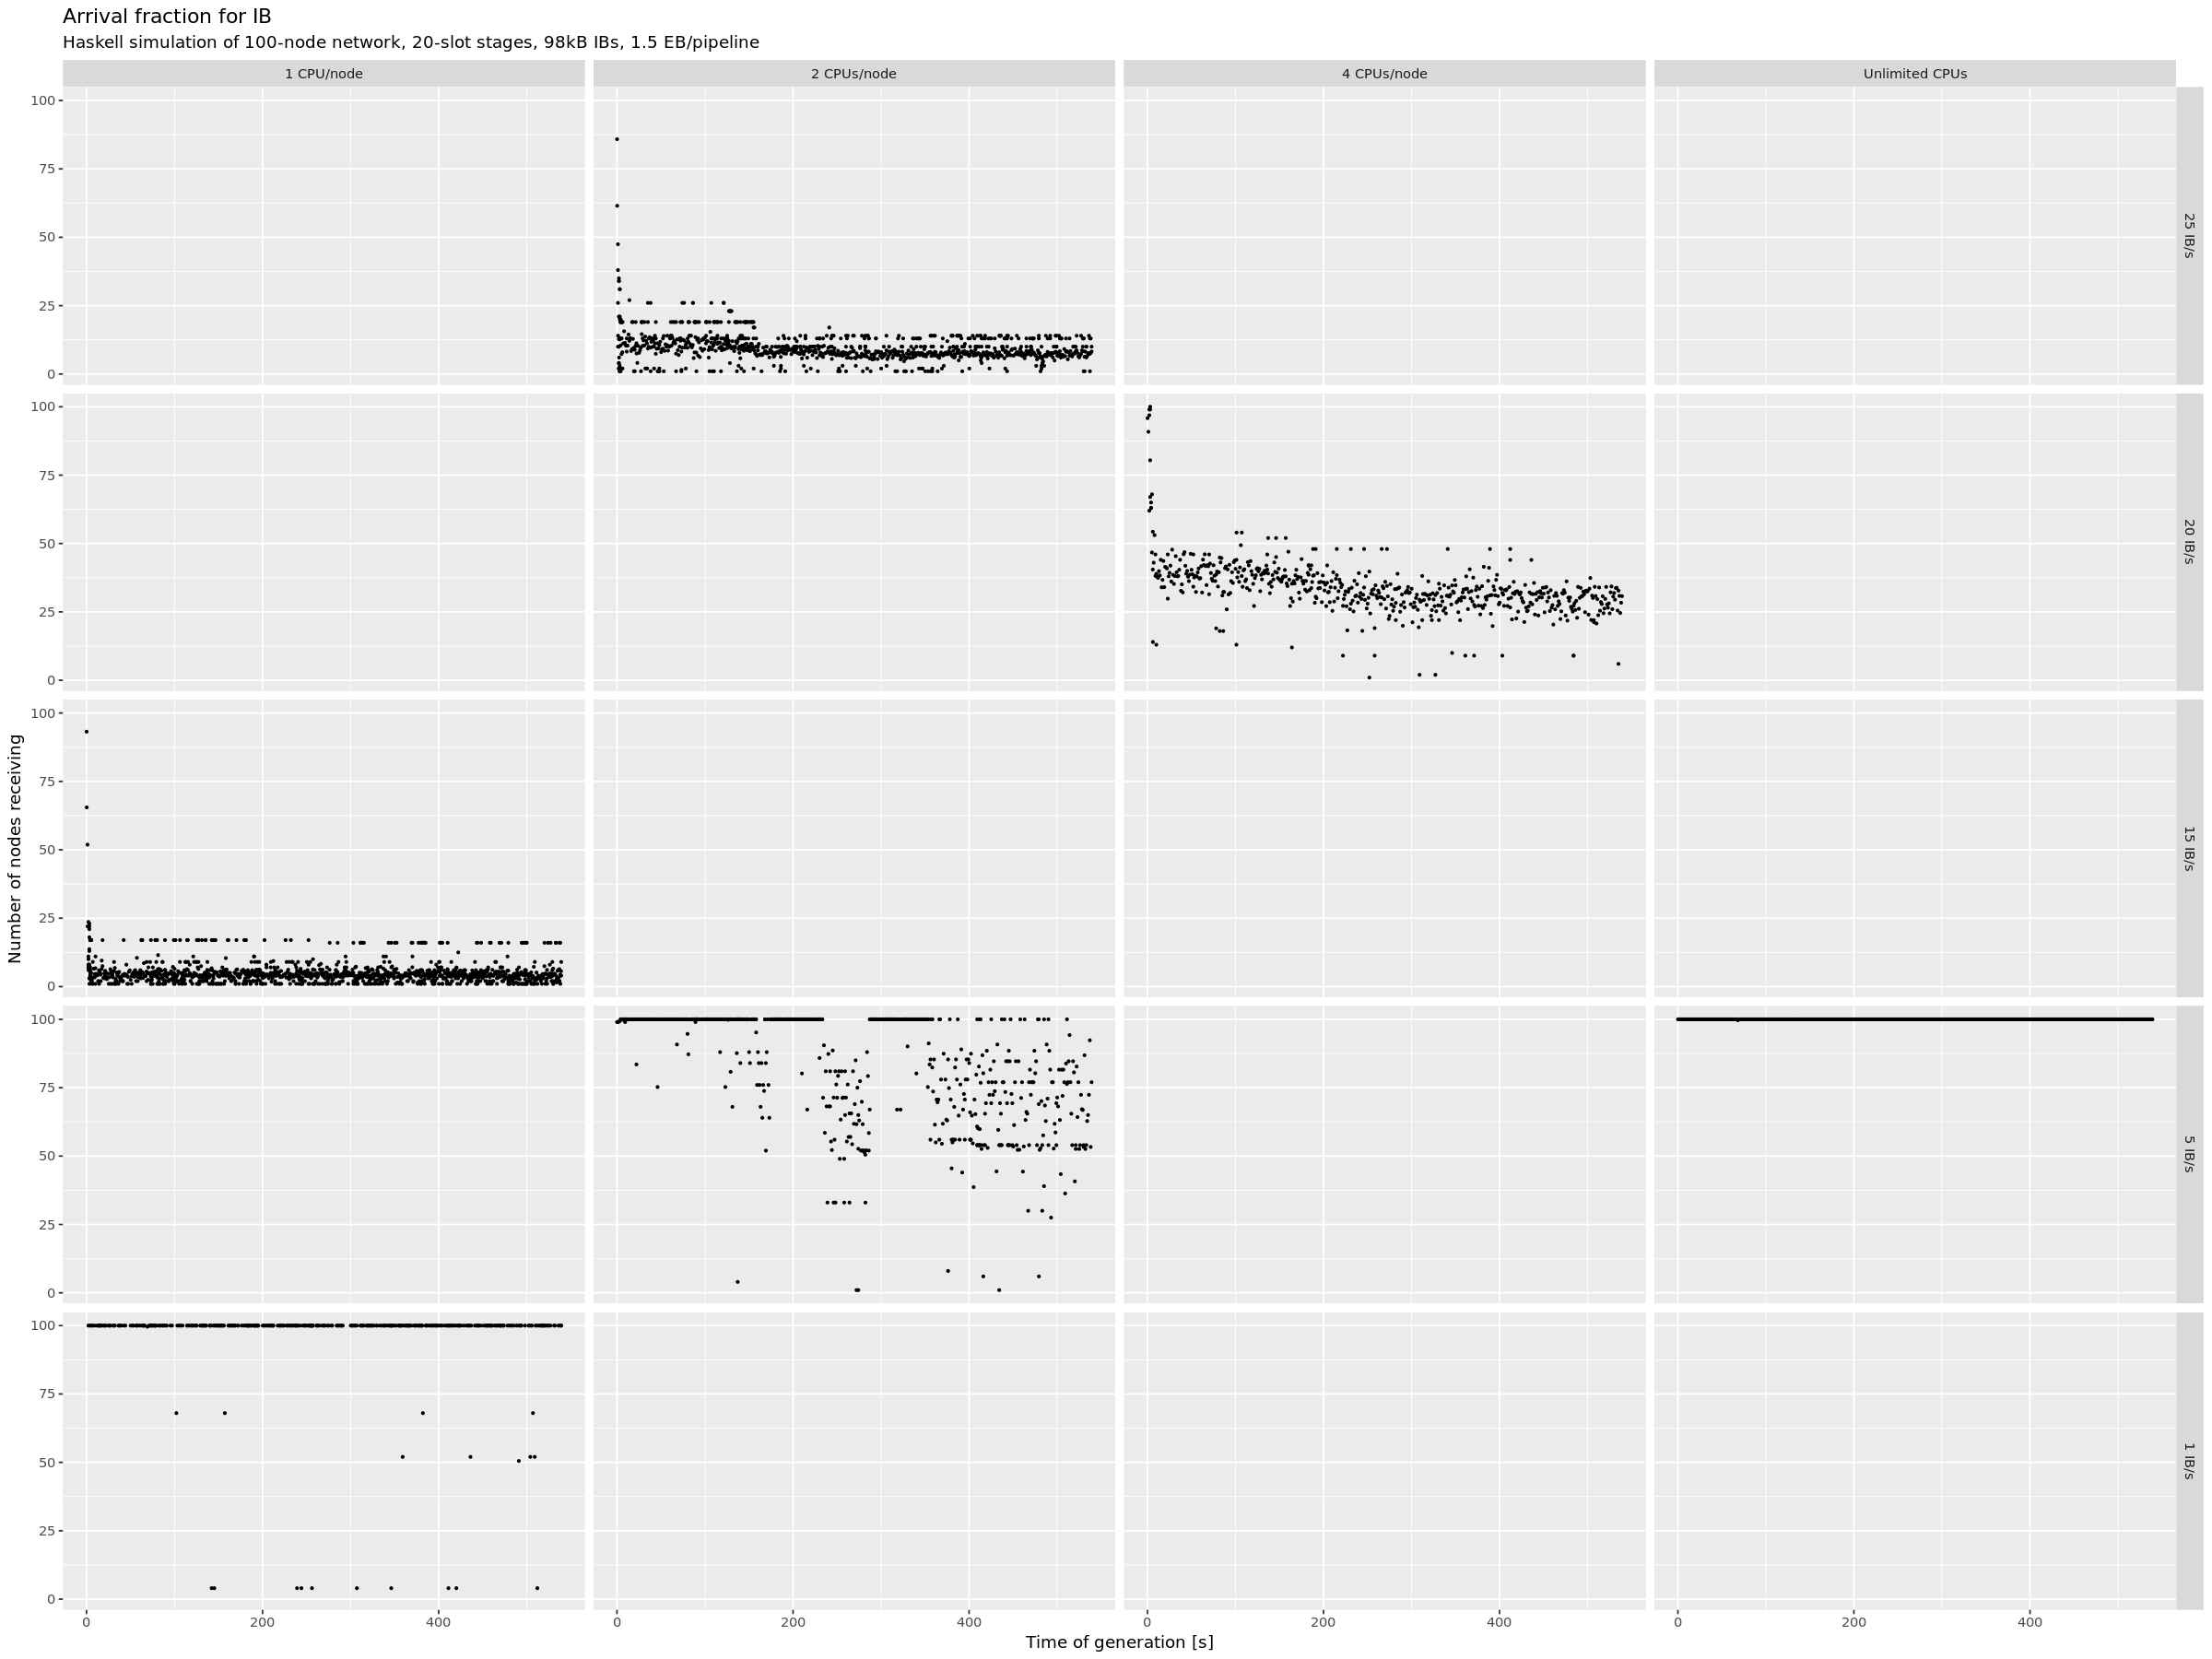

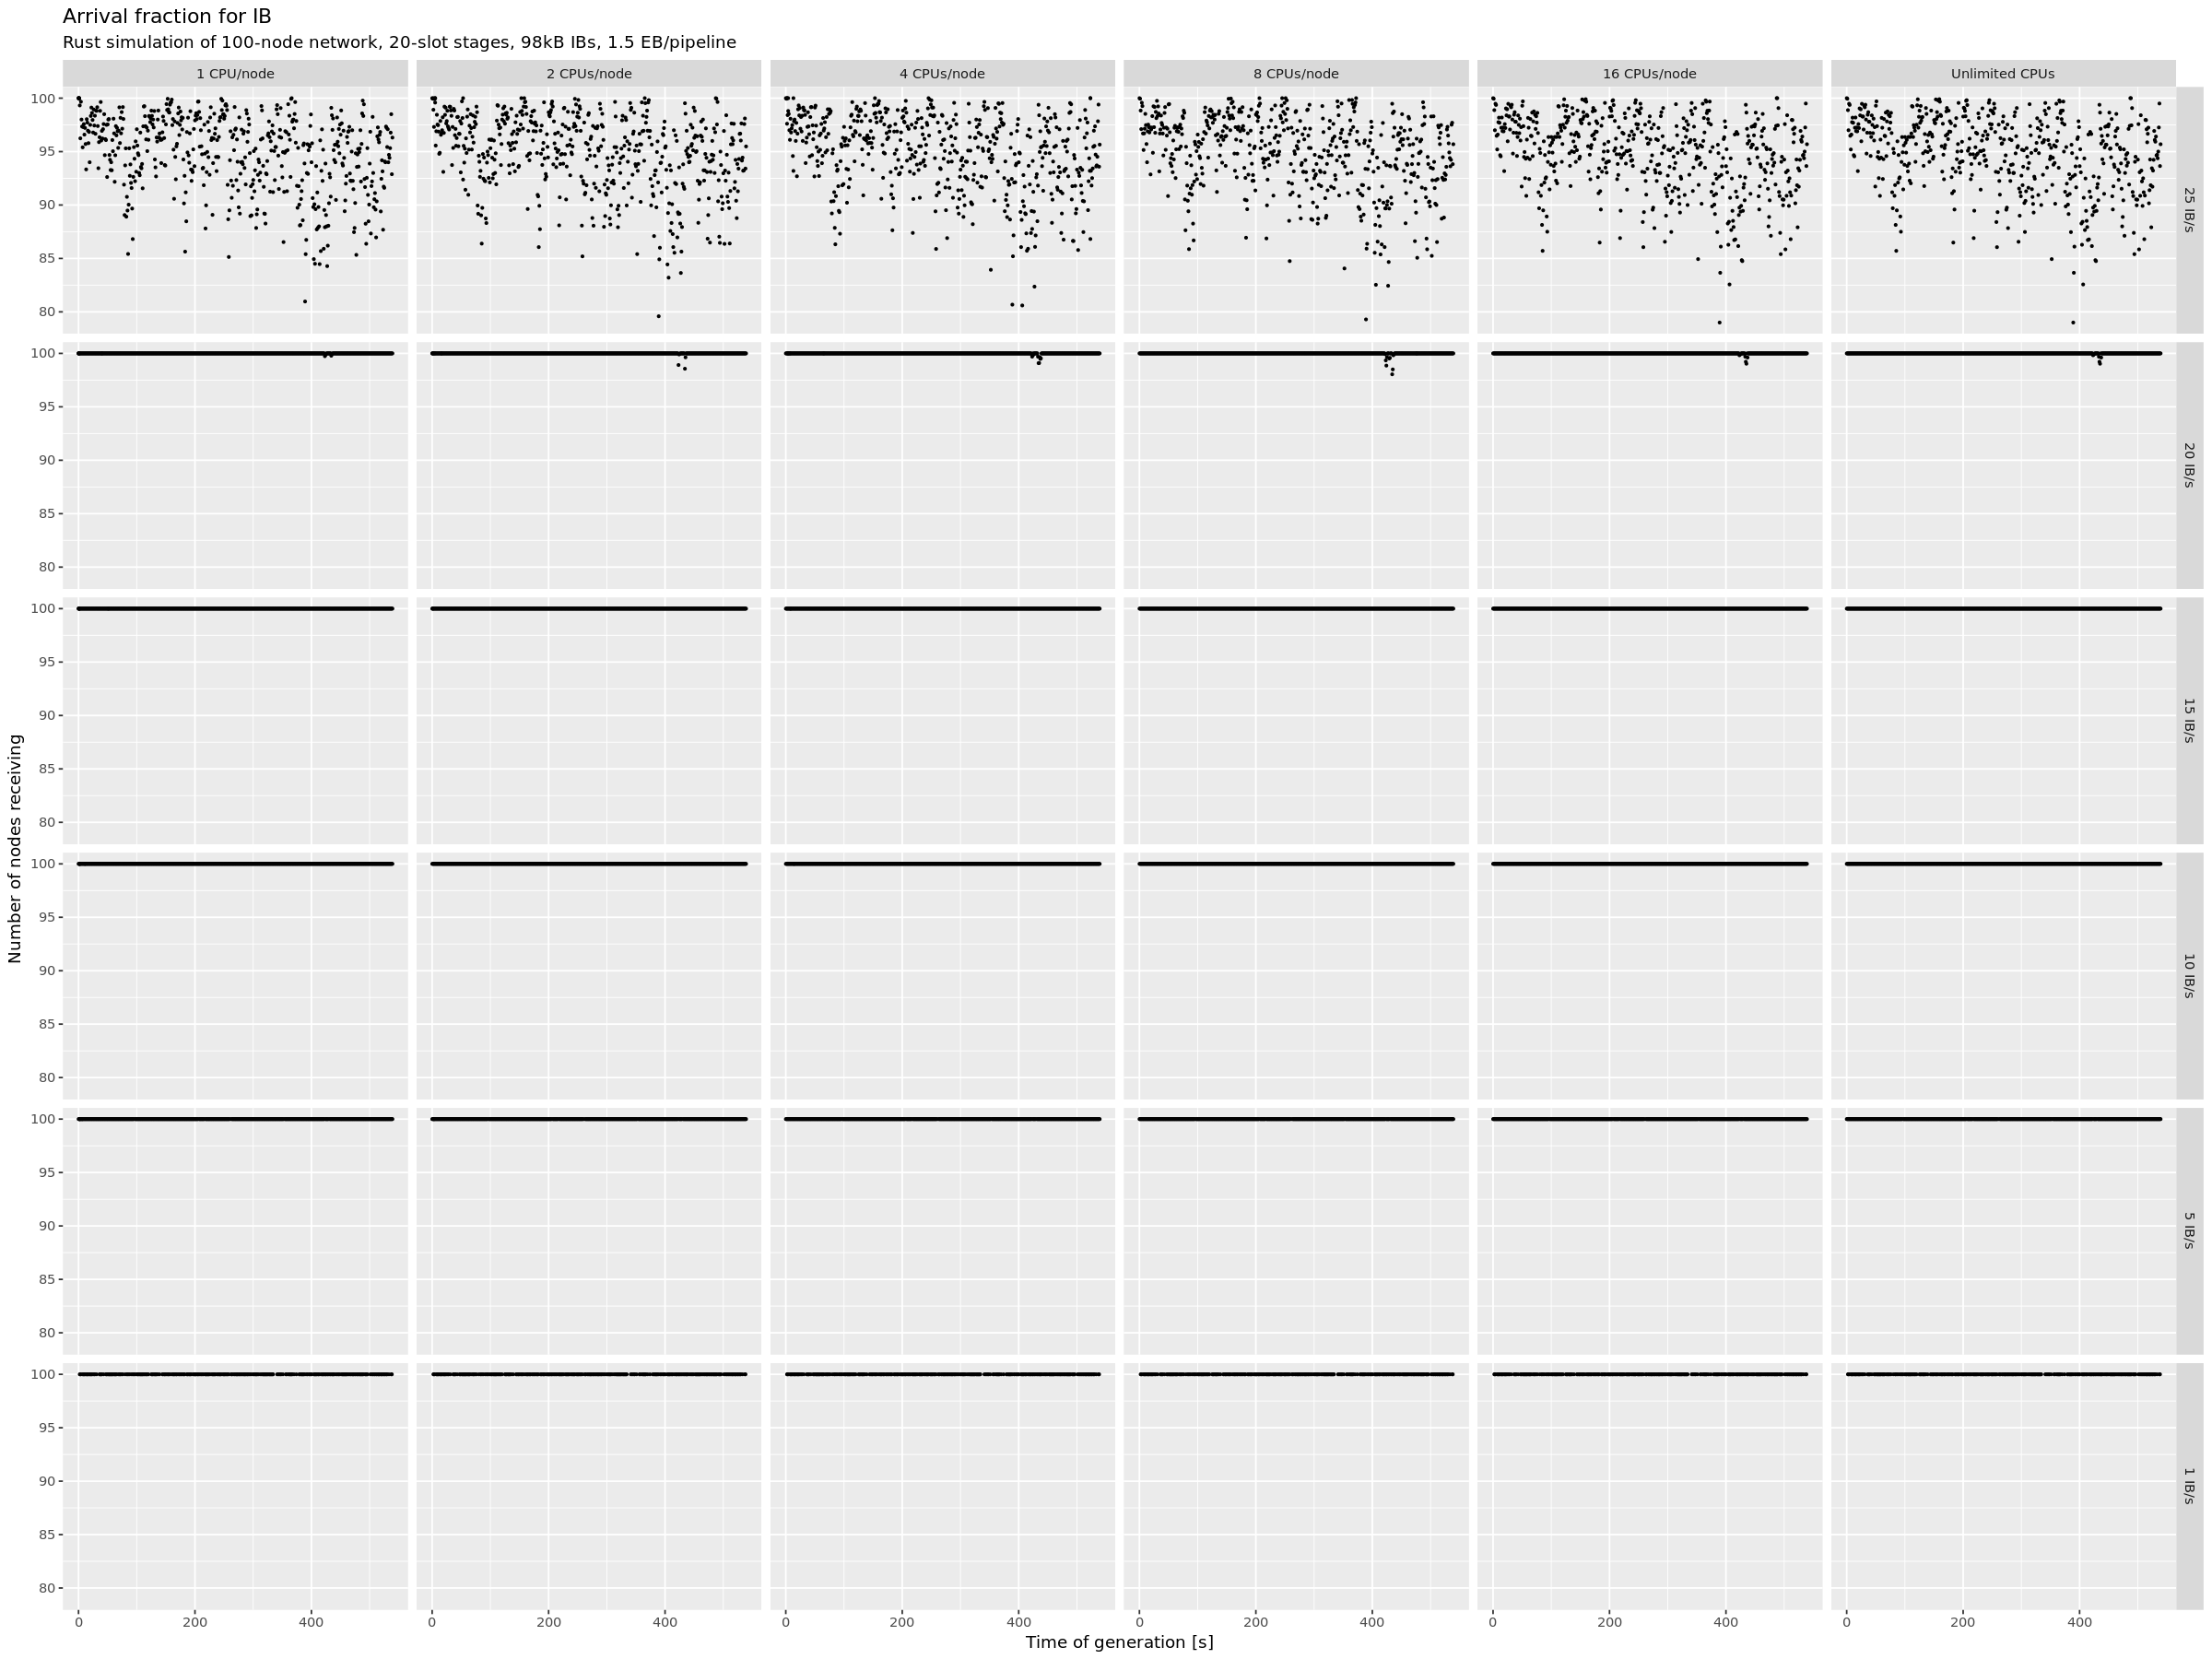

In [32]:
for (s in arrivalLimited[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        arrivalLimited[`simulator` == s], 
        aes(x=`sent`, y=`received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev)  ~ `CPUs`) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle("Arrival fraction for IB", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 20-slot stages, 98kB IBs, 1.5 EB/pipeline"))
    print(g)
    ggsave(paste0("plots/arrival-limited-IB-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

## Effect of delivery order

In [33]:
orderCase <- function(label) {
    labelLevels <- c("oldest-first", "peer-order", "freshest-first")
    if (label == "default")
        factor("freshest-first", levels=labelLevels)
    else
        factor(label, levels=labelLevels)
}    

In [34]:
receiptOrdered <- receipts[
    `label` %in% c("default", "oldest-first", "peer-order") &
    `network` == "100-nodes" &
    `ib-body-avg-size-bytes` == 98304 &
    `eb-generation-probability` == 1.5 &
    `leios-stage-length-slots` == 20 &
    `kind` == "IB",
    .(
        `simulator`,
        `Ordering`=mapply(orderCase, `label`),
        `IB Rate`=mapply(ibRate, `ib-generation-probability`),
        `elapsed`,
        `item`,
        `sent`,
        `received`
    )
]
receiptOrdered %>% summary

   simulator                  Ordering          IB Rate       
 haskell:  296584   oldest-first  :4089767   1 IB/s : 173700  
 rust   :13034377   peer-order    :4488242   5 IB/s :1204375  
                    freshest-first:4752952   10 IB/s:1766504  
                                             15 IB/s:2692864  
                                             20 IB/s:3445189  
                                             25 IB/s:4048329  
                                                              
    elapsed                  item               sent           received     
 Min.   :  0.000   0-node-22-0 :    1500   Min.   :  0.13   Min.   :  0.13  
 1st Qu.:  1.435   0-node-32-0 :    1500   1st Qu.:146.13   1st Qu.:153.31  
 Median :  2.171   0-node-69-0 :    1500   Median :292.13   Median :303.66  
 Mean   :  9.246   0-node-89-0 :    1500   Mean   :293.84   Mean   :303.09  
 3rd Qu.:  3.225   1-node-90-0 :    1500   3rd Qu.:438.13   3rd Qu.:453.54  
 Max.   :286.211   54-node-23-0:  

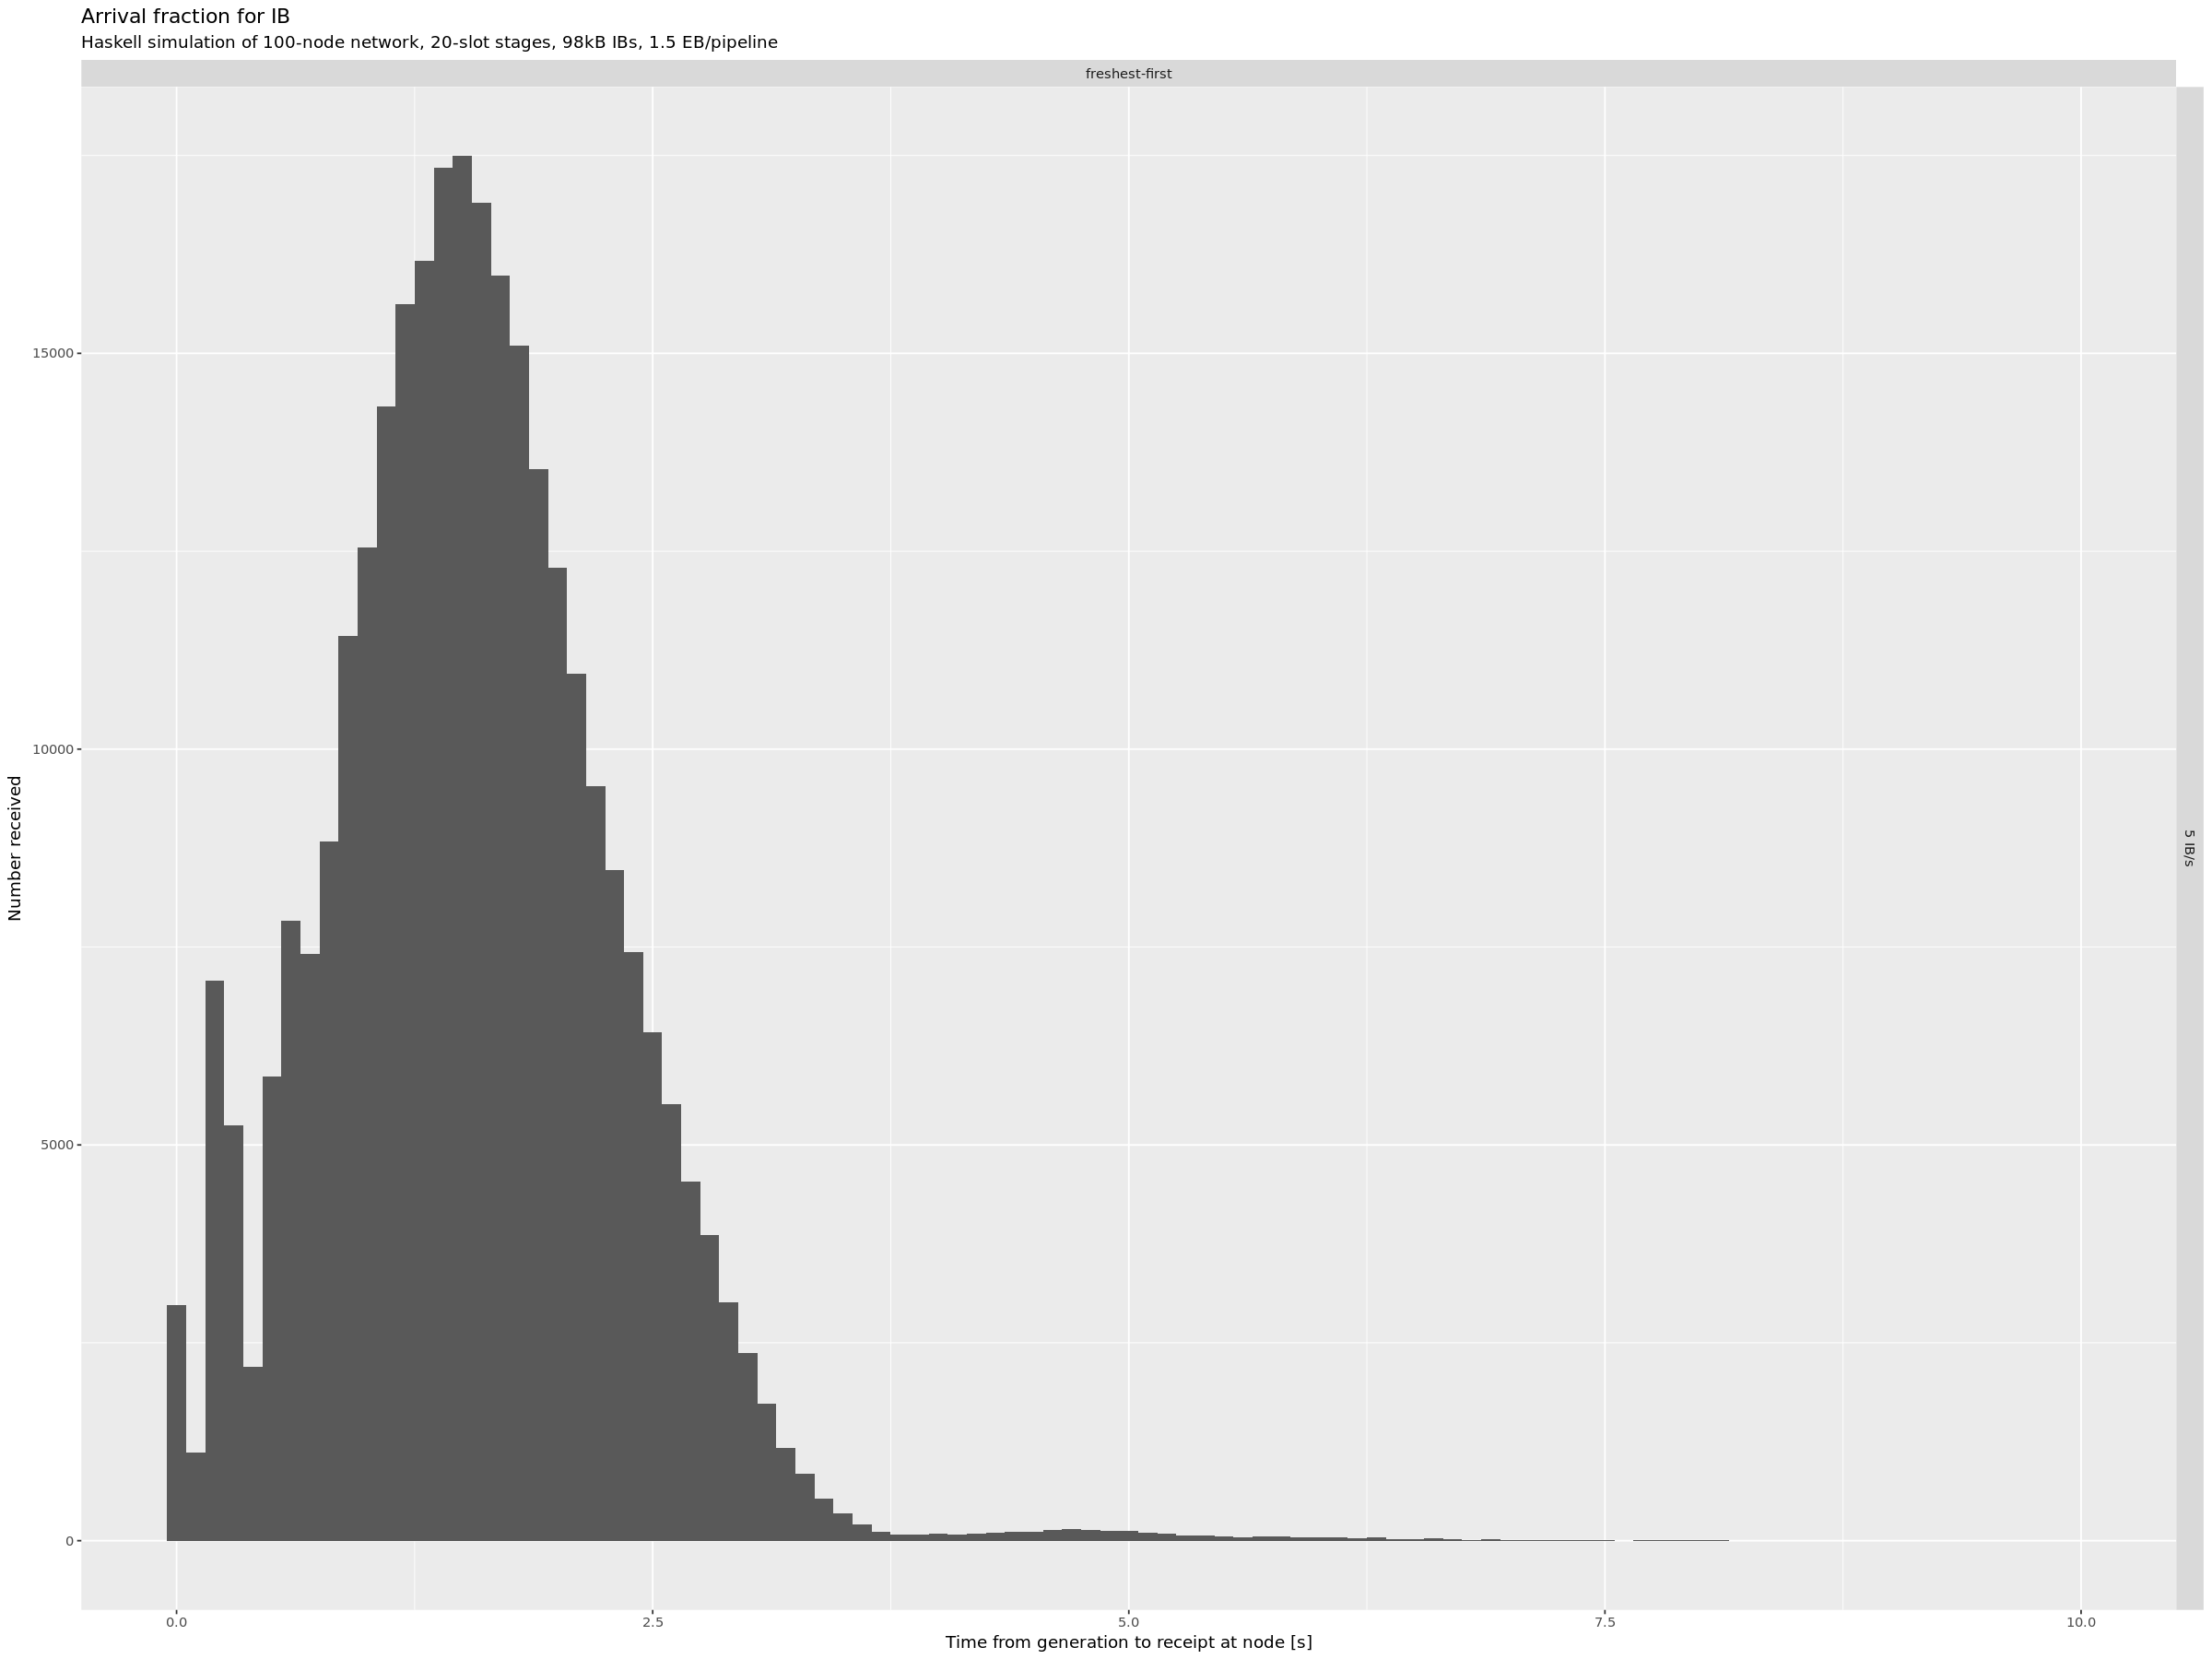

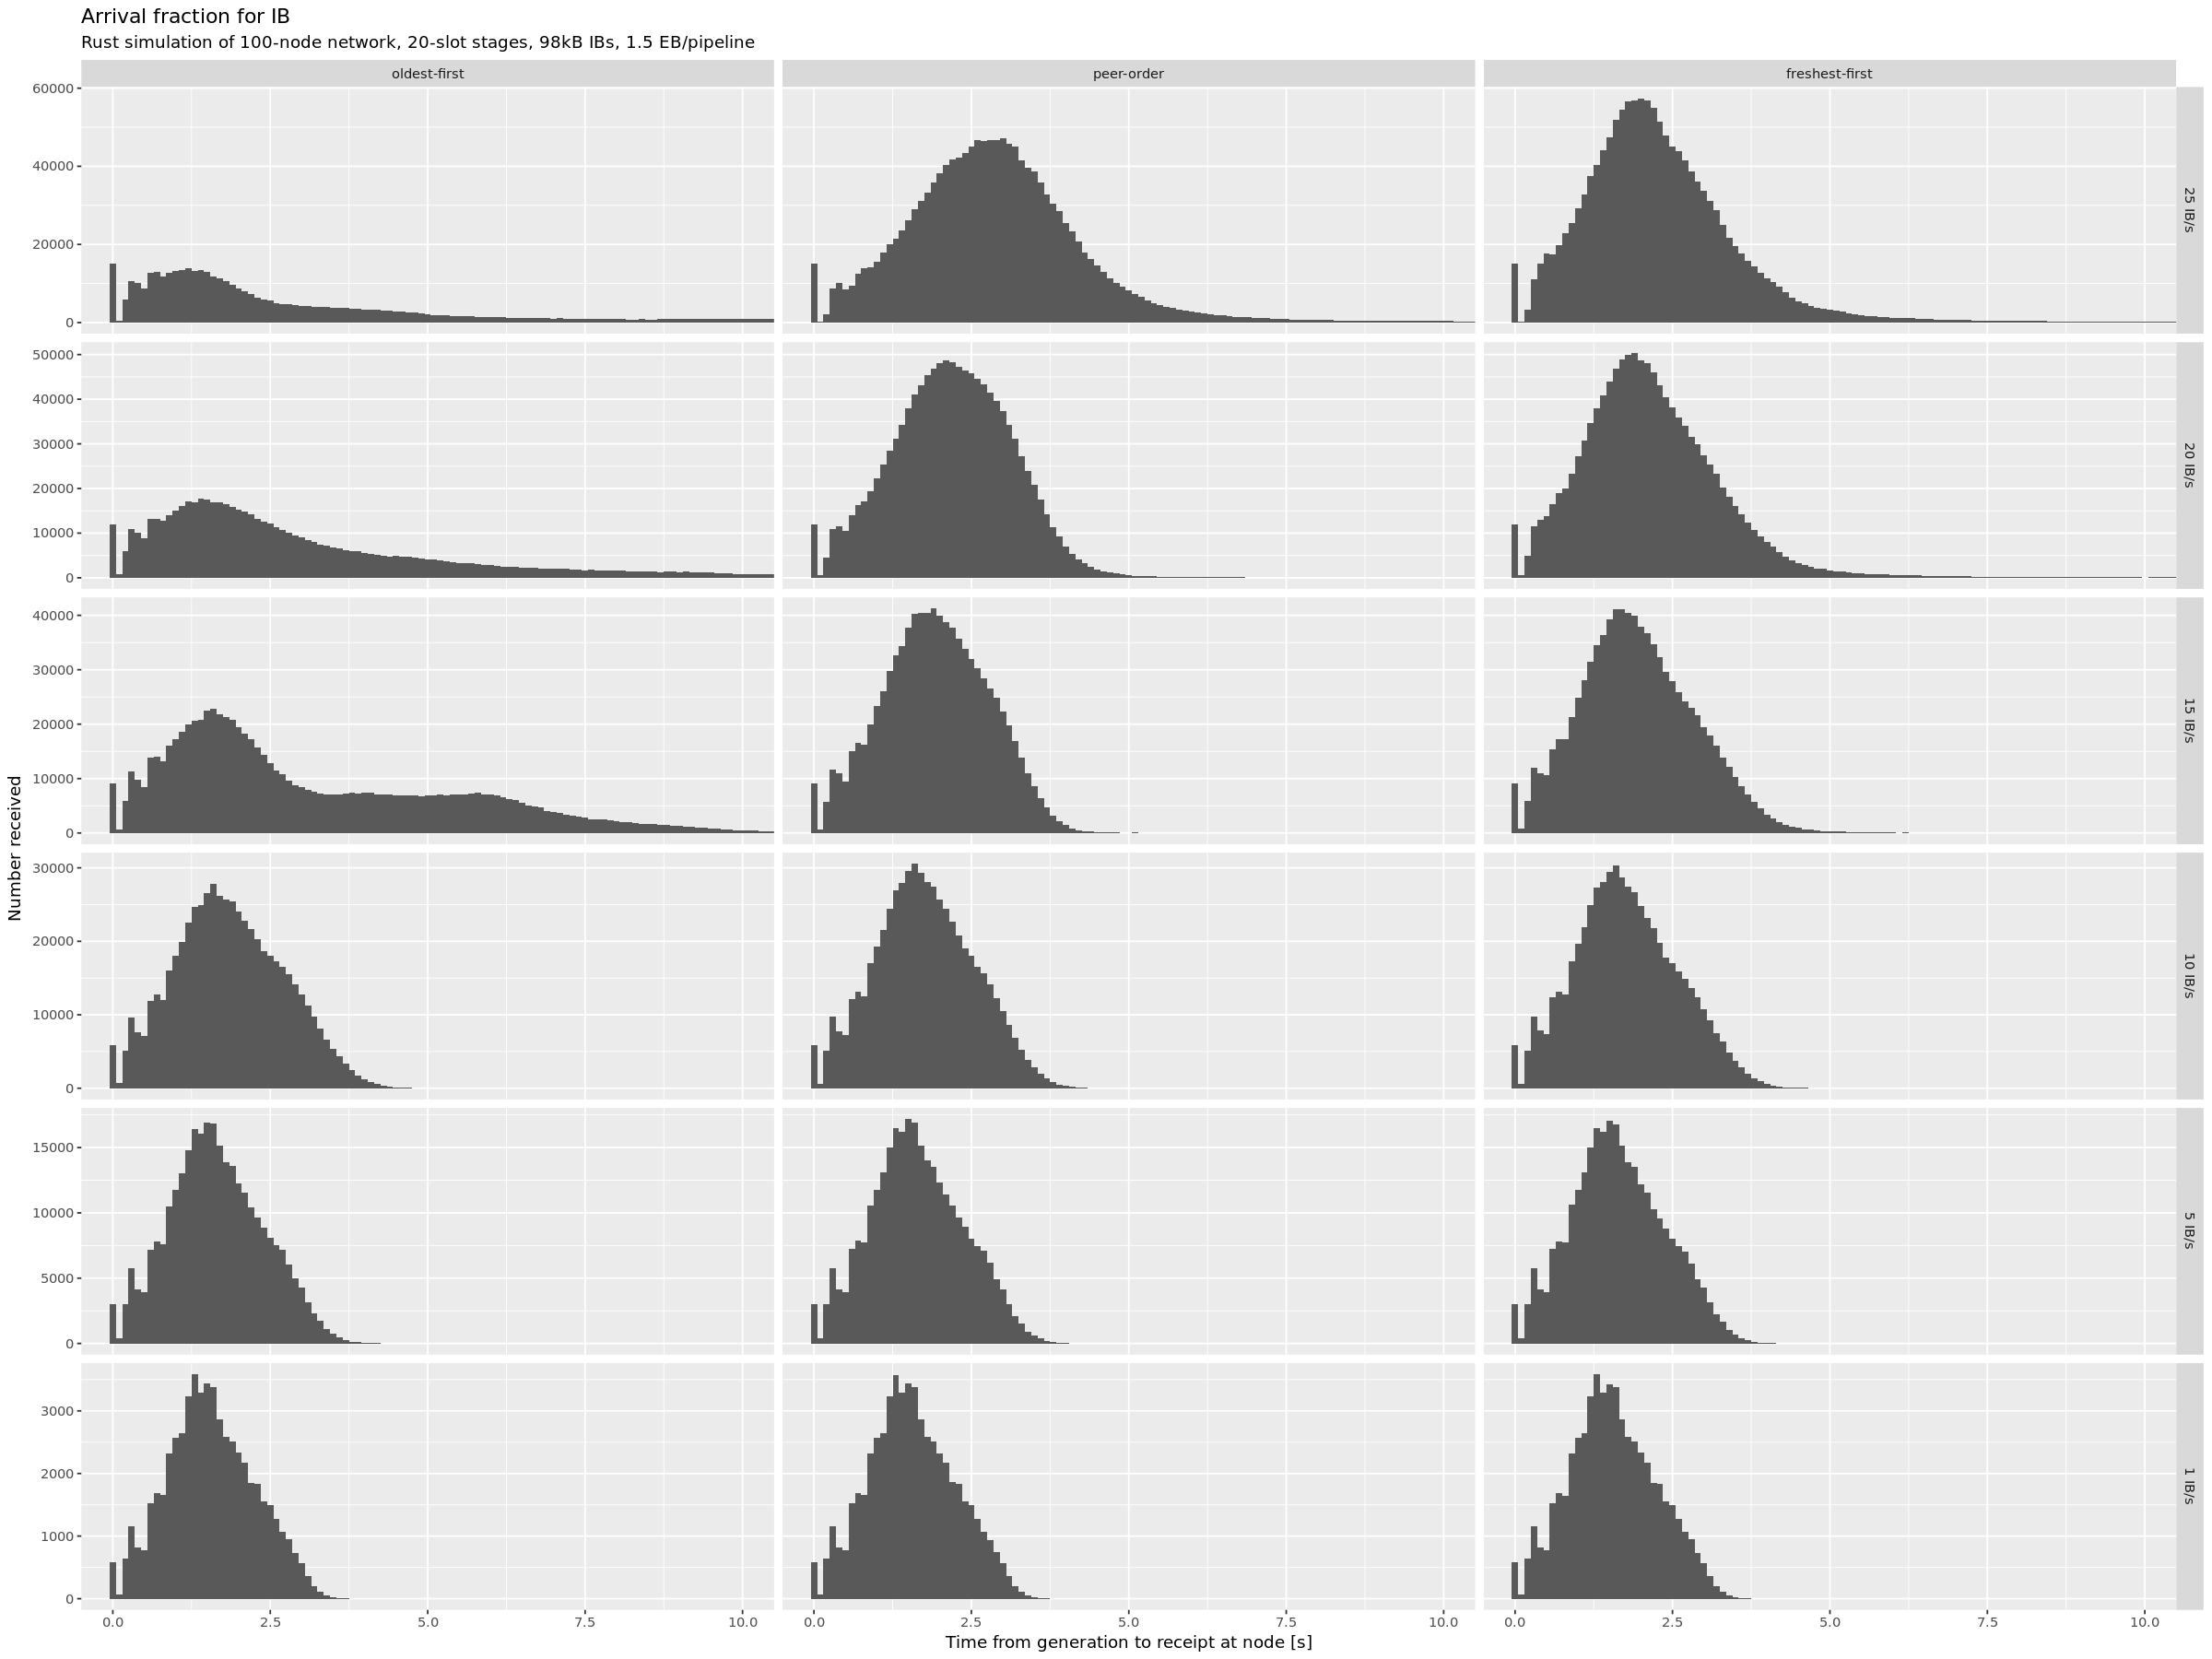

In [35]:
for (s in receiptOrdered[,unique(`simulator`)%>%sort]) {
    g <- ggplot(receiptOrdered[`simulator` == s], aes(x=`elapsed`)) +
        geom_histogram(binwidth=0.1) +
        coord_cartesian(xlim=c(0,10)) +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev) ~ `Ordering`, scales="free") +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle("Arrival fraction for IB", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 20-slot stages, 98kB IBs, 1.5 EB/pipeline"))
        print(g)
        ggsave(paste0("plots/receipt-ordered-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

In [36]:
arrivalOrdered <- receiptOrdered[
    !is.na(`received`) & `sent` <= 540,
    .(`received`=as.numeric(.N)),
    by=.(`simulator`, `Ordering`, `IB Rate`, `sent`, `item`)
][,
    .(`total`=as.numeric(.N), `received`=sum(`received`)),
    by=.(`simulator`, `Ordering`, `IB Rate`, `sent`)
][,
    .(`received`=sum(`received`)/sum(`total`)),
    by=.(`simulator`, `Ordering`, `IB Rate`, `sent`)
]

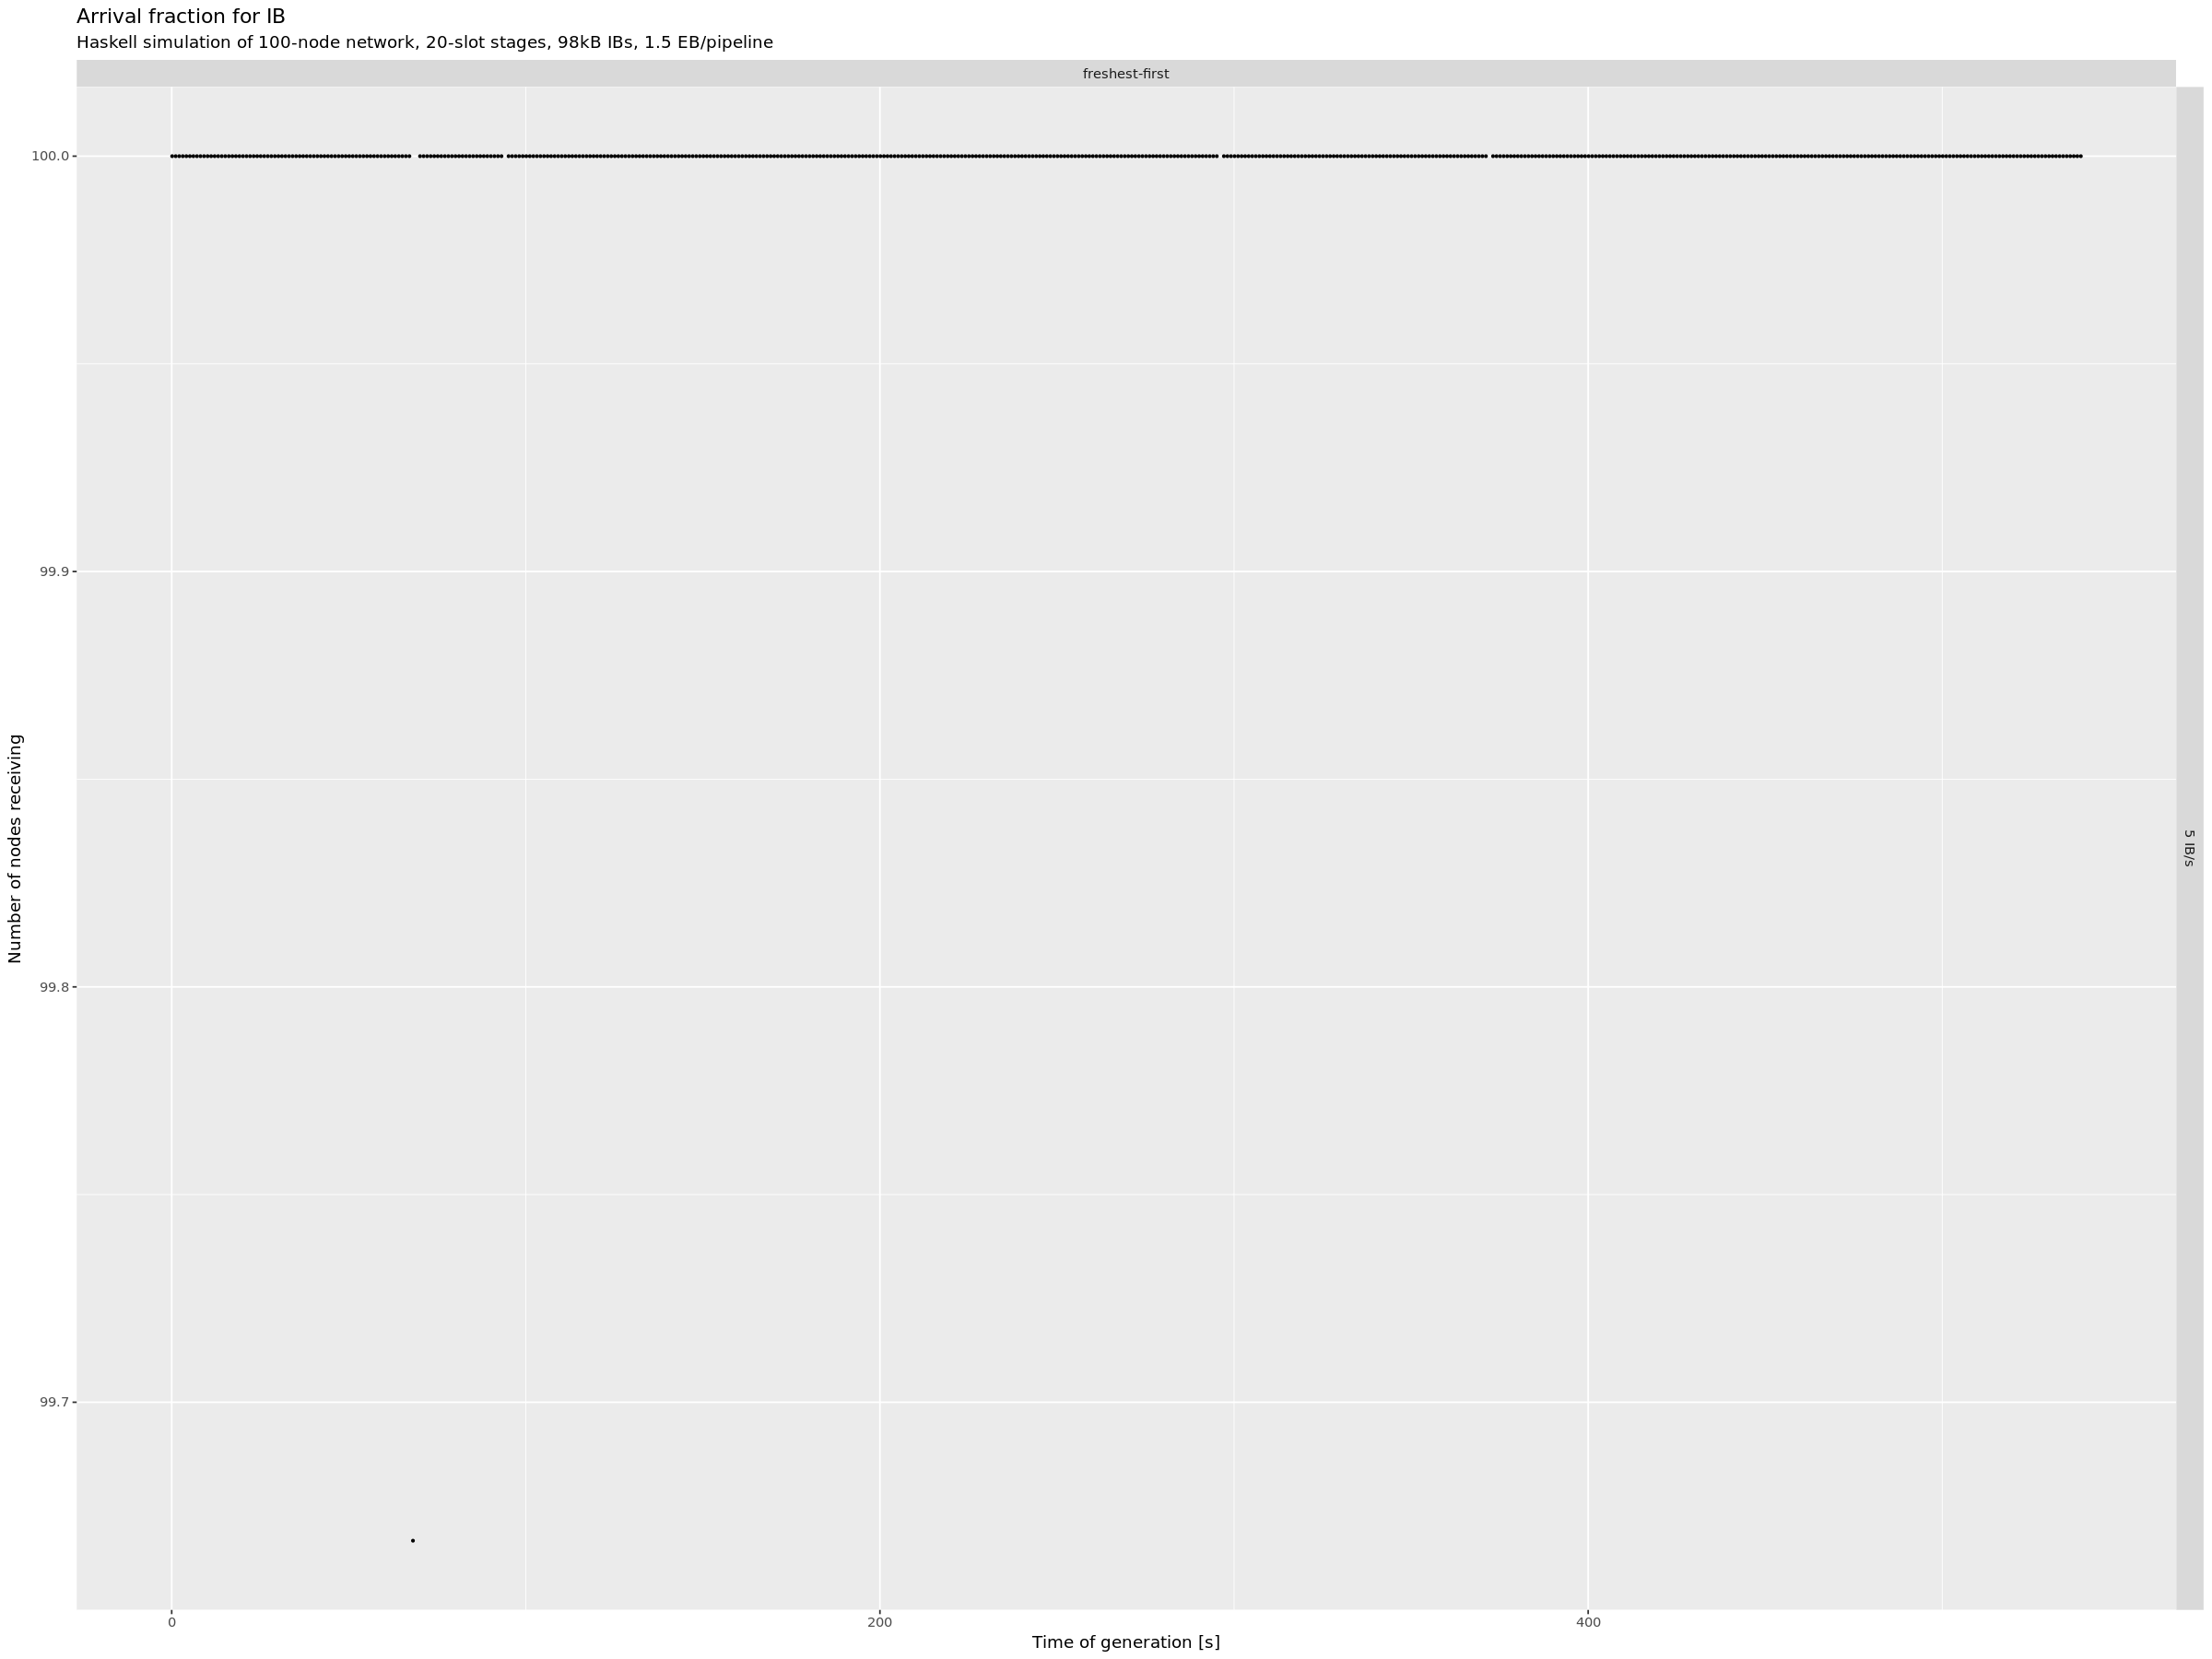

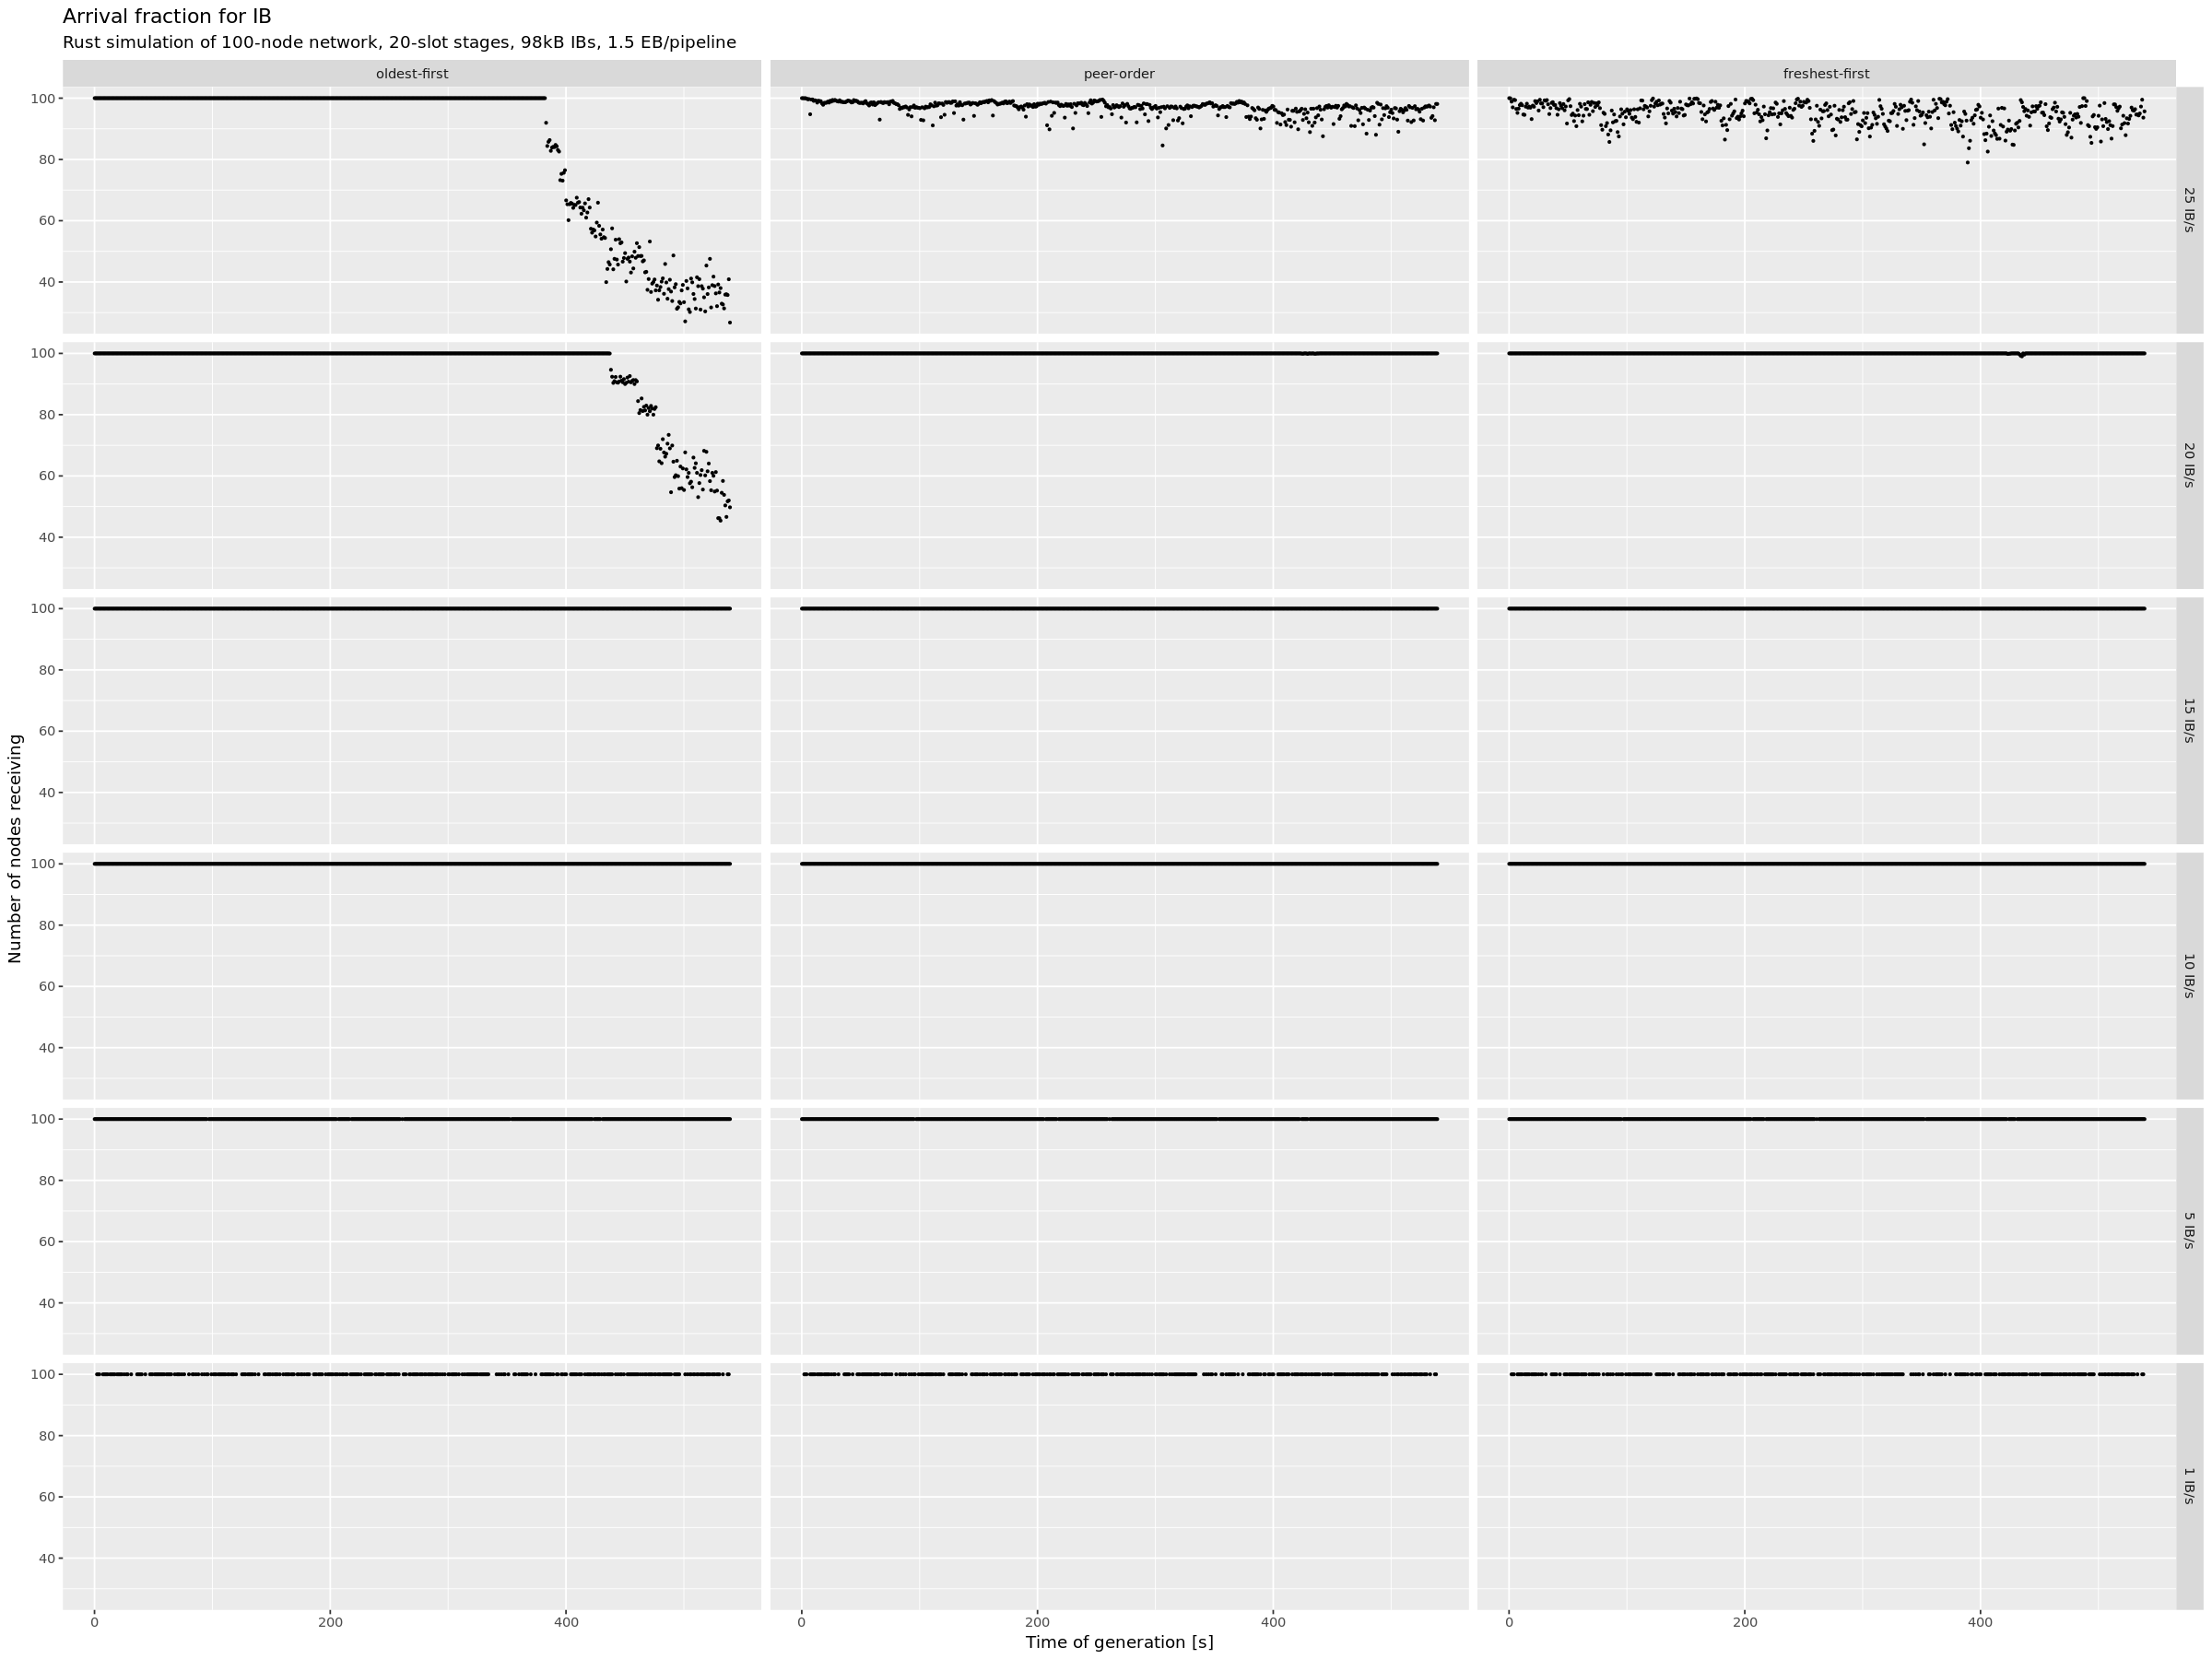

In [37]:
for (s in arrivalOrdered[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        arrivalOrdered[`simulator` == s], 
        aes(x=`sent`, y=`received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev)  ~ `Ordering`) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle("Arrival fraction for IB", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 20-slot stages, 98kB IBs, 1.5 EB/pipeline"))
    print(g)
    ggsave(paste0("plots/arrival-ordered-IB-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

## Effect of extended voting

In [38]:
extendedCase <- function(label) {
    labelLevels <- c("Without extended voting", "With extended voting")
    if (label == "default")
        factor("Without extended voting", levels=labelLevels)
    else if (label == "extended-voting")
        factor("With extended voting", levels=labelLevels)
    else
        null
}    

In [39]:
receiptExtended <- receipts[
    `label` %in% c("default", "extended-voting") &
    `network` == "100-nodes" &
    `ib-body-avg-size-bytes` == 98304 &
    `eb-generation-probability` == 1.5 &
    `leios-stage-length-slots` == 20 &
    `kind` == "VT",
    .(
        `simulator`,
        `Extended`=mapply(extendedCase, `label`),
        `IB Rate`=mapply(ibRate, `ib-generation-probability`),
        `elapsed`,
        `item`,
        `sent`,
        `received`
    )
]
receiptExtended %>% summary

   simulator                         Extended         IB Rate      
 haskell:252819   Without extended voting:476319   1 IB/s : 81200  
 rust   :447000   With extended voting   :223500   5 IB/s :334019  
                                                   10 IB/s: 82400  
                                                   15 IB/s: 78200  
                                                   20 IB/s: 82600  
                                                   25 IB/s: 41400  
                                                                   
    elapsed                item             sent        received     
 Min.   :0.0000   20-node-22 :   600   Min.   : 20   Min.   : 20.00  
 1st Qu.:0.5439   47-node-46 :   600   1st Qu.: 49   1st Qu.: 49.99  
 Median :0.8714   500-node-17:   600   Median : 93   Median : 93.60  
 Mean   :0.9327   68-node-86 :   600   Mean   :197   Mean   :197.98  
 3rd Qu.:1.2836   72-node-7  :   600   3rd Qu.:346   3rd Qu.:347.40  
 Max.   :5.7927   77-node-80 :   600

In [40]:
receiptExtended[,
    .(`Mean time from generation to receipt at node [s]`=mean(`elapsed`, na.rm=TRUE)),
    by=.(`simulator`, `Extended`)
]

simulator,Extended,Mean time from generation to receipt at node [s]
<fct>,<fct>,<dbl>
rust,Without extended voting,0.885220
rust,With extended voting,0.885220
haskell,Without extended voting,1.016549


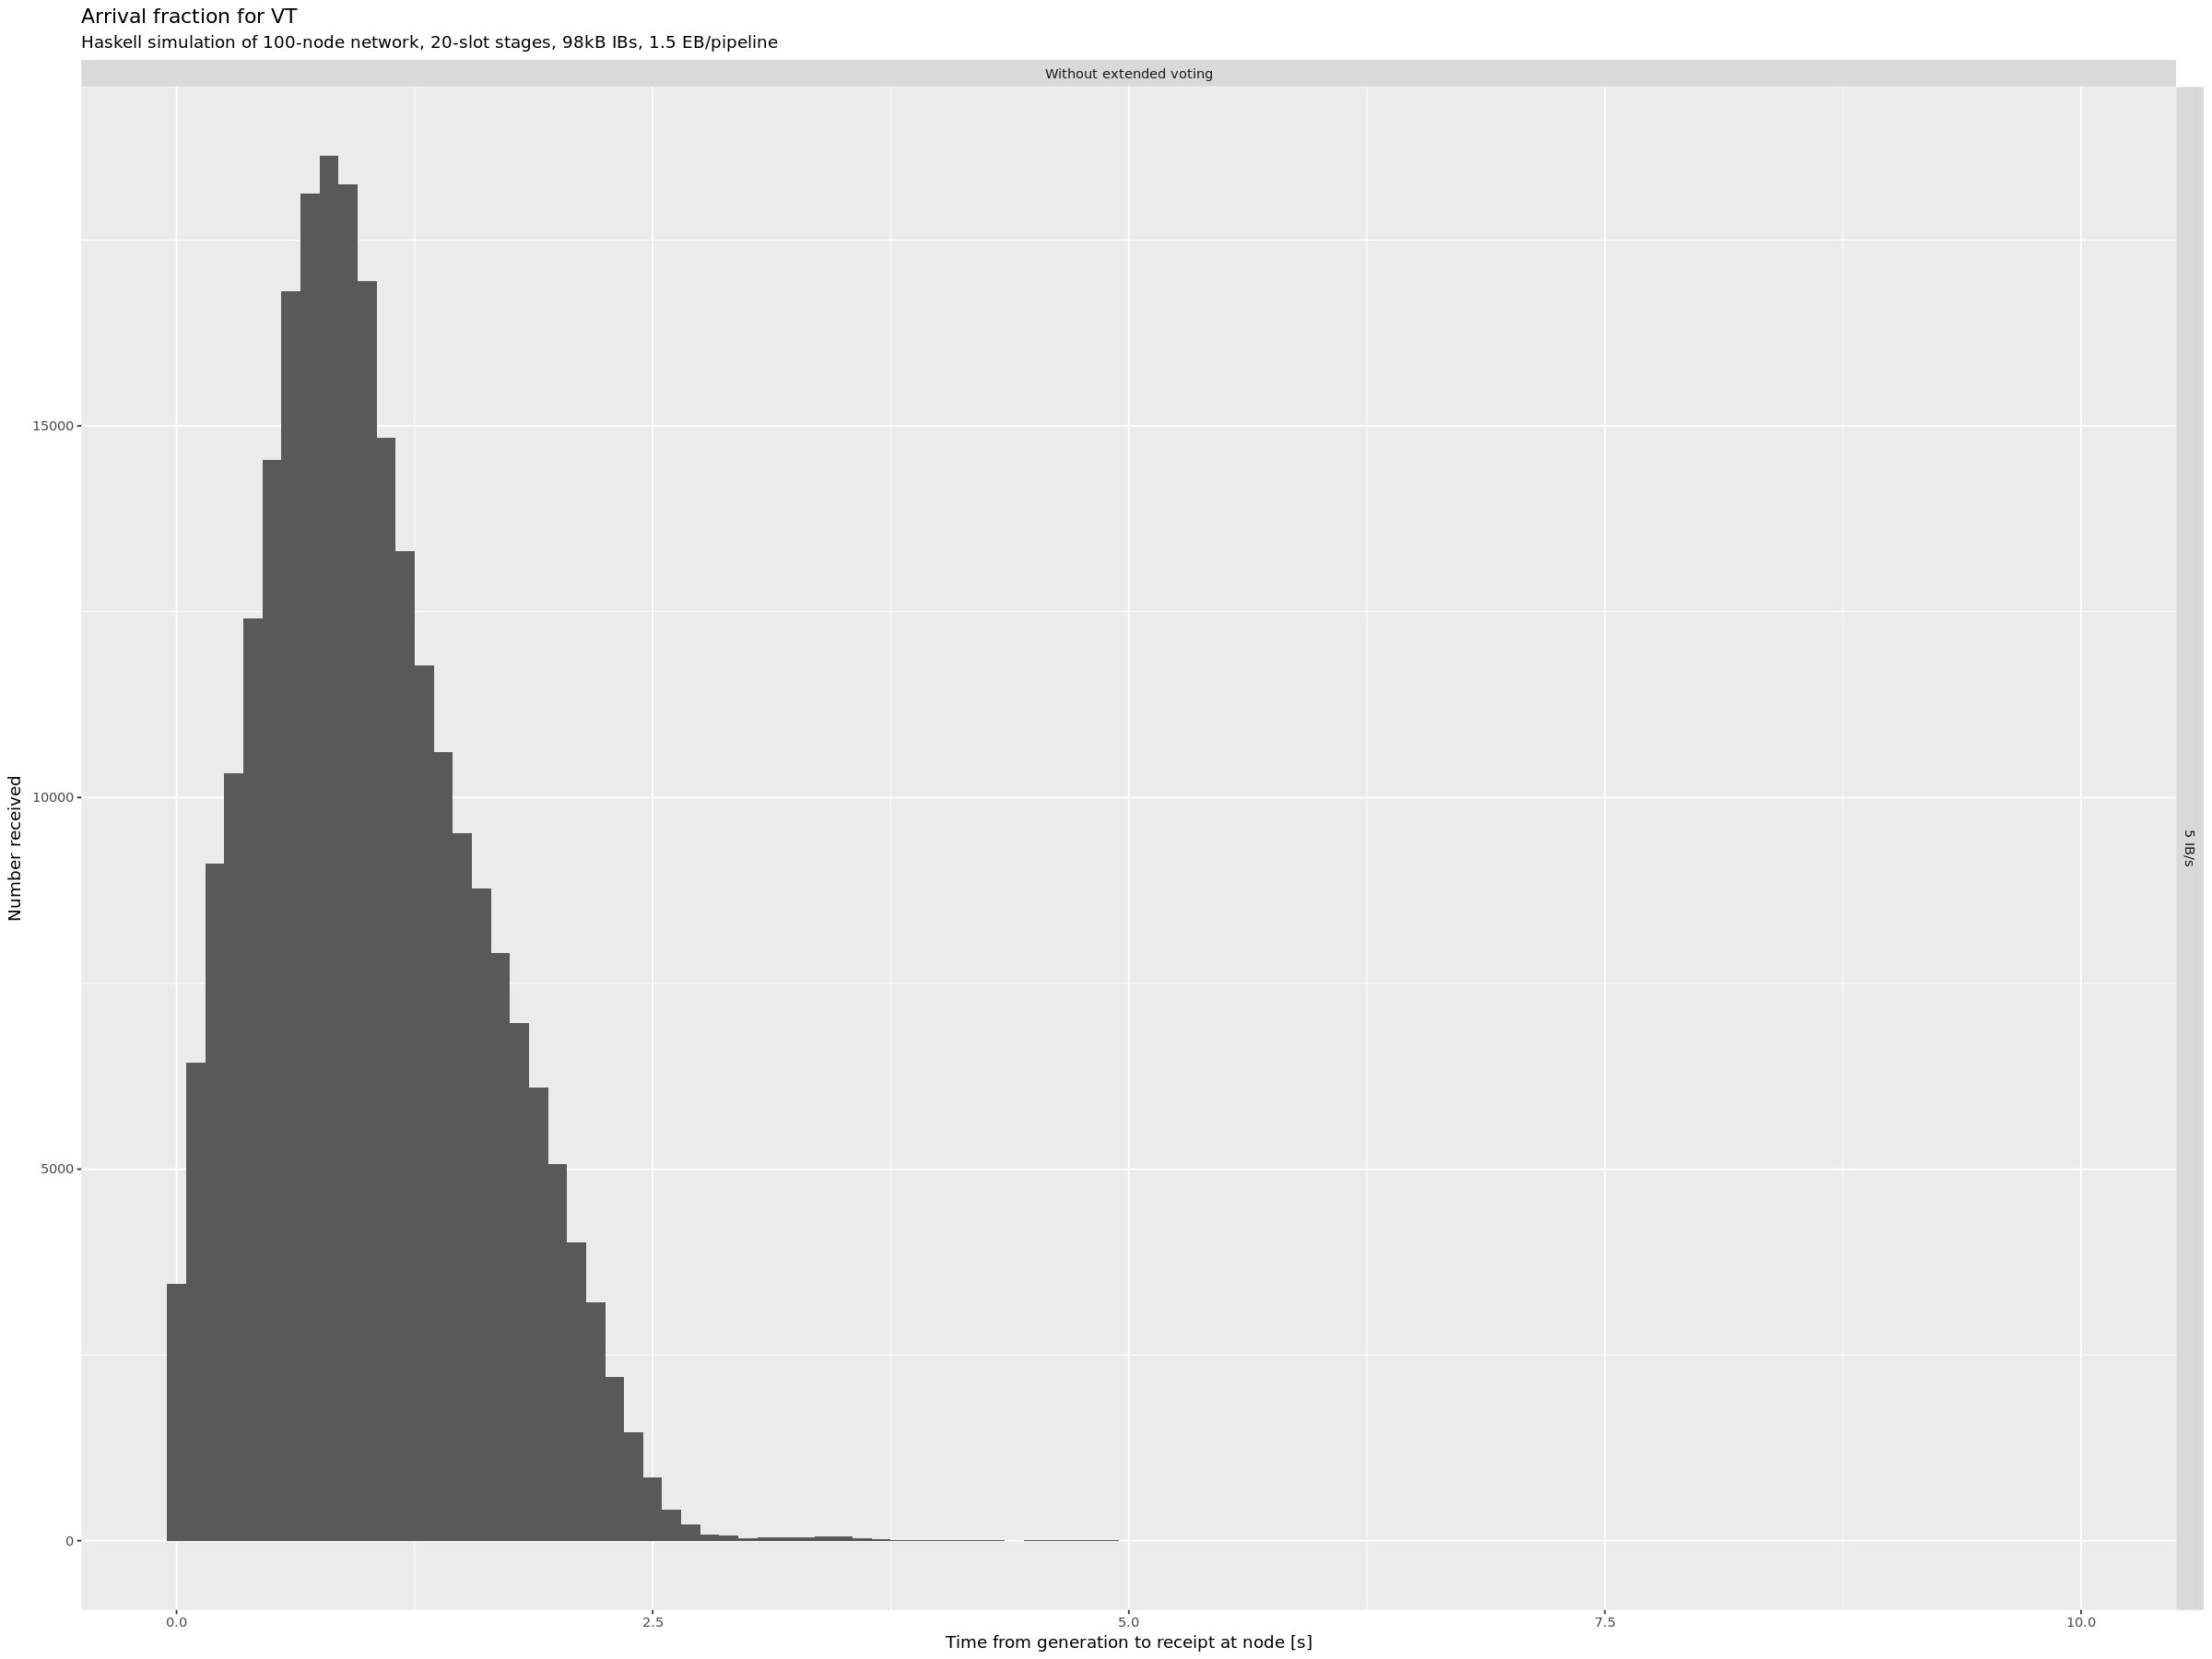

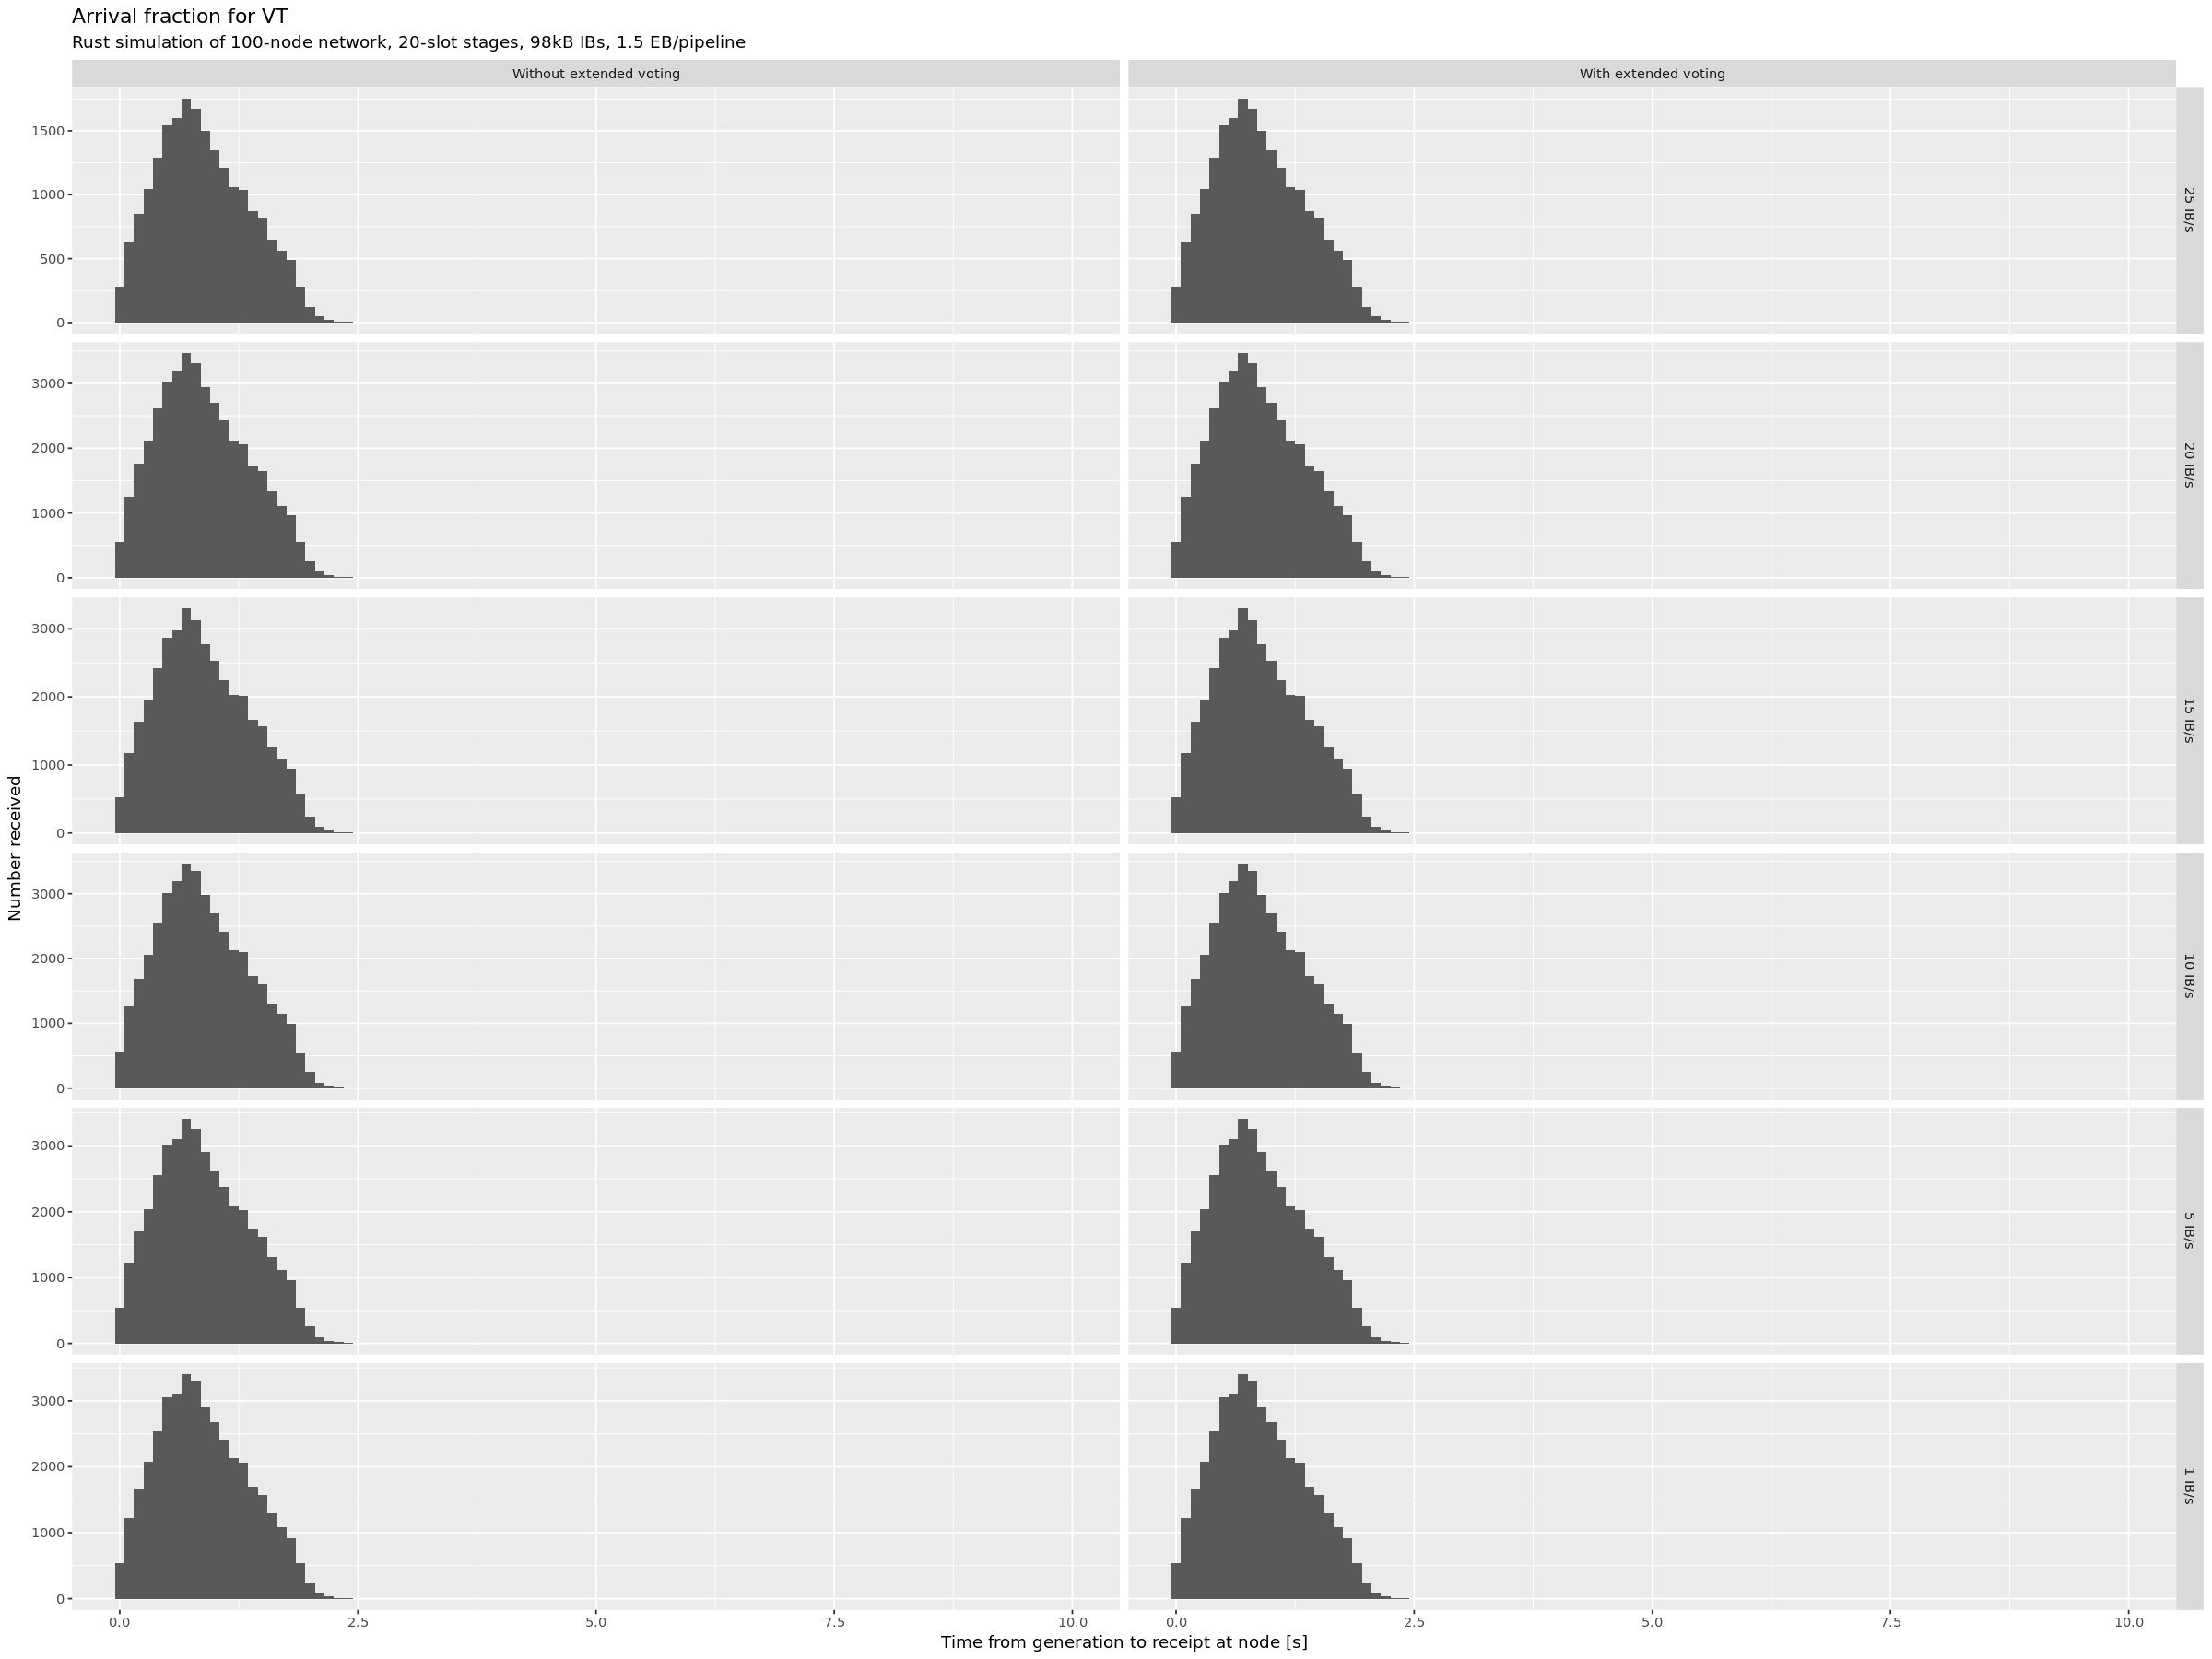

In [41]:
for (s in receiptExtended[,unique(`simulator`)%>%sort]) {
    g <- ggplot(receiptExtended[`simulator` == s & !is.na(`elapsed`)], aes(x=`elapsed`)) +
        geom_histogram(binwidth=0.1) +
        coord_cartesian(xlim=c(0,10)) +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev) ~ `Extended`, scales="free") +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle("Arrival fraction for VT", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 20-slot stages, 98kB IBs, 1.5 EB/pipeline"))
        print(g)
        ggsave(paste0("plots/receipt-ordered-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

In [42]:
arrivalExtended <- receiptExtended[
    !is.na(`received`) & `sent` <= 540,
    .(`received`=as.numeric(.N)),
    by=.(`simulator`, `Extended`, `IB Rate`, `sent`, `item`)
][,
    .(`total`=as.numeric(.N), `received`=sum(`received`)),
    by=.(`simulator`, `Extended`, `IB Rate`, `sent`)
][,
    .(`received`=sum(`received`)/sum(`total`)),
    by=.(`simulator`, `Extended`, `IB Rate`, `sent`)
]

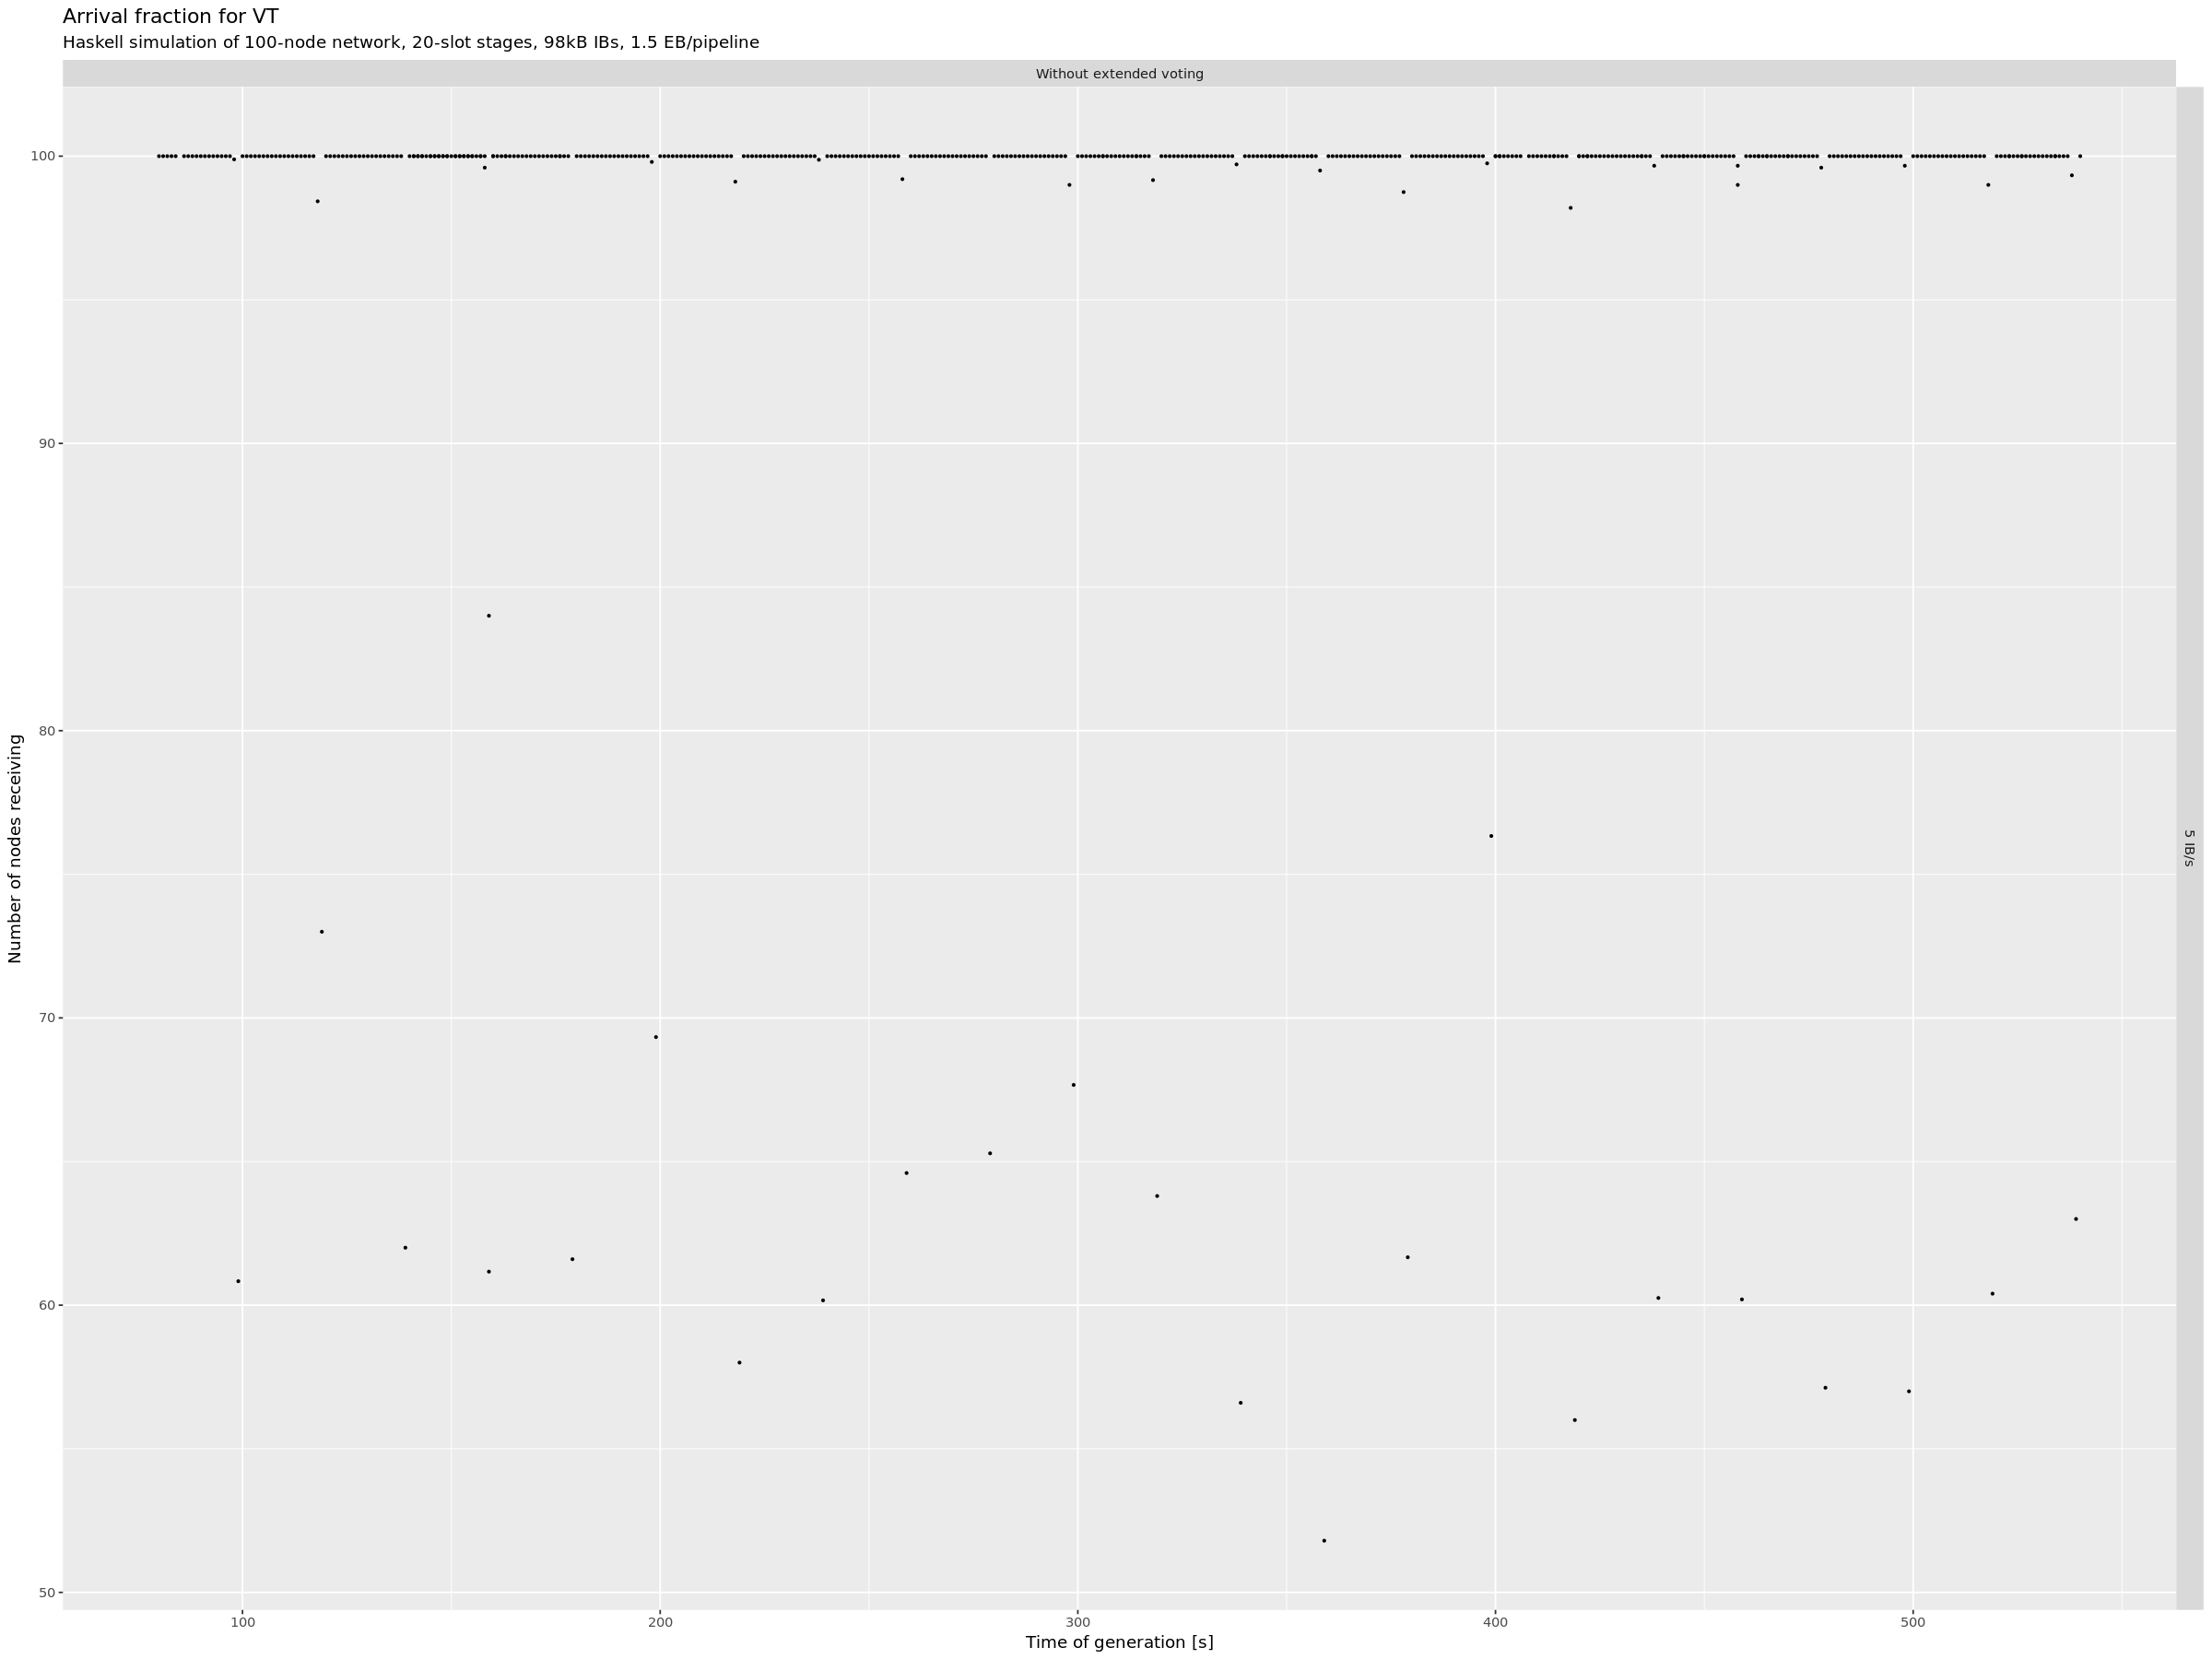

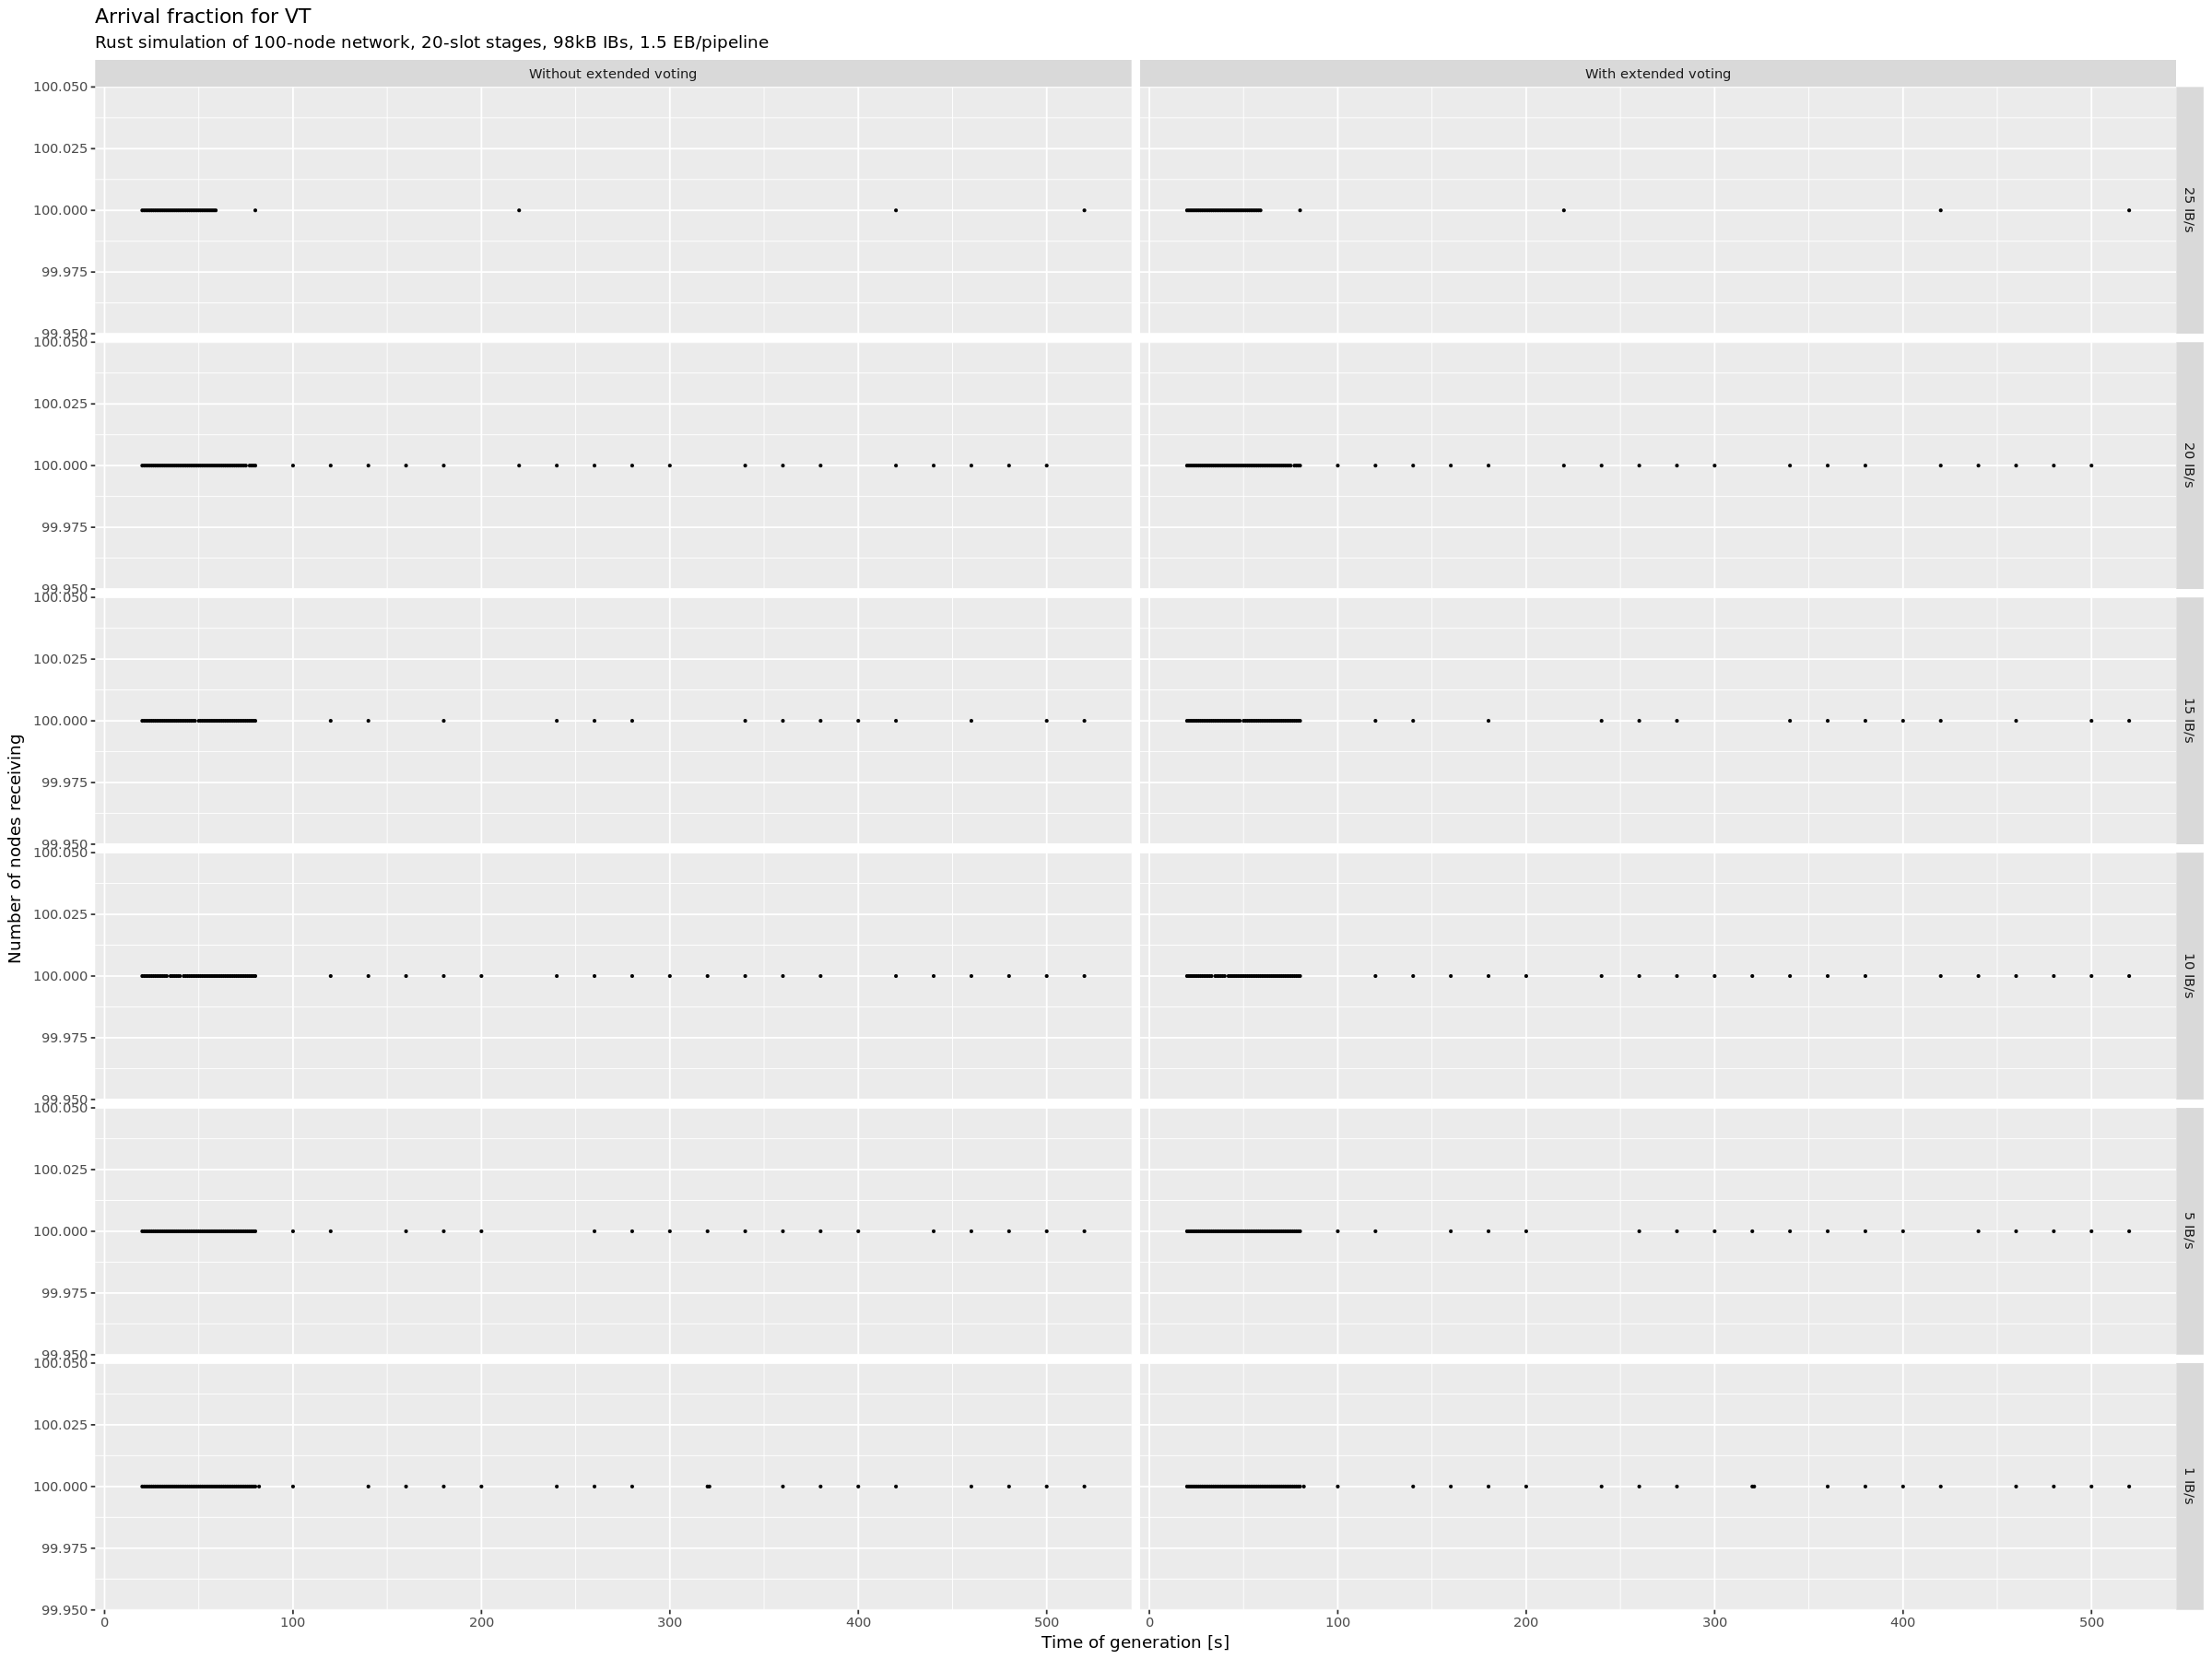

In [43]:
for (s in arrivalExtended[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        arrivalExtended[`simulator` == s], 
        aes(x=`sent`, y=`received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(factor(`IB Rate`, levels=levels(`IB Rate`)%>%rev)  ~ `Extended`) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle("Arrival fraction for VT", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 20-slot stages, 98kB IBs, 1.5 EB/pipeline"))
    print(g)
    ggsave(paste0("plots/arrival-extended-VT-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

## General diagnostics

#### Compare the distributions of elapsed times

In [44]:
receiptScenario <- receipts[
    order(`simulator`, `label`, `network`, `leios-stage-length-slots`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `eb-generation-probability`)
][
    !is.na(`elapsed`),
    .(`elapsed`),
    .(
        `simulator`,
        `scenario`=paste(`label`, `network`, `leios-stage-length-slots`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `eb-generation-probability`, sep=" | "),
        `kind`
    )
]

In [45]:
options(repr.plot.width=20, repr.plot.height=15)

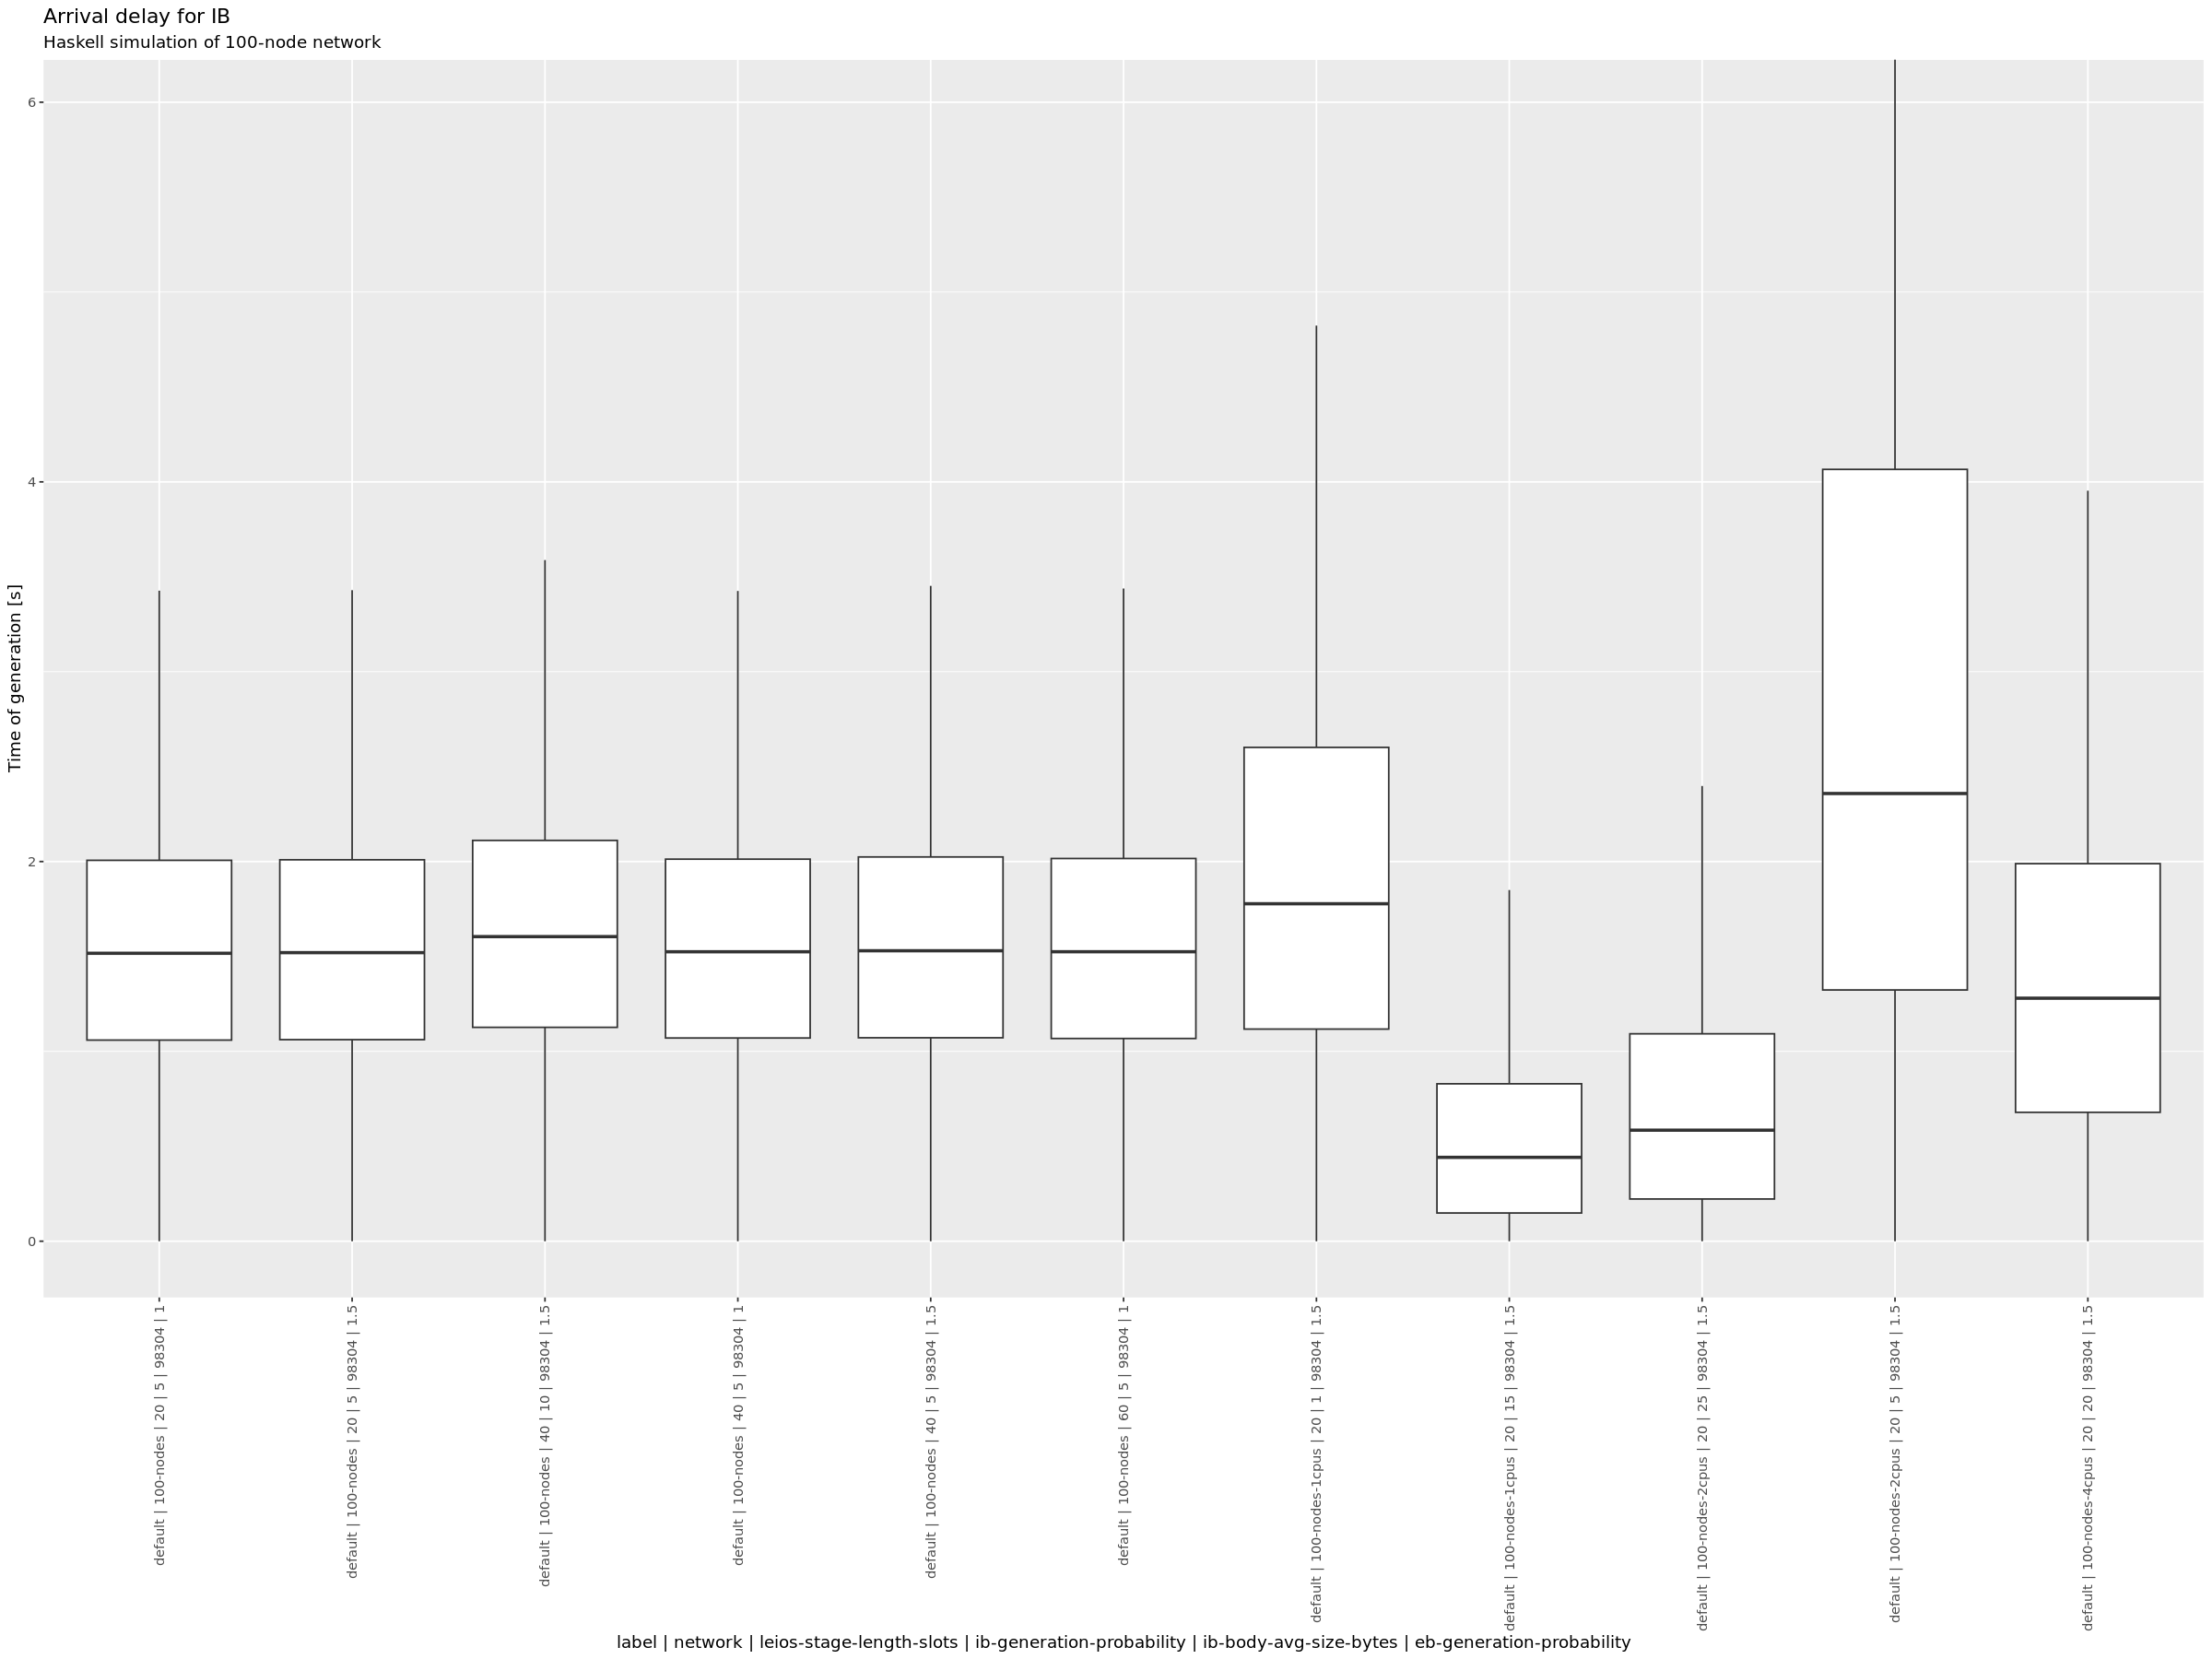

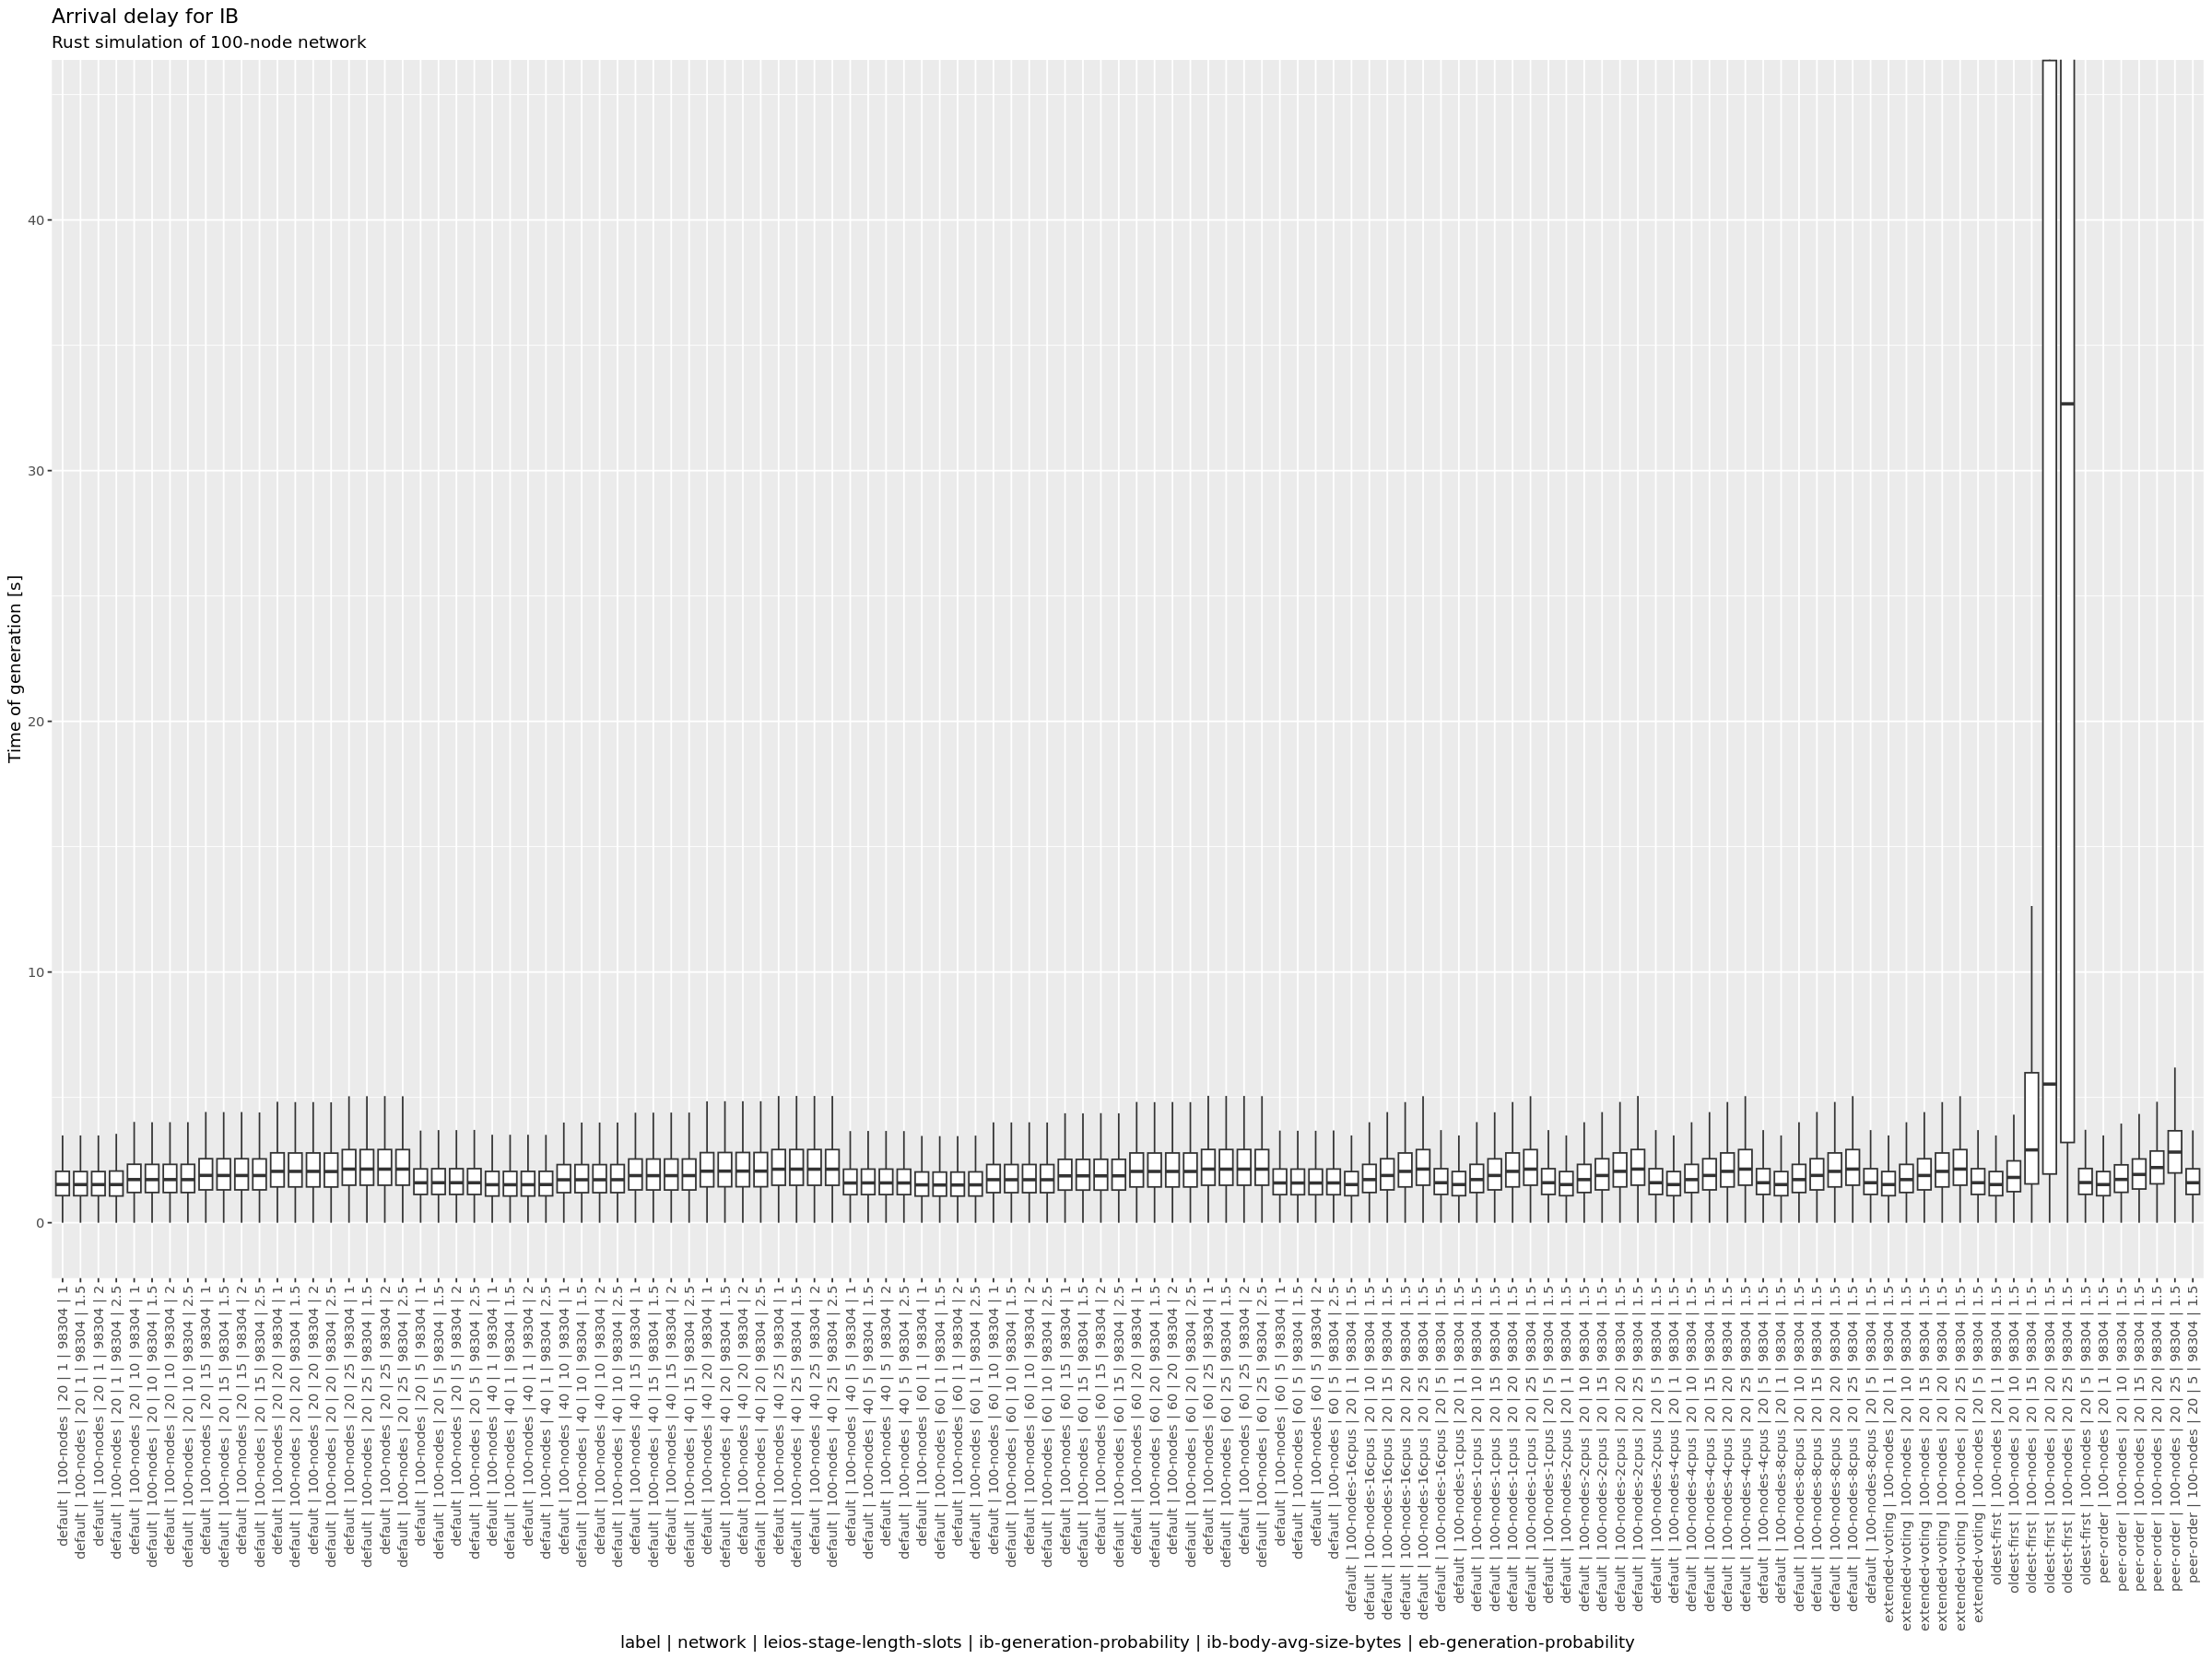

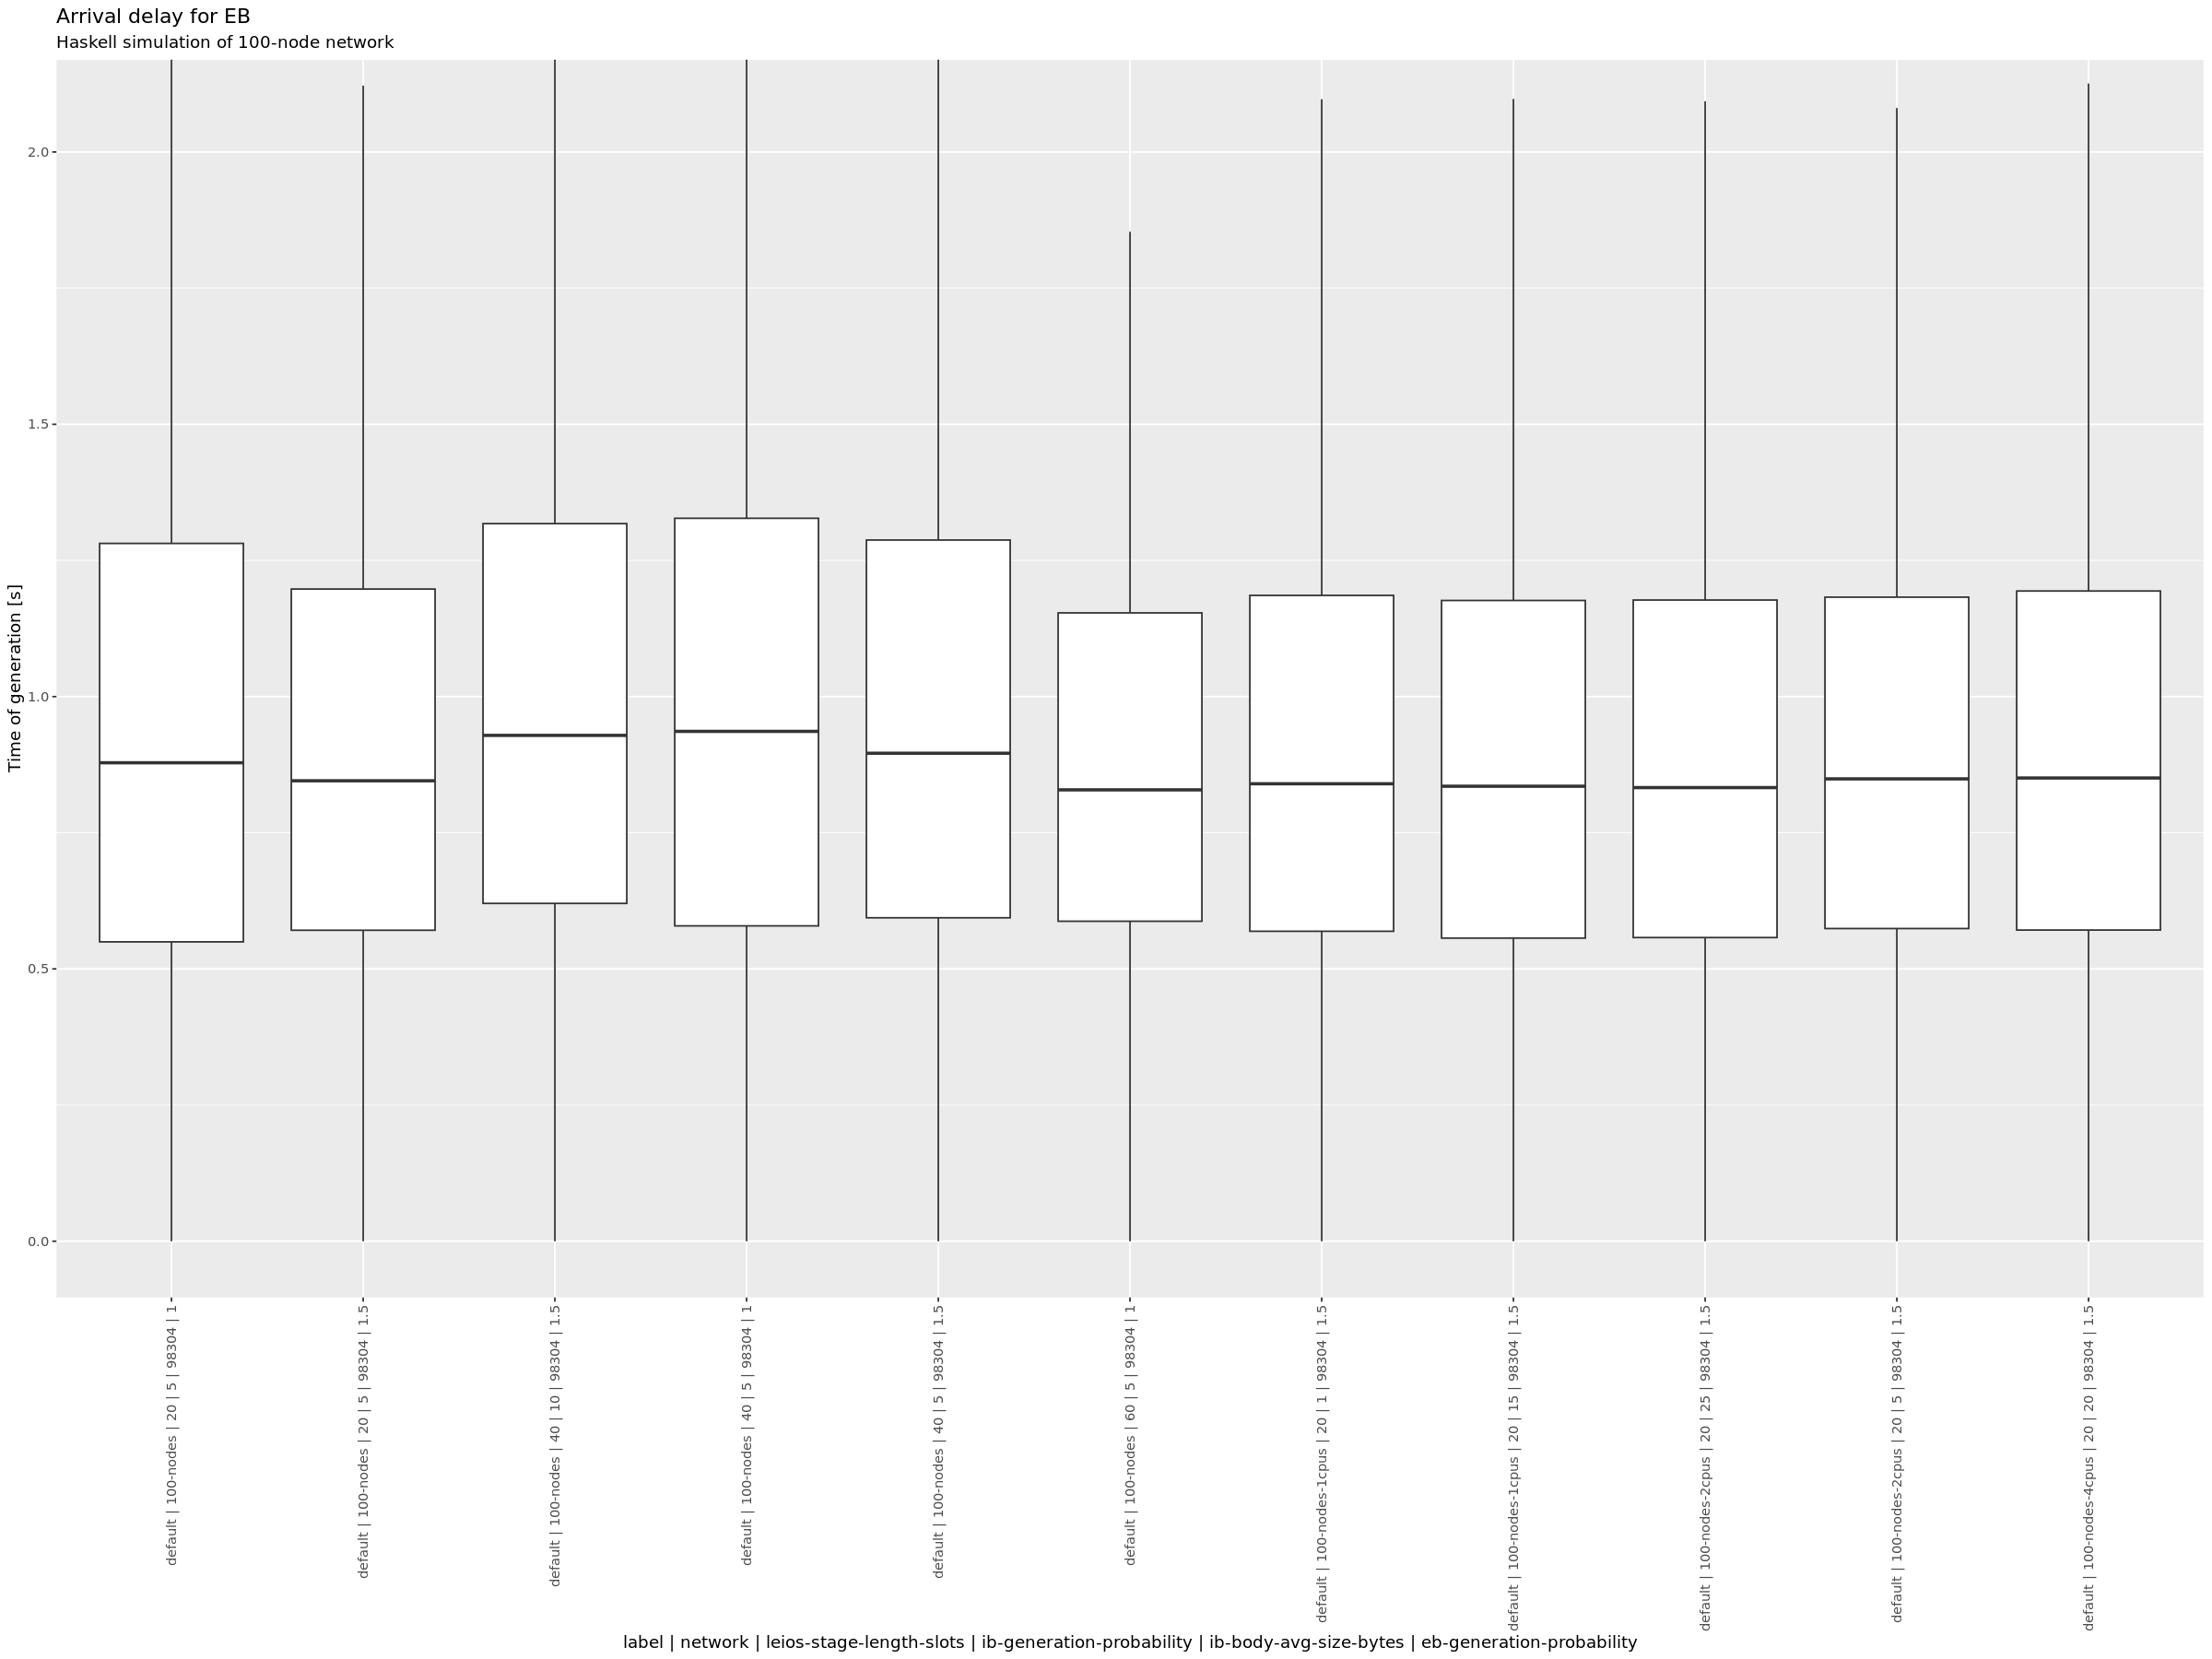

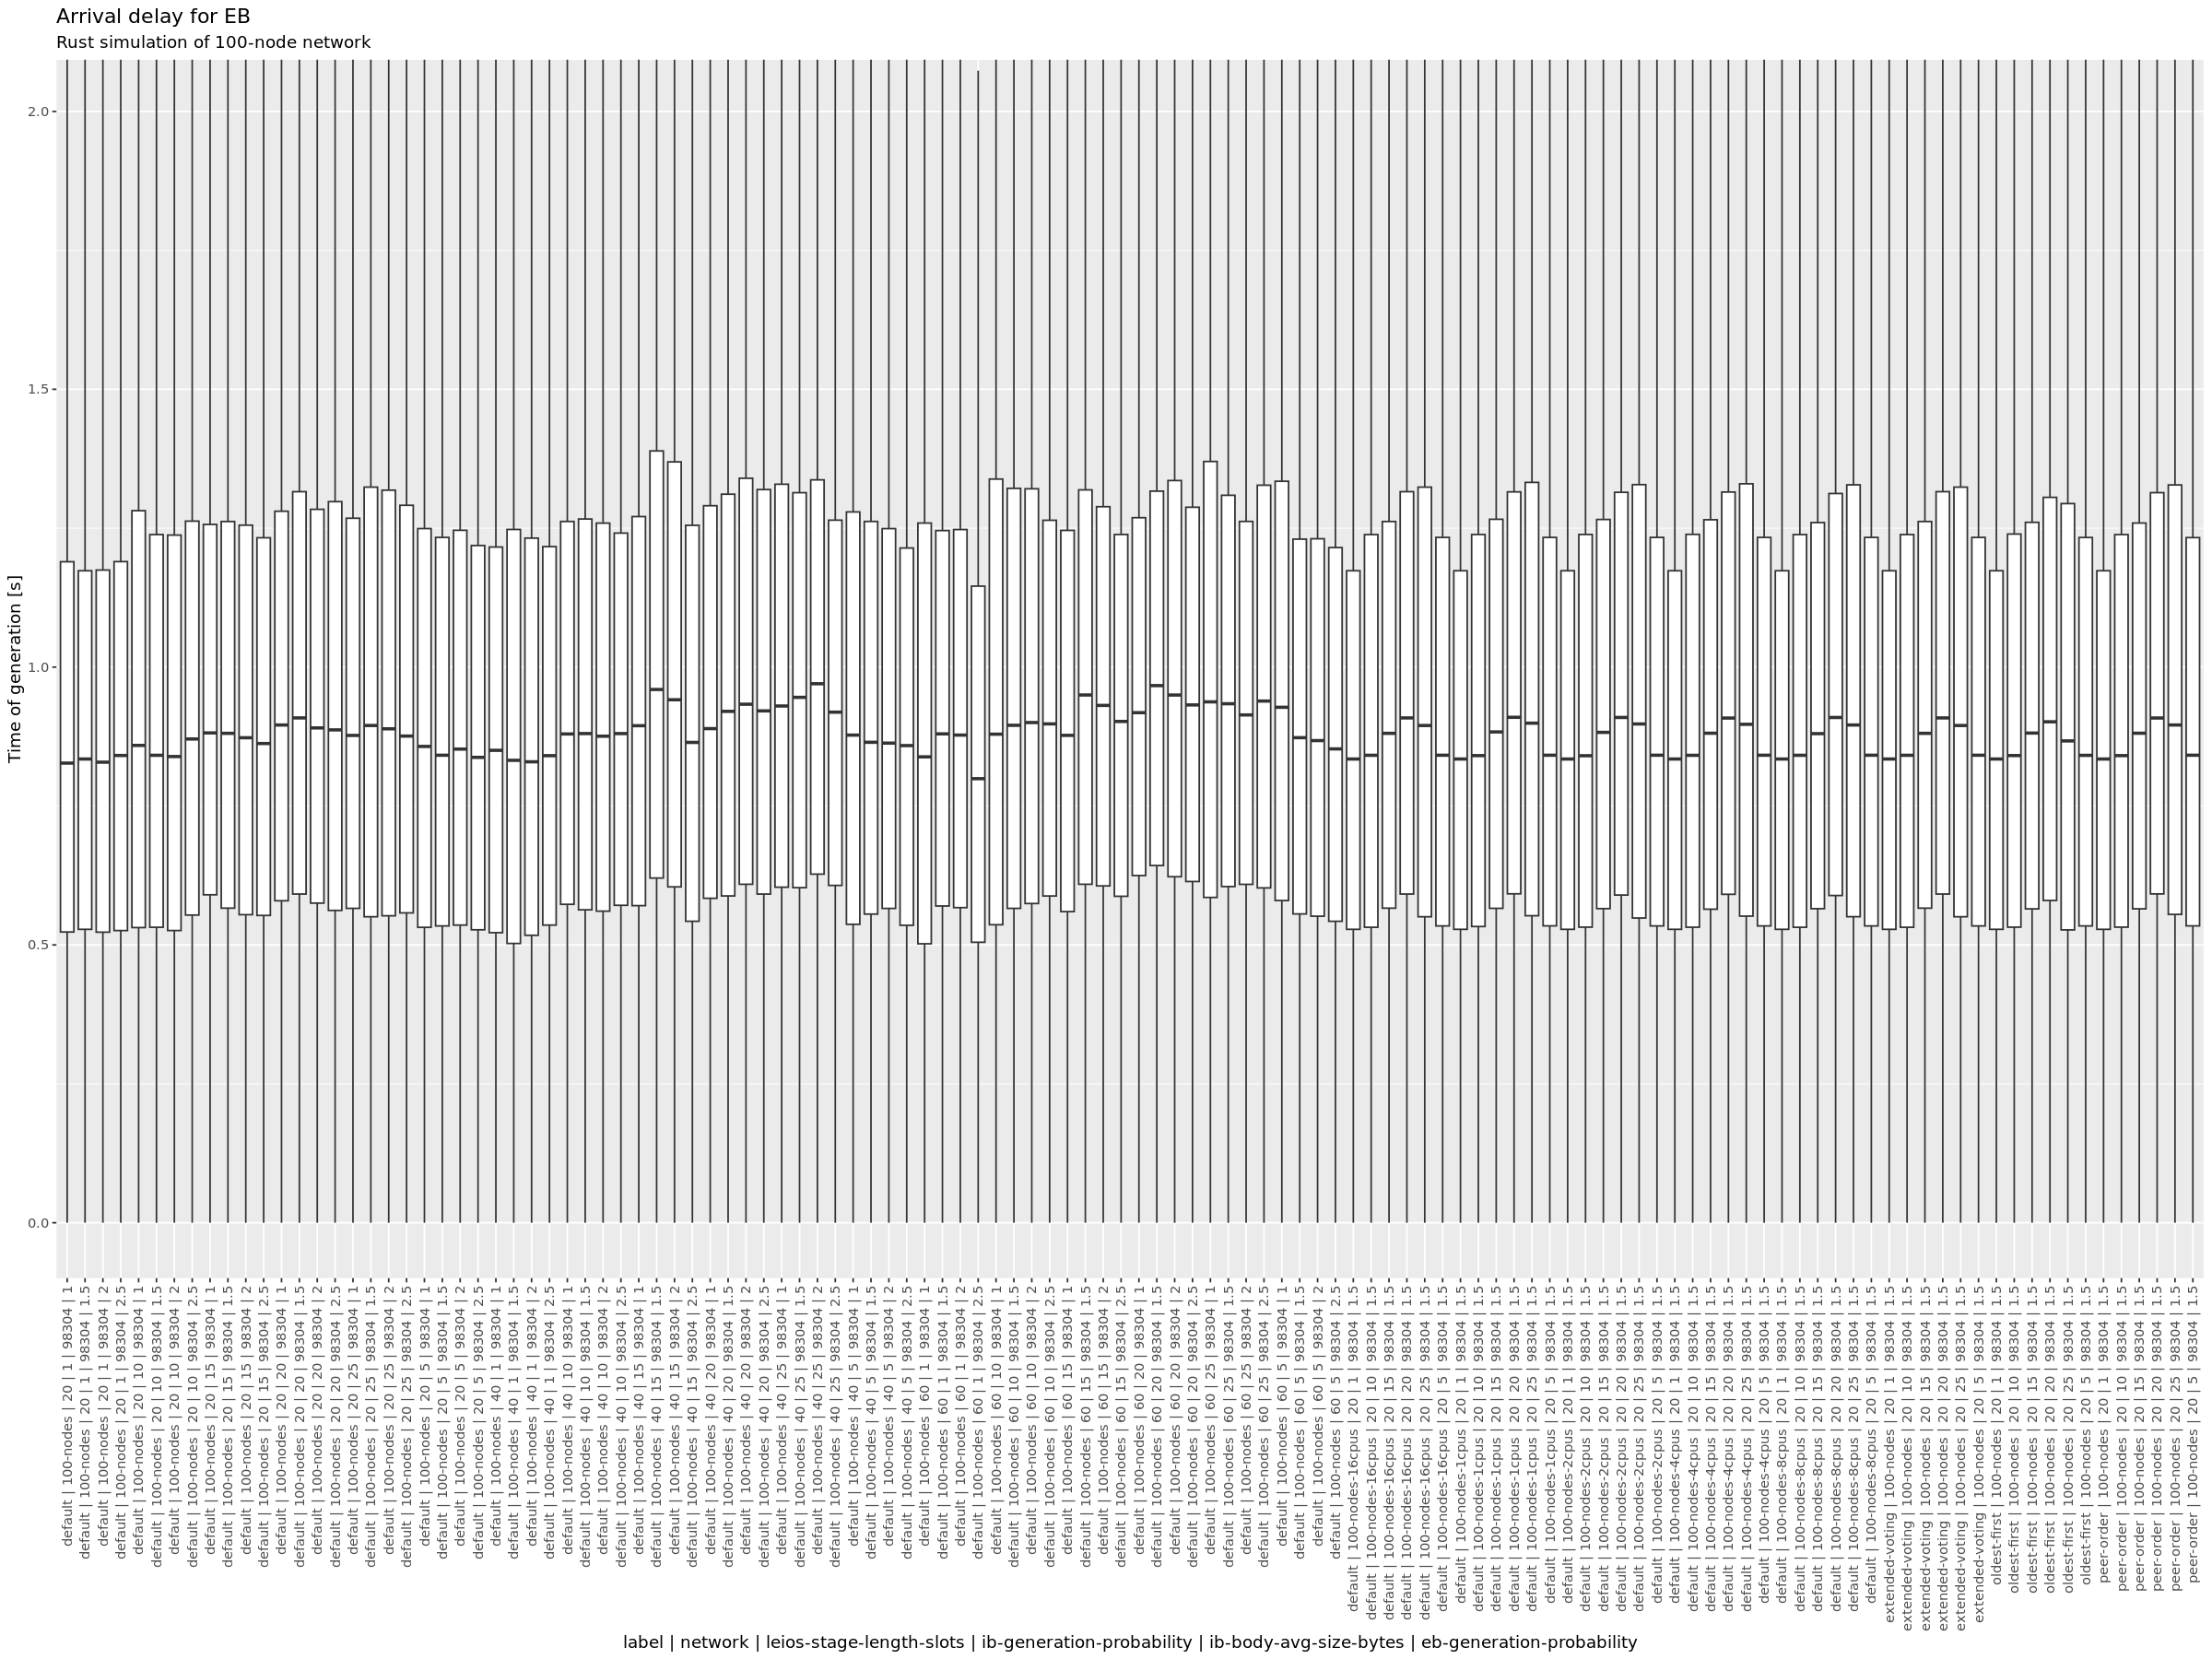

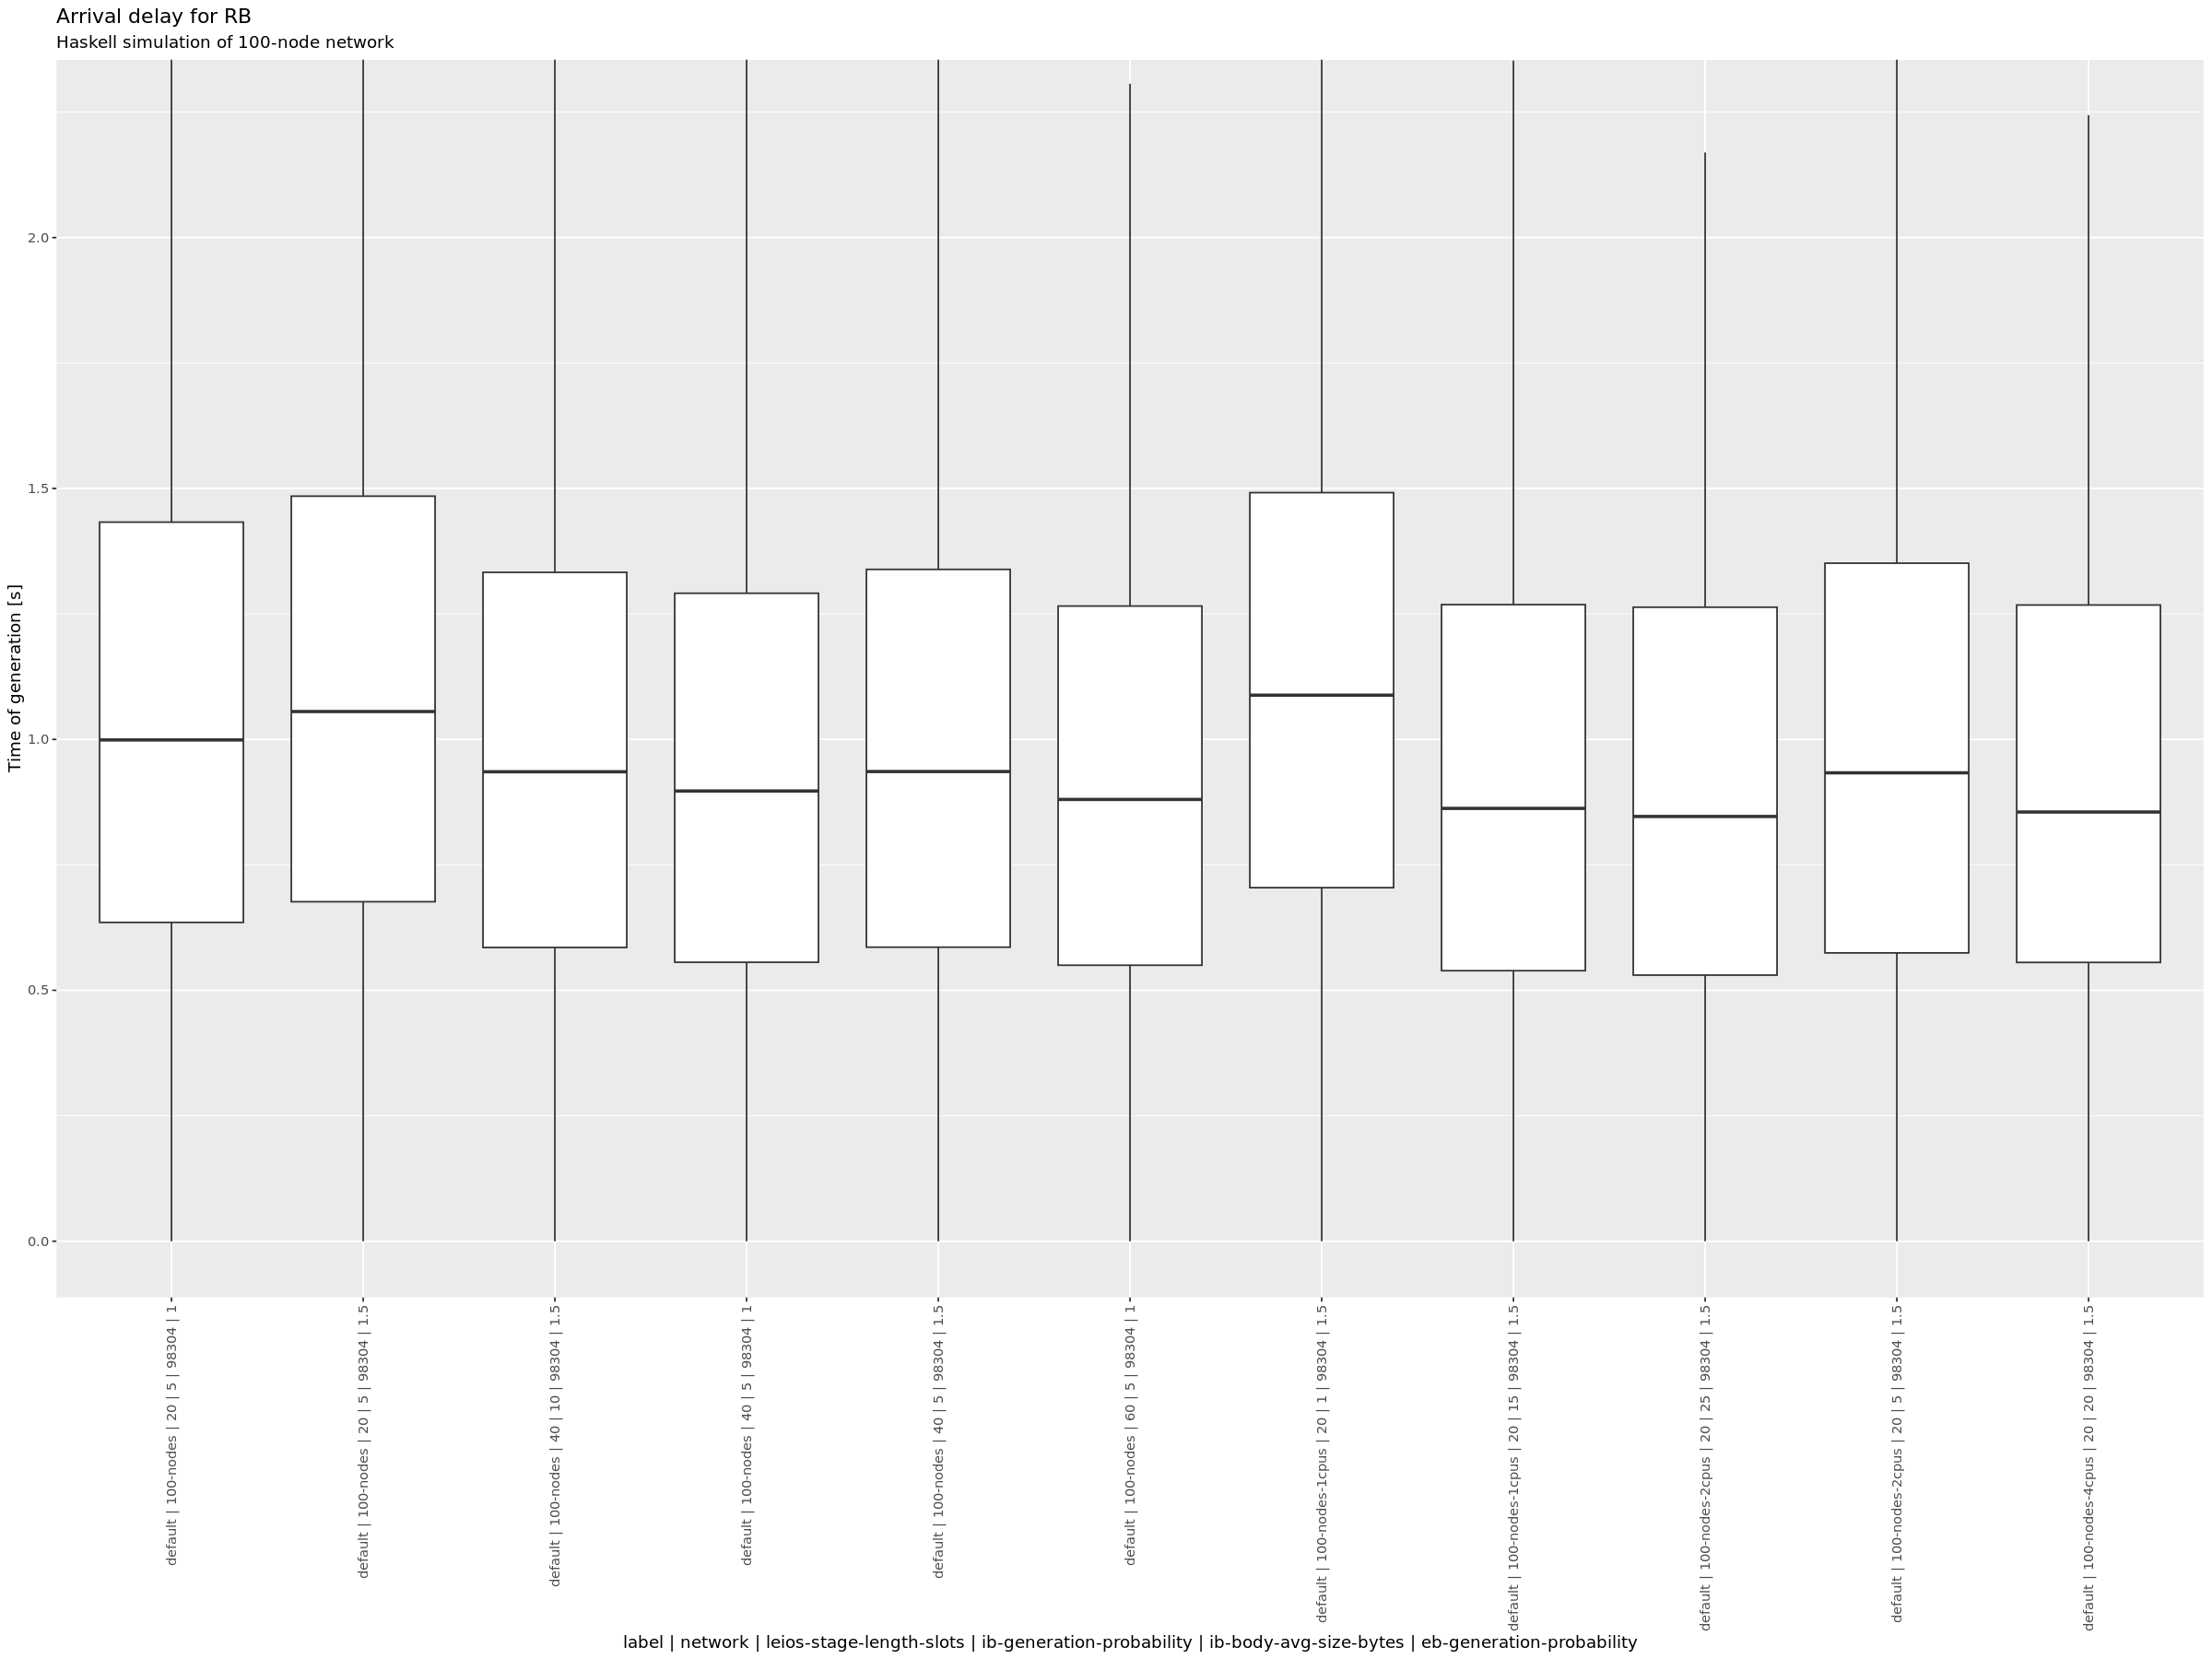

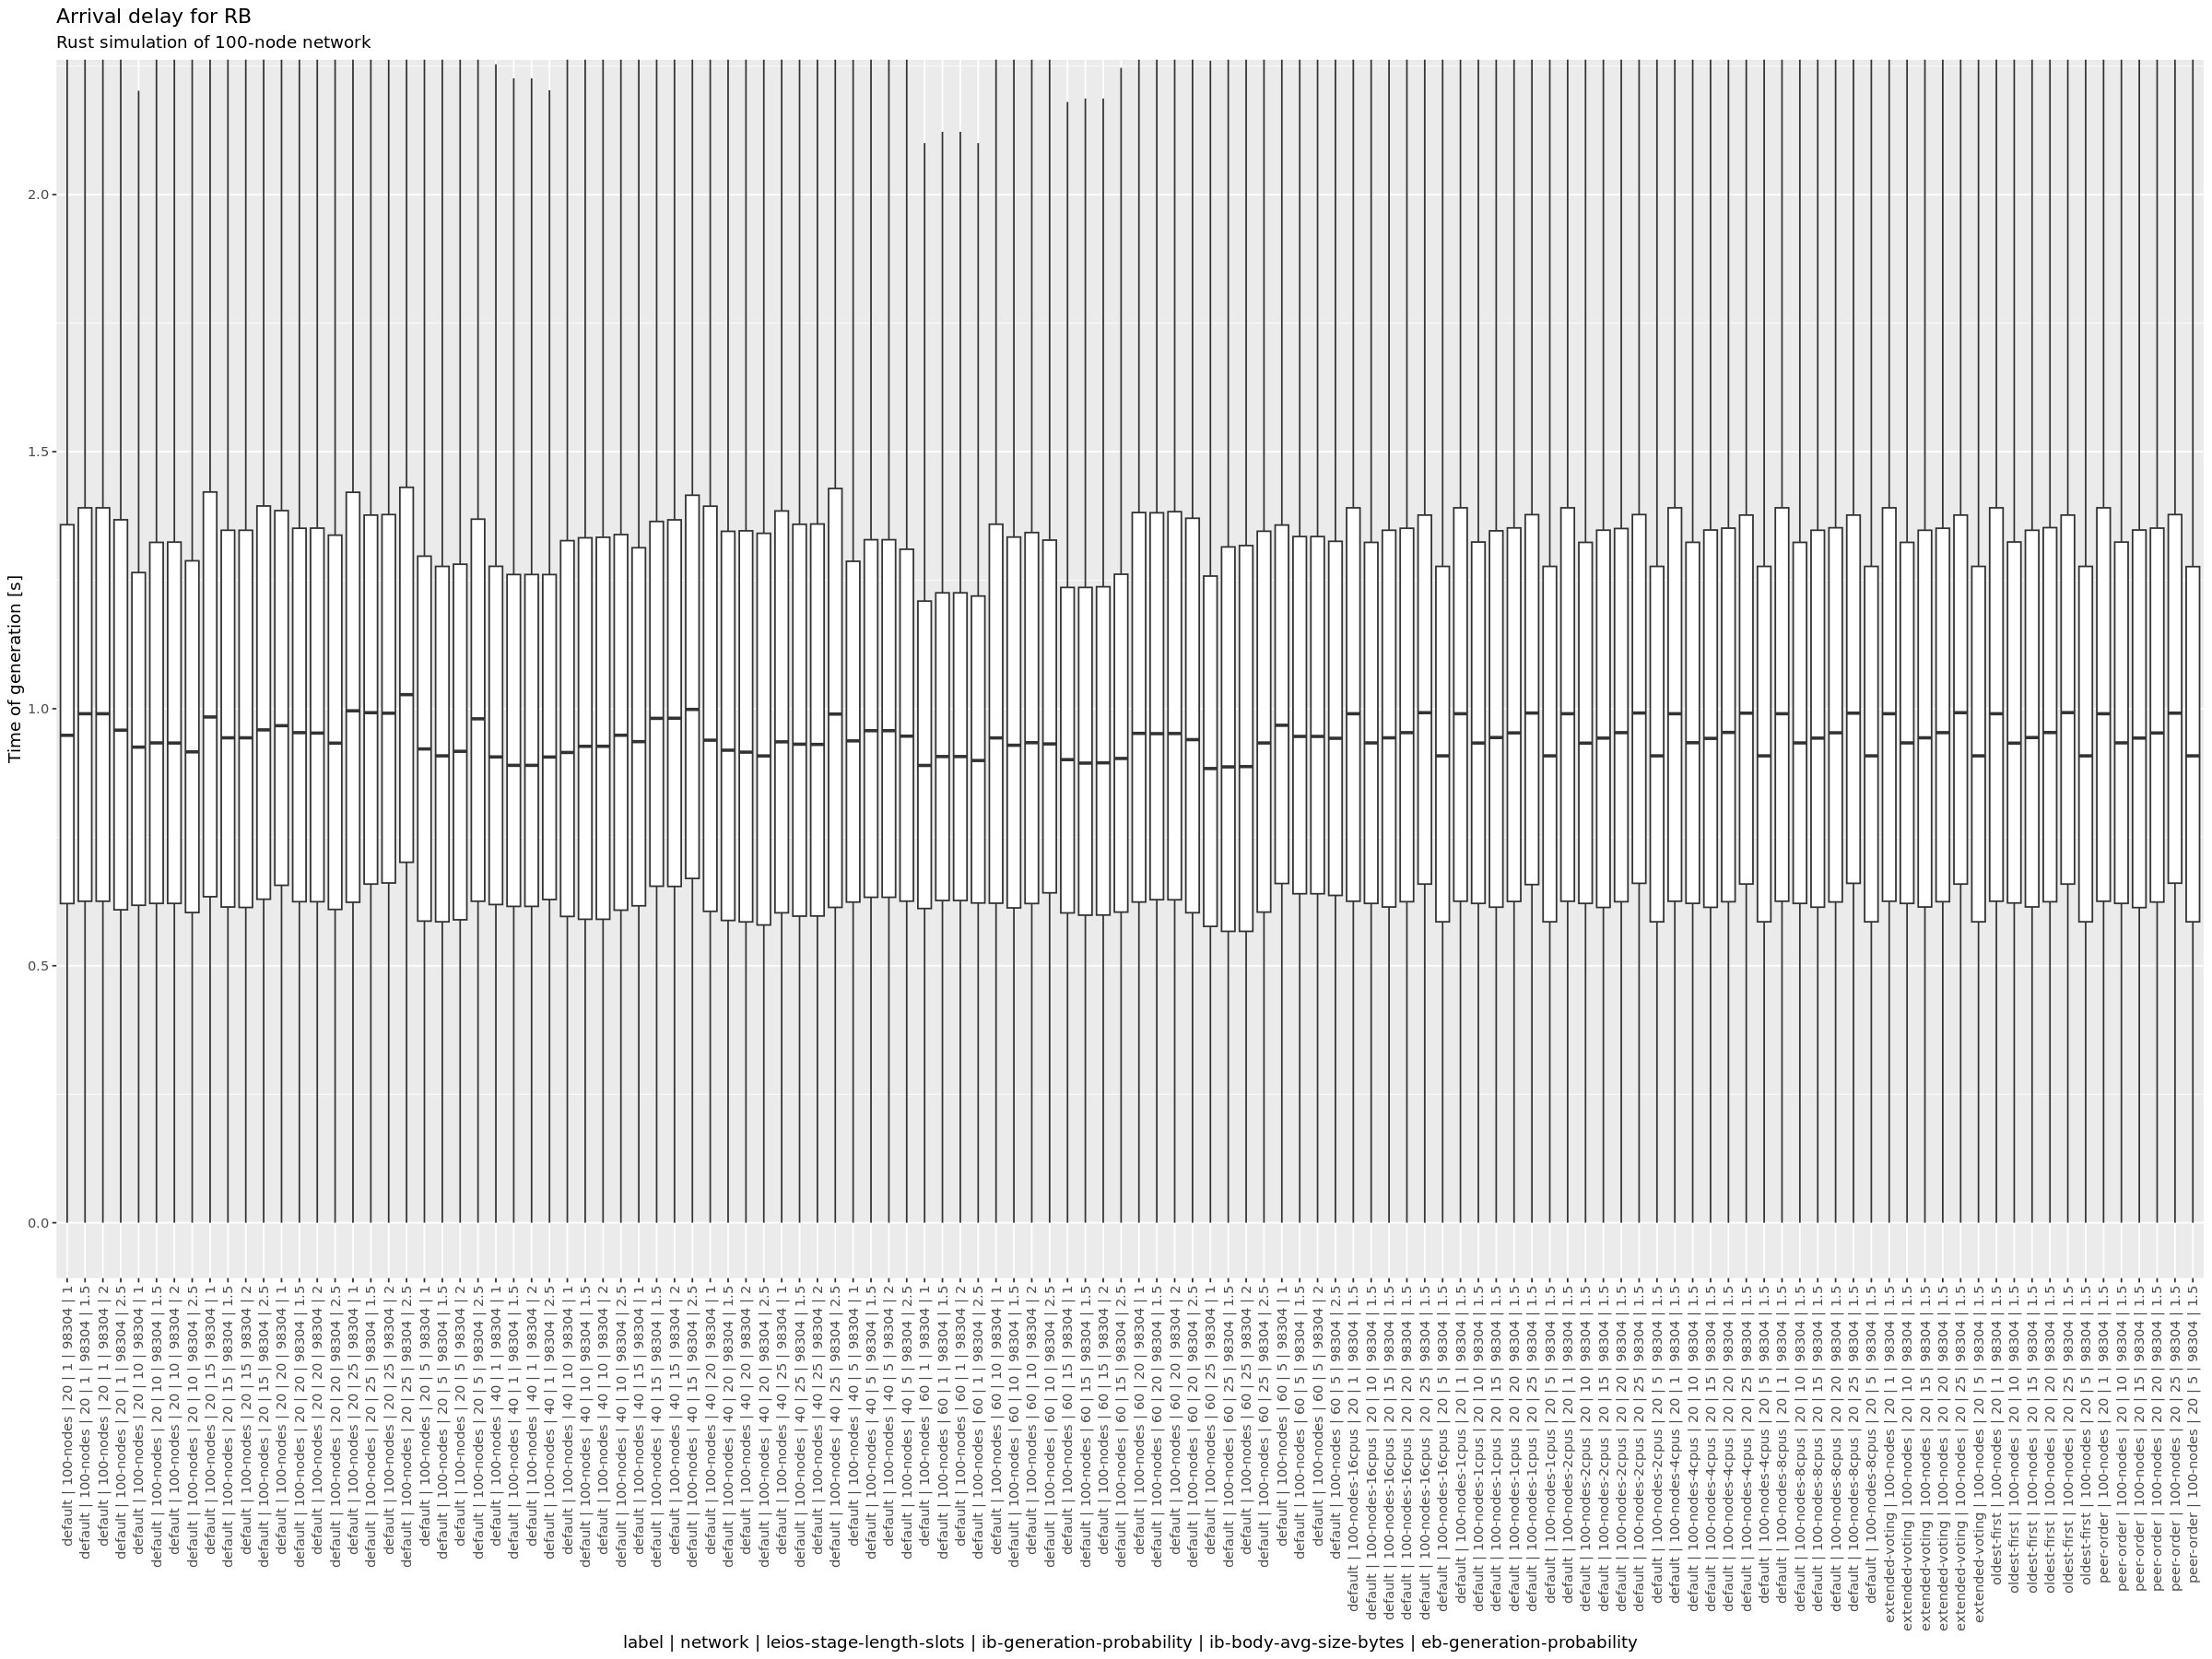

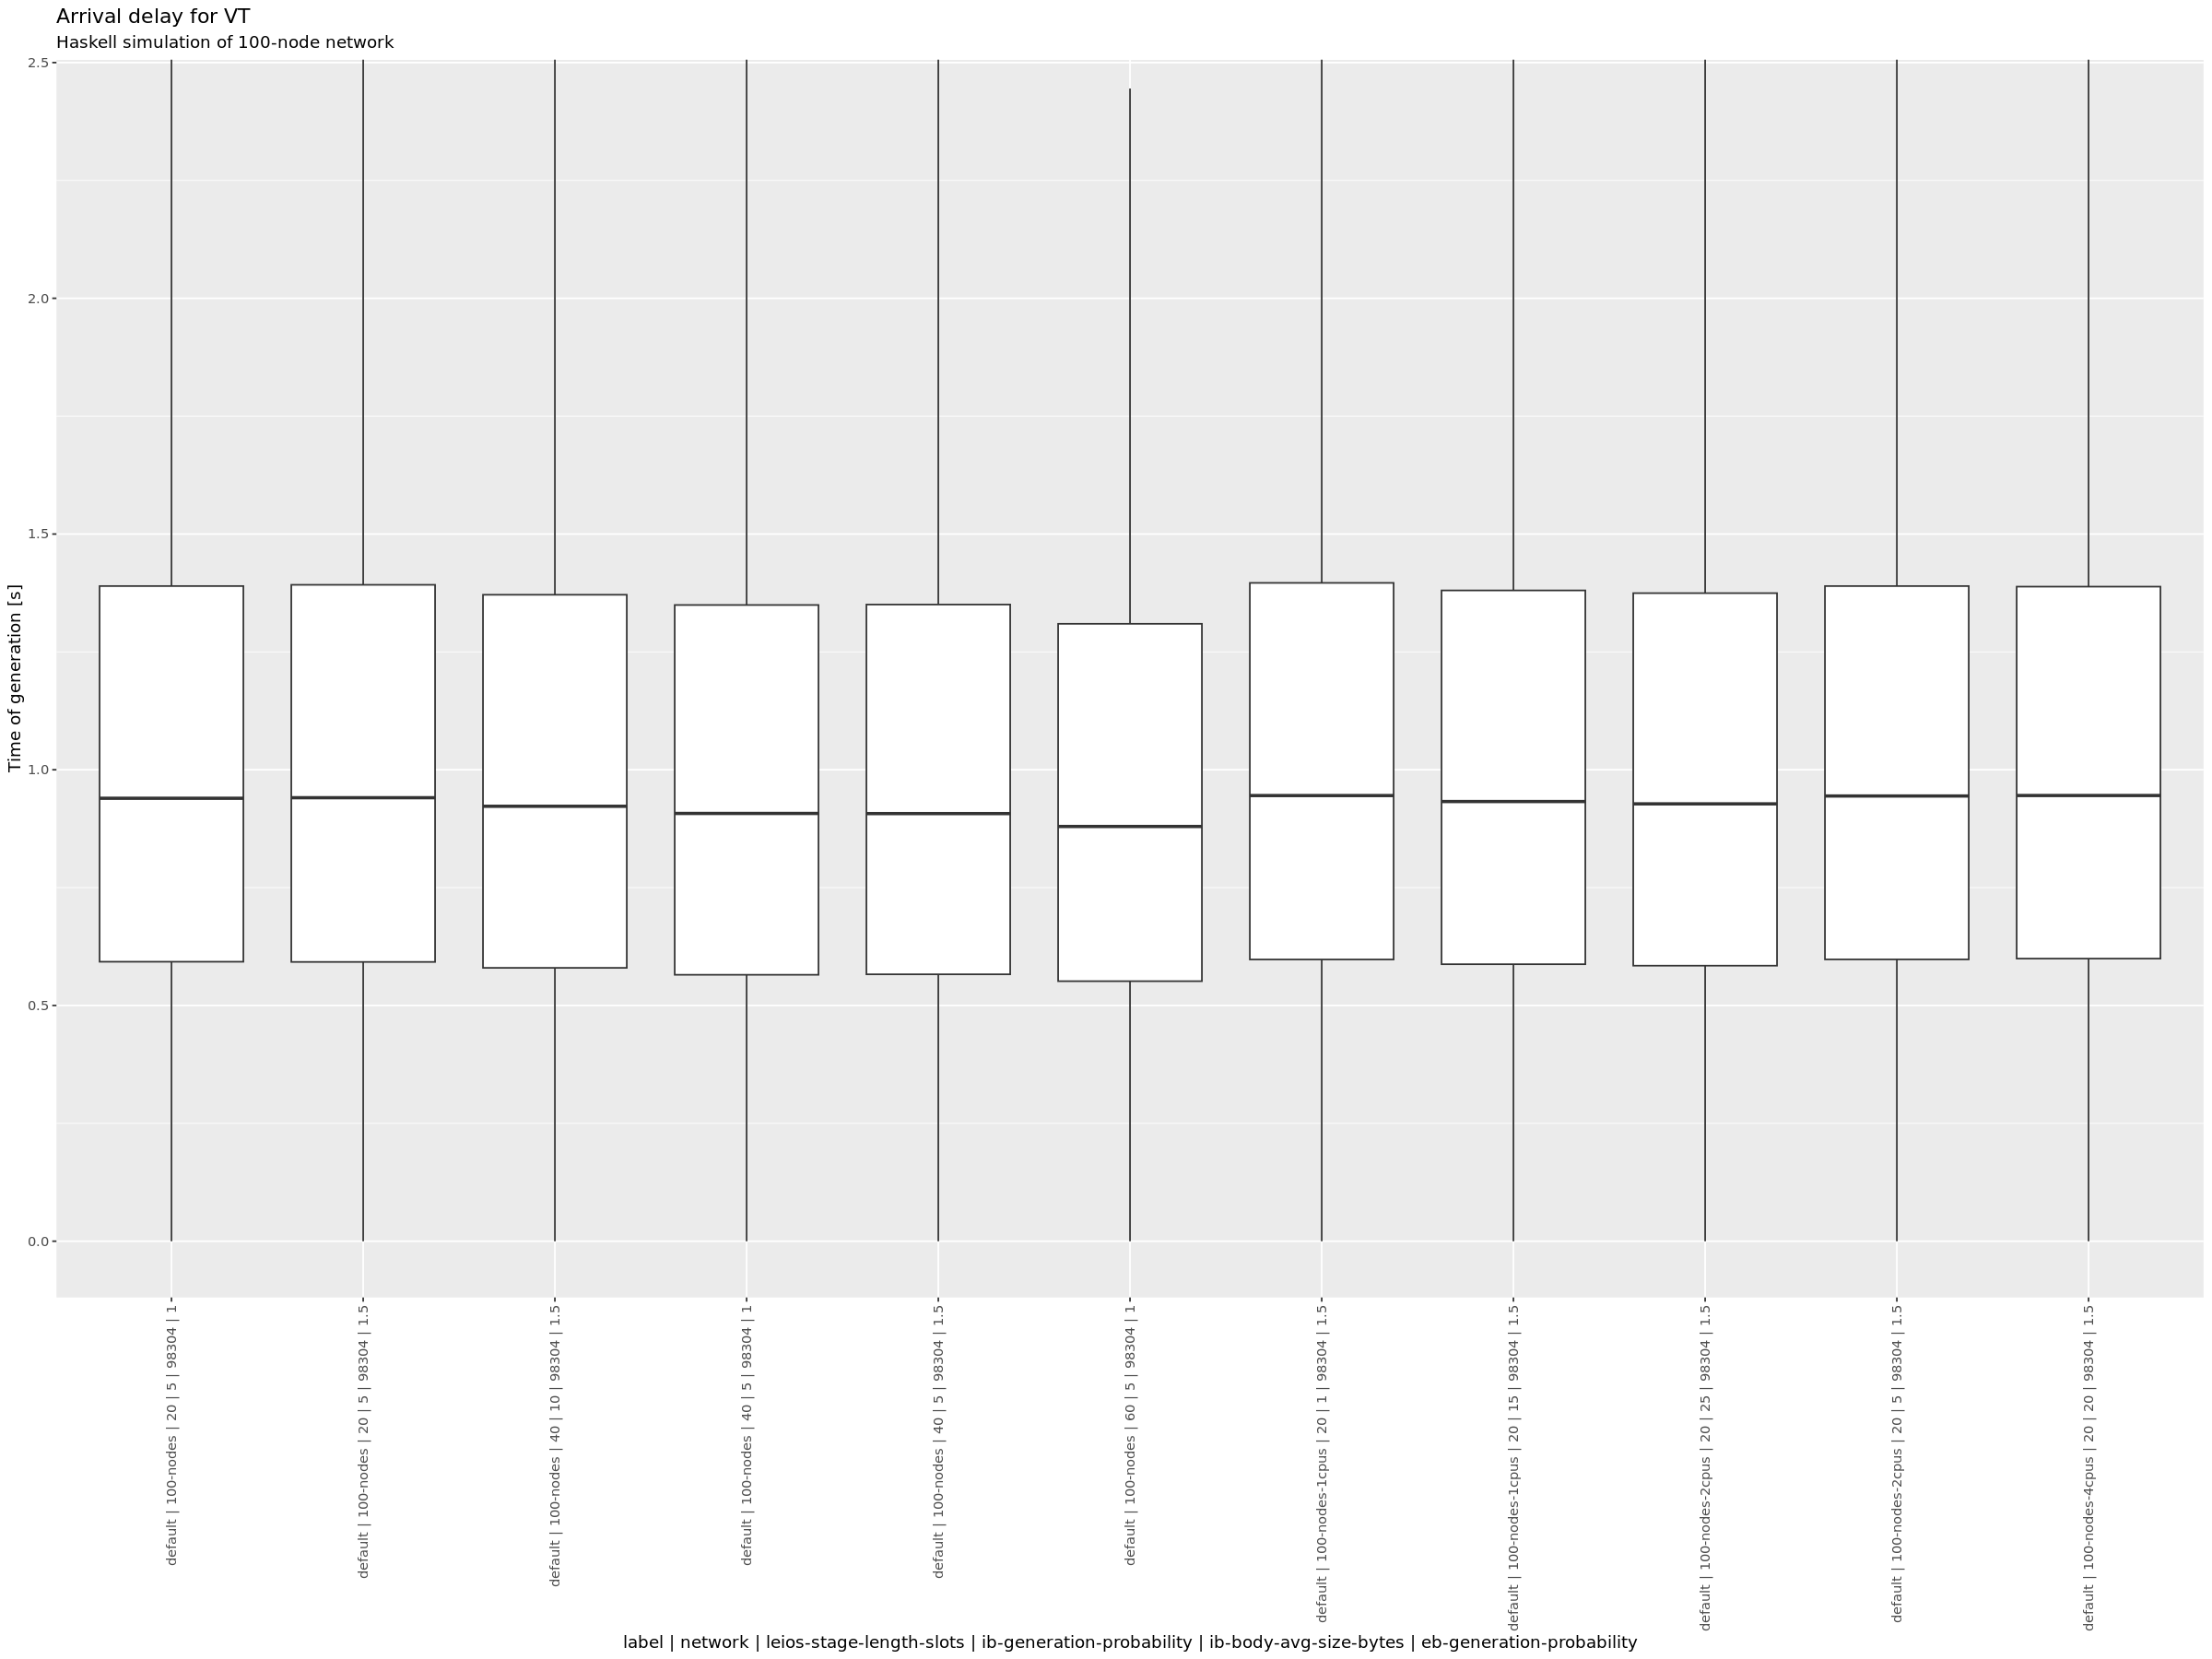

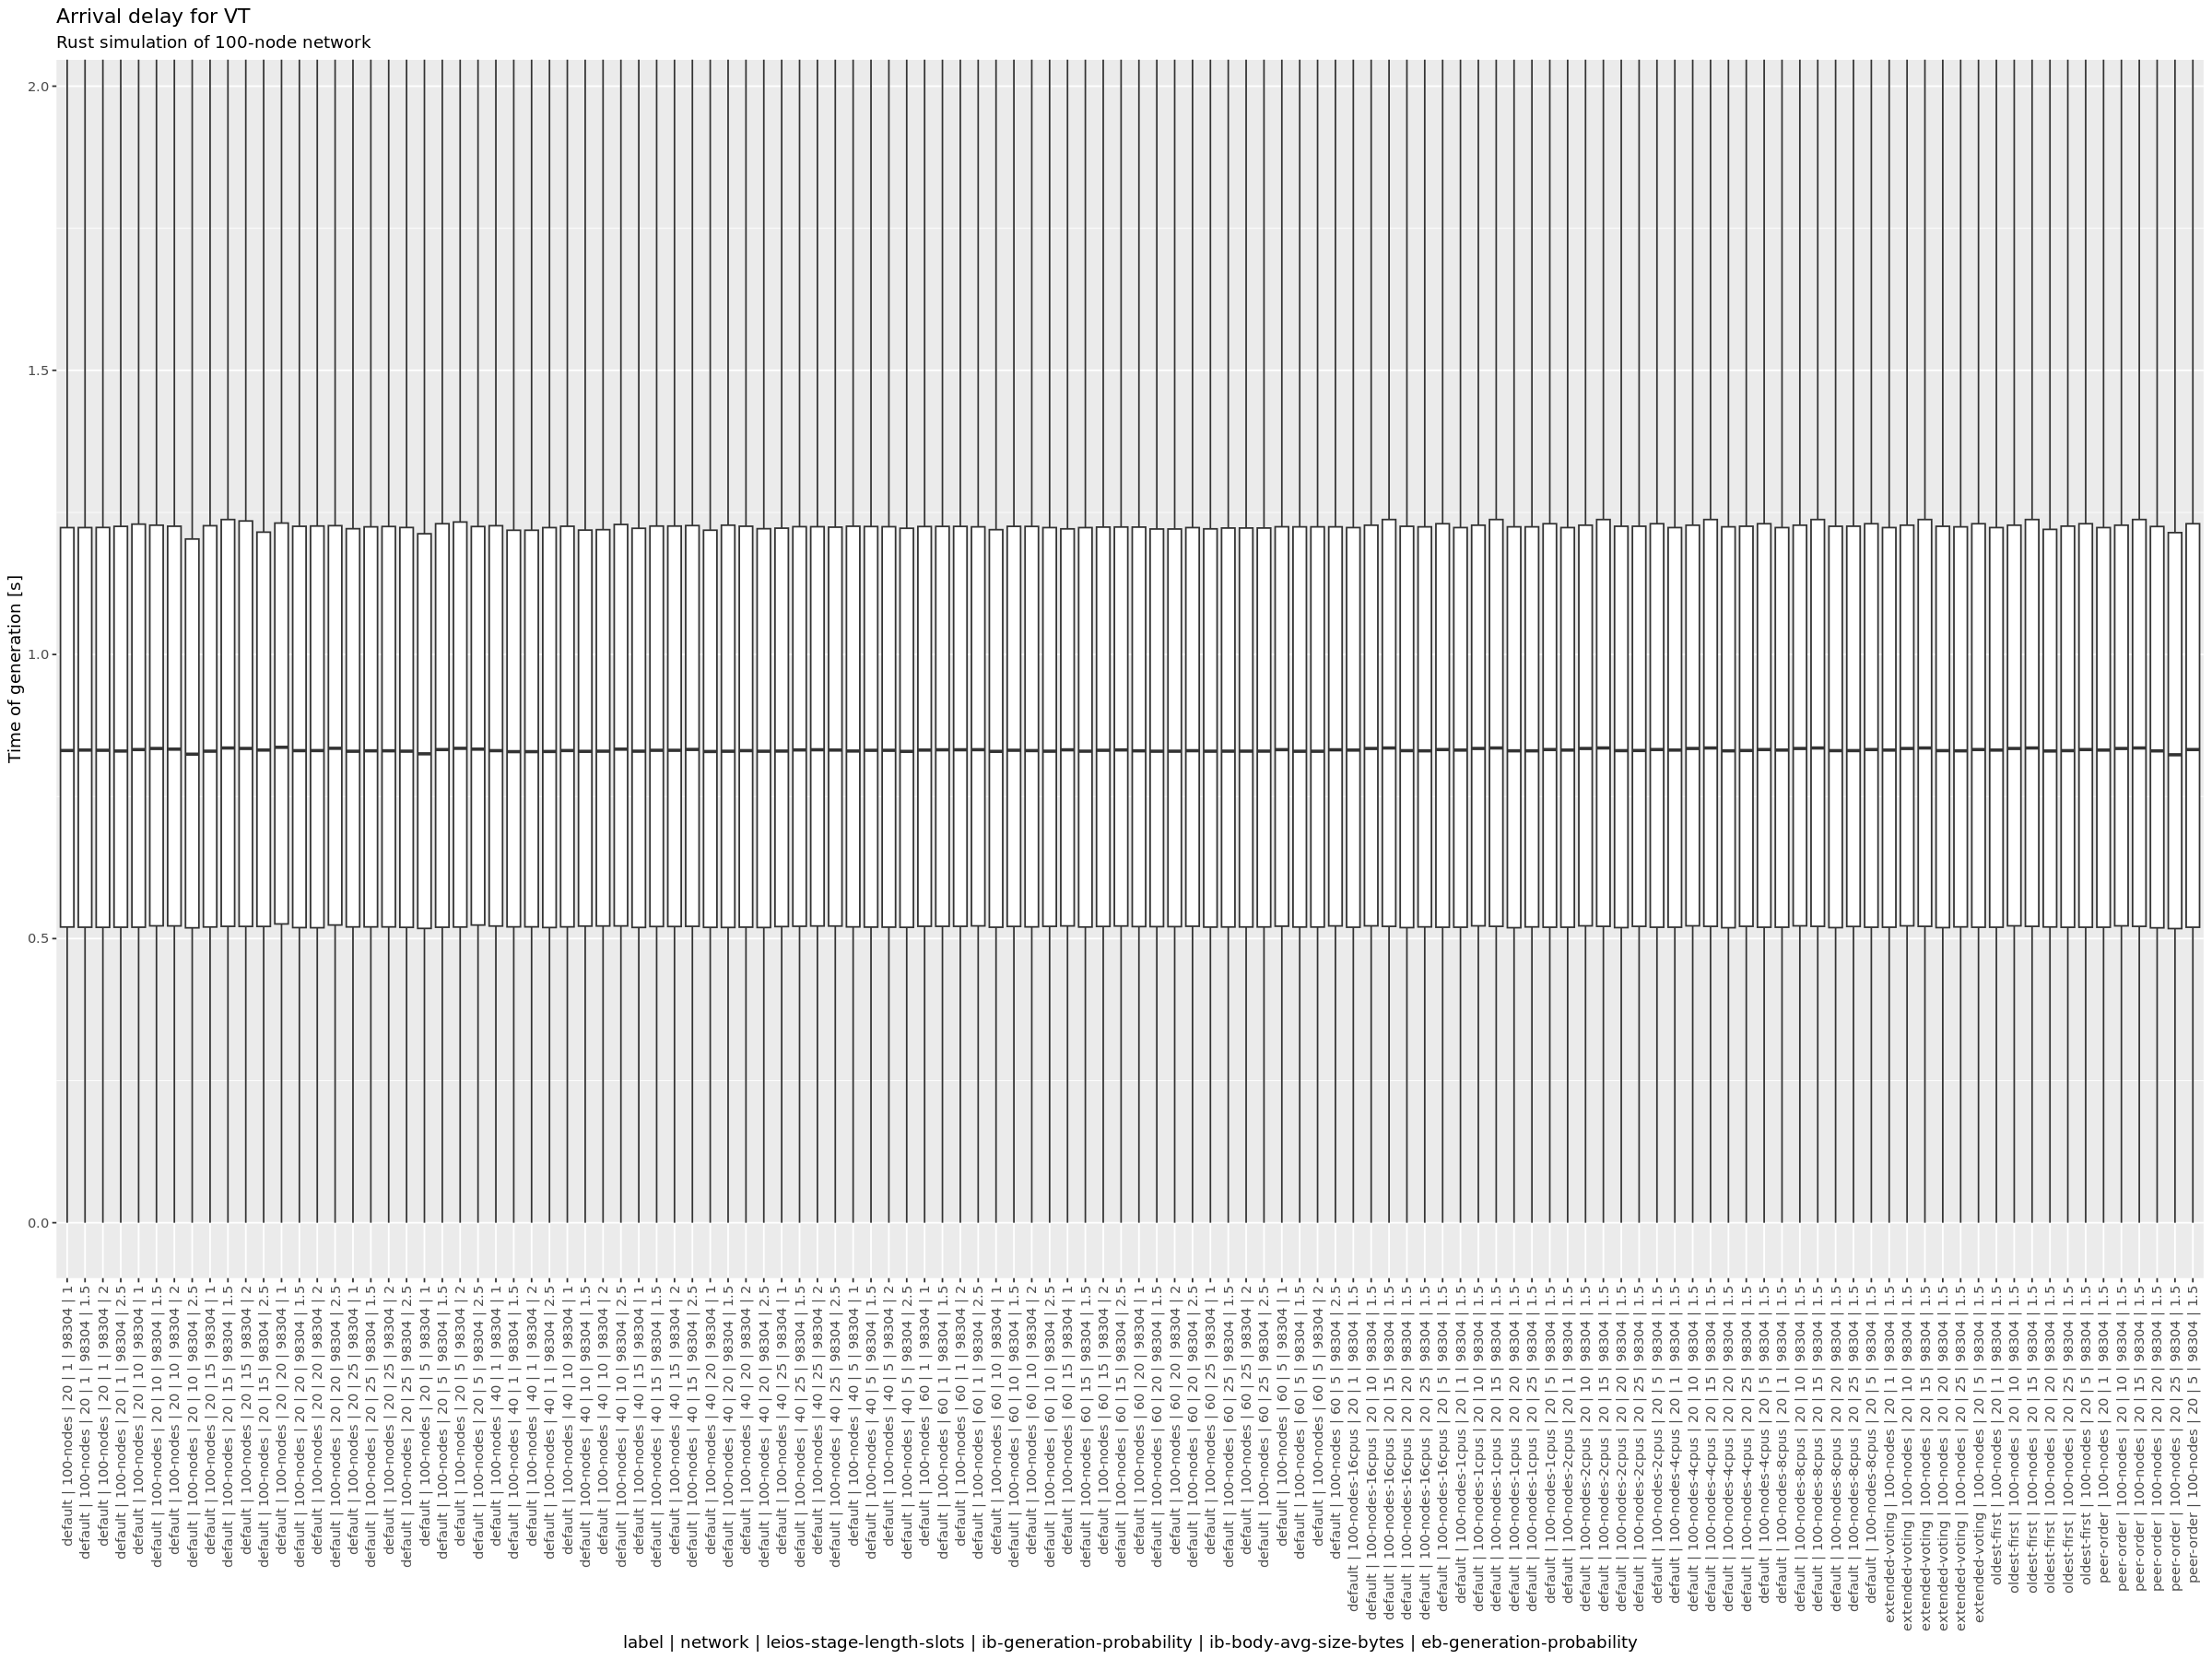

In [46]:
for (k in c("IB", "EB", "RB", "VT")) {
for (s in c("haskell", "rust")) {
    d <- receiptScenario[`simulator` == s & `kind` == k]
    g <- ggplot(d, aes(x=`scenario`, y=`elapsed`)) +
        geom_boxplot(outlier.shape=NA) +
        coord_cartesian(ylim=c(0, d[, quantile(`elapsed`, probs=0.99)])) +
        xlab("label | network | leios-stage-length-slots | ib-generation-probability | ib-body-avg-size-bytes | eb-generation-probability") +
        ylab("Time of generation [s]") +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
        ggtitle(paste("Arrival delay for", k), subtitle=paste(s %>% str_to_title, "simulation of 100-node network"))
    print(g)
    ggsave(paste0("plots/elapsed-boxplot-", k, "-", s, ".png"), units="in", width=15, height=6, dpi=150)
}
}